In [1]:
import numpy as np
import pandas as pd
import os
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import product, combinations
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import HuberRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from numpy.random import rand
from tensorflow.keras.models import load_model

2024-04-28 05:12:16.380173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file_path = 'Tidf.csv'
df = pd.read_csv(file_path)

In [3]:
df

Density  Young's Modulus  Yield Strength  Tensile Strength  \
0       4.65         0.222419       -0.003330         -0.011765   
1       4.85        -0.642280        0.237168          0.303573   
2       4.48         0.438593       -0.075479         -0.024904   
3       4.82        -0.966541       -0.228797         -0.300824   
4       4.65         0.492637        0.718165          0.553215   
..       ...              ...             ...               ...   
196     4.48         0.535872       -0.424202         -0.300824   
197     4.70        -0.318018        1.379536          1.170751   
198     4.65         0.870942        0.207106          0.145904   
199     4.82        -0.372061       -0.123579         -0.064321   
200     4.85        -0.642280        0.417542          0.329851   

     Specific Heat  Coefficient of Thermal Expansion  Aluminum, Al  Carbon, C  \
0         0.204190                          2.448837         3.400     0.0500   
1         0.204190                         -0.844828         3.000     0.0500   
2         0.365633                         -0.844828         0.000     0.0000   
3        -0.064434                          0.725015         2.700     0.0800   
4         0.204190                          1.625421         3.000     0.0000   
..             ...                               ...           ...        ...   
196       0.875750                          0.200911         6.107     0.0673   
197       0.204190                         -0.179416         6.318     0.0606   
198      -0.467370                         -0.940893         6.836     0.0829   
199       0.741438                          0.326111         5.734     0.0506   
200       0.204190                         -0.251991         6.120     0.0591   

     Hydrogen, H  Iron, Fe  ...  Yttrium, Y  Zirconium, Zr  Chromium, Cr  \
0       0.015000    1.6000  ...       0.000          0.000         0.000   
1       0.015000    2.0000  ...       0.000          0.000         0.000   
2       0.020000    0.3500  ...       0.000          5.000         0.000   
3       0.015000    0.2000  ...       0.005          2.000         0.000   
4       0.000000    0.0000  ...       0.000          0.000         0.000   
..           ...       ...  ...         ...            ...           ...   
196     0.014965    0.3662  ...       0.000          0.116         0.110   
197     0.014090    0.2185  ...       0.000          2.478         0.030   
198     0.013490    0.3627  ...       0.000          1.992         1.270   
199     0.013265    0.3970  ...       0.000          3.118         1.200   
200     0.013865    0.2330  ...       0.000          2.346         0.705   

     Silicon, Si  Palladium, Pd  Tantalum, Ta  Niobium, Nb (Columbium, Cb)  \
0         0.0000            0.0           0.0                          0.0   
1         0.0000            0.0           0.0                          0.0   
2         0.0000            0.0           0.0                          0.0   
3         0.0000            0.0           0.0                          0.0   
4         0.0000            0.0           0.0                          0.0   
..           ...            ...           ...                          ...   
196       0.0020            0.0           0.0                          0.0   
197       0.1511            0.0           0.0                          0.0   
198       0.1085            0.0           0.0                          0.0   
199       0.1234            0.0           0.0                          0.0   
200       0.0989            0.0           0.0                          0.0   

     Copper, Cu  Manganese, Mn  Bismuth, Bi  
0        0.0000           0.00        0.000  
1        0.0000           0.00        0.000  
2        0.0000           0.00        0.000  
3        0.0000           0.00        0.000  
4        0.0000           0.00        0.000  
..          ...            ...          ...  
196      0.1105           0.00        0.000  
197      

In [4]:
duplicate_rows = df[df.duplicated()]
num_duplicate_rows = duplicate_rows.shape[0]

if num_duplicate_rows == 0:
    print("No duplicate rows found.")
else:
    print(f"Found {num_duplicate_rows} duplicate rows.")
    print(duplicate_rows)

Found 30 duplicate rows.
      Density  Young's Modulus  Yield Strength  Tensile Strength  \
78   4.759200         0.149746       -0.097455         -0.213764   
94   4.767837         0.395159       -0.049001          0.073359   
96   4.686415         0.574811        0.053393          0.107020   
97   4.686415         0.574811        0.053393          0.107020   
98   4.686415         0.574811        0.053393          0.107020   
99   4.686415         0.574811        0.053393          0.107020   
100  4.695341         0.920663        0.052114          0.094302   
102  4.767837         0.395159       -0.049001          0.073359   
103  4.767837         0.395159       -0.049001          0.073359   
104  4.695341         0.920663        0.052114          0.094302   
105  4.686415         0.574811        0.053393          0.107020   
106  4.695341         0.920663        0.052114          0.094302   
107  4.695341         0.920663        0.052114          0.094302   
108  4.686415         0

In [5]:
def extract_numeric(value):
    if pd.isna(value):
        return None
    # Ensure the input is treated as a string
    value = str(value)
    numeric_part = re.findall(r"[\d\.]+", value)
    return float(numeric_part[0]) if numeric_part else None

## Youngs Modulus

### Data Preperation

In [6]:
# Assuming df1 is your DataFrame and it contains the columns 'Young's Modulus' and 'Density'
df['Young\'s Modulus'] = df['Young\'s Modulus'].apply(extract_numeric)
df['Density'] = df['Density'].apply(extract_numeric)

# List all columns to keep (metal percentages and Young's modulus)
columns_to_keep = ['Young\'s Modulus'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_modulus = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_modulus.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_modulus.head()

(Series([], dtype: int64),
    Young's Modulus  Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  \
 0         0.222419           3.4       0.05        0.015      1.60   
 1         0.642280           3.0       0.05        0.015      2.00   
 2         0.438593           0.0       0.00        0.020      0.35   
 3         0.966541           2.7       0.08        0.015      0.20   
 4         0.492637           3.0       0.00        0.000      0.00   
 
    Nitrogen, N  Oxygen, O  Titanium, Ti  Vanadium, V  Molybdenum, Mo  ...  \
 0         0.05       0.13        82.855          9.0             0.0  ...   
 1         0.00       0.10        79.000          8.0             8.0  ...   
 2         0.05       0.20        80.000          0.0            15.0  ...   
 3         0.05       0.15        75.000         13.0             0.0  ...   
 4         0.00       0.00        94.500          2.5             0.0  ...   
 
    Yttrium, Y  Zirconium, Zr  Chromium, Cr  Silicon, Si  Palladium, Pd  \


In [7]:
# Splitting the dataset into features and target variable
X = metals_and_modulus.drop("Young's Modulus", axis=1)
y = metals_and_modulus["Young's Modulus"]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  Nitrogen, N  Oxygen, O  \
 198       6.83600   0.082900     0.013490  0.362700     0.074200   0.161000   
 38        7.82150   0.069100     0.014880  0.290000     0.050000   0.142800   
 24        6.29600   0.060000     0.013730  0.232400     0.050000   0.150400   
 122       6.68391   0.067627     0.027655  0.430395     0.073237   0.156627   
 196       6.10700   0.067300     0.014965  0.366200     0.047500   0.179000   
 
      Titanium, Ti  Vanadium, V  Molybdenum, Mo  Nickel, Ni  ...  Yttrium, Y  \
 198     87.075290       2.1800         1.80850         0.0  ...         0.0   
 38      86.366270       1.3350         1.07850         0.0  ...         0.0   
 24      87.983030       0.0000         1.52300         0.0  ...         0.0   
 122     86.415666       2.6961         2.13013         0.0  ...         0.0   
 196     88.600010       2.8975         0.24250         0.0  ...         0.0   
 
      Zirconium, Zr  Chromium, Cr  S

### Feature Selection

#### Random Forest Feature Importance

In [8]:
def train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, feature_name, metal="Titanium"):
    """
    Trains a Random Forest regressor, evaluates it, plots feature importances,
    and generates a LaTeX figure caption, with the ability to specify the target feature name.

    Parameters:
        X_train (DataFrame): Training data features.
        y_train (Series): Training data target.
        X_test (DataFrame): Test data features.
        y_test (Series): Test data target.
        output_dir (str): Directory to save output files.
        feature_name (str): The name of the target feature to use in titles and labels.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Initialize the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    rf_predictions = rf_model.predict(X_test)

    # Calculate the mean squared error
    rf_mse = mean_squared_error(y_test, rf_predictions)

    # Get feature importances from the Random Forest model
    rf_feature_importances = rf_model.feature_importances_

    # Create a DataFrame for better visualization of feature importances
    features_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=features_importance_df, color='blue')
    plt.title(f'Feature Importances in Predicting {feature_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plot_path = os.path.join(output_dir, f'{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance.png')
    plt.savefig(plot_path)
    plt.show()

    # LaTeX code for the figure
    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_path}}}
        \caption{{Random Forest Feature Importance for predicting {feature_name}}}
        \label{{fig:{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance}}
    \end{{figure}}
    """
    latex_file_path = os.path.join(output_dir, f'{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance.tex')
    with open(latex_file_path, 'w') as f:
        f.write(latex_code)

    return rf_mse, features_importance_df

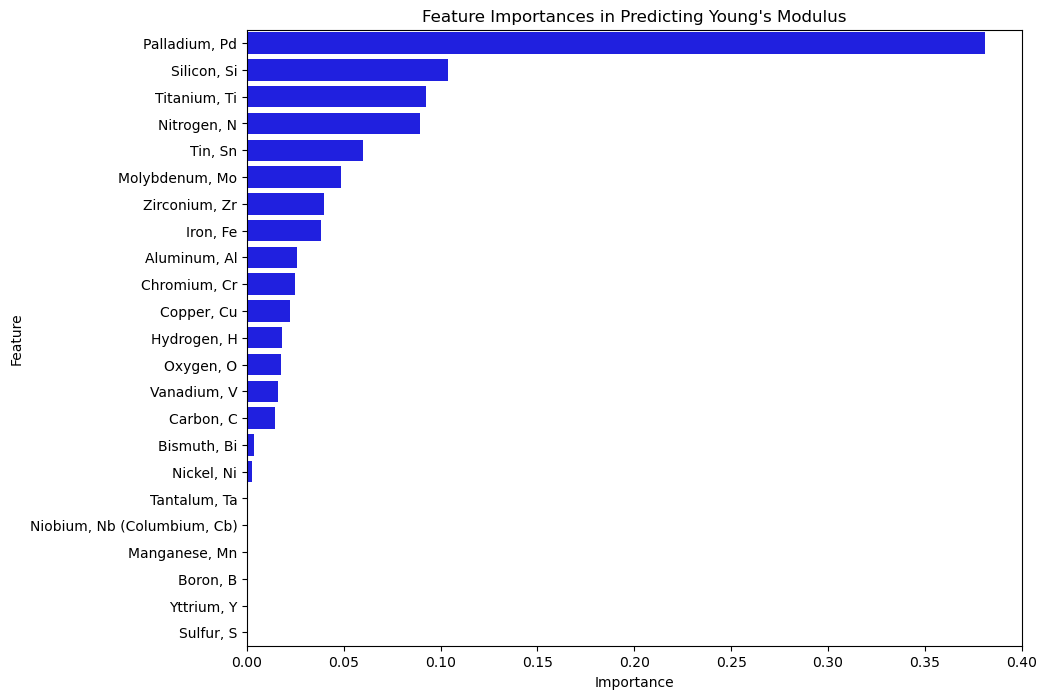

(0.06393721053878755,
                         Feature  Importance
 17                Palladium, Pd    0.381168
 16                  Silicon, Si    0.103801
 6                  Titanium, Ti    0.092679
 4                   Nitrogen, N    0.089505
 12                      Tin, Sn    0.059681
 8                Molybdenum, Mo    0.048742
 14                Zirconium, Zr    0.039742
 3                      Iron, Fe    0.038001
 0                  Aluminum, Al    0.025880
 15                 Chromium, Cr    0.024545
 20                   Copper, Cu    0.022353
 2                   Hydrogen, H    0.018228
 5                     Oxygen, O    0.017564
 7                   Vanadium, V    0.016206
 1                     Carbon, C    0.014266
 22                  Bismuth, Bi    0.003380
 9                    Nickel, Ni    0.002451
 18                 Tantalum, Ta    0.000577
 19  Niobium, Nb (Columbium, Cb)    0.000397
 21                Manganese, Mn    0.000369
 11                     Boron, B 

In [9]:
output_dir = "Images/Titanium/Young Modulus"
train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, "Young's Modulus")

#### Combination Neural Network Feature Combination Importance

In [10]:
def needs_analysis(filename, expected_combinations):
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        existing_combos = set(tuple(row) for row in existing_df['Combination'].apply(eval))
        # Convert expected_combinations to a set
        expected_combos_set = set(expected_combinations)
        if existing_combos >= expected_combos_set:
            print("All combinations have already been evaluated.")
            return False
    return True

In [11]:
def process2VariableMLP(data, top_features, fixed_feature, modulus_feature, file_path, plot_dir, metal="Titanium"):
    """
    Processes alloy data to train a neural network model and visualize the results.
    
    Parameters:
    - data (DataFrame): The dataset containing alloy compositions.
    - top_features (list): List of the alloy elements to consider in combinations.
    - fixed_feature (str): The fixed feature in all combinations.
    - modulus_feature (str): The name of the column for Young's modulus.
    - file_path (str): Path to save or load the MSE results.
    - plot_dir (str): Directory to save plots and LaTeX files.
    """
    # Extract features and target based on provided column names
    X = data[top_features + [fixed_feature]]
    y = data[modulus_feature]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if os.path.exists(file_path):
        print("Loading existing results...")
        results_df = pd.read_csv(file_path)
        results_df['Combination'] = results_df['Combination'].apply(ast.literal_eval)
        best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
    else:
        print("Processing new combinations...")
        mse_scores = {}
        full_combinations = [combo + (fixed_feature,) for combo in combinations(top_features, 1)]
        for combo in full_combinations:
            print(f'Processing combination: {combo}')
            X_train_sub = X_train[list(combo)]
            X_test_sub = X_test[list(combo)]

            # Define and compile the neural network
            nn_model = Sequential([
                Dense(3, input_dim=len(combo), activation='relu'),
                Dense(3, activation='relu'),
                Dense(3, activation='relu'),
                Dense(1)
            ])
            nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
            nn_model.fit(X_train_sub, y_train, epochs=200, batch_size=10, verbose=0, validation_split=0.2)
            mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
            mse_scores[combo] = mse

        results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
        results_df.to_csv(file_path, index=False)
        best_combination = min(mse_scores, key=mse_scores.get)

    # Fit the best combination model for visualization
    nn_model = Sequential([
        Dense(3, input_dim=len(best_combination), activation='relu'),
        Dense(3, activation='relu'),
        Dense(3, activation='relu'),
        Dense(1)
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    nn_model.fit(X_train[list(best_combination)], y_train, epochs=200, batch_size=10, verbose=0, validation_split=0.2)
    y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

    # Visualization
    element_name = ', '.join(best_combination)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', marker='o', alpha=0.5, label='Predicted Values')  # Predicted values as blue circles
    plt.scatter(y_test, y_test, color='red', marker='x', label='Actual Values')  # Actual values as red x's
    plt.title(f"Actual vs. Predicted {modulus_feature} Values (2 Variables - {element_name})")
    plt.xlabel(f"Actual {modulus_feature}")
    plt.ylabel(f"Predicted {modulus_feature}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='Ideal Prediction Line')  # Ideal prediction line
    plt.legend()  # Add a legend to clarify the plot symbols

    # Ensure directory exists
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    plot_path = os.path.join(plot_dir, f'{metal}_{modulus_feature.replace(" ", "_")}_2VariableMLP.png')
    plt.savefig(plot_path)
    plt.show()
    fixed_feature
    
    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_path}}}
        \caption{{2 Variable Simple MLP for predicting {modulus_feature} (Featuring: {element_name})}}
        \label{{fig:{metal}_{modulus_feature.replace(" ", "_")}_2VariableMLP}}
    \end{{figure}}
    """

    # Write the LaTeX code to a .tex file
    tex_path = os.path.join(plot_dir, f'{metal}_{modulus_feature.replace(" ", "_")}_2VariableMLP.tex')
    with open(tex_path, 'w') as f:
        f.write(latex_code)

    print(f"Best combination including {fixed_feature}: {best_combination}, MSE: {results_df['MSE'].min()}")
    print(f"Graph and LaTeX file saved with element pair in names: {plot_path} and {tex_path}")

In [12]:
def process3VariableMLP(data, top_features, fixed_feature, modulus_feature, file_path, plot_dir, metal="Titanium"):
    """
    Processes alloy data to train a neural network model and visualize the results.
    
    Parameters:
    - data (DataFrame): The dataset containing alloy compositions.
    - top_features (list): List of the alloy elements to consider in combinations.
    - fixed_feature (str): The fixed feature in all combinations.
    - modulus_feature (str): The name of the column for Young's modulus.
    - file_path (str): Path to save or load the MSE results.
    - plot_dir (str): Directory to save plots and LaTeX files.
    """
    # Extract features and target based on provided column names
    X = data[top_features + [fixed_feature]]
    y = data[modulus_feature]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if os.path.exists(file_path):
        print("Loading existing results...")
        results_df = pd.read_csv(file_path)
        results_df['Combination'] = results_df['Combination'].apply(ast.literal_eval)
        best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
    else:
        print("Processing new combinations...")
        mse_scores = {}
        full_combinations = [combo + (fixed_feature,) for combo in combinations(top_features, 2)]
        for combo in full_combinations:
            print(f'Processing combination: {combo}')
            X_train_sub = X_train[list(combo)]
            X_test_sub = X_test[list(combo)]

            # Define and compile the neural network
            nn_model = Sequential([
                Dense(3, input_dim=len(combo), activation='relu'),
                Dense(3, activation='relu'),
                Dense(3, activation='relu'),
                Dense(1)
            ])
            nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
            nn_model.fit(X_train_sub, y_train, epochs=200, batch_size=10, verbose=0, validation_split=0.2)
            mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
            mse_scores[combo] = mse

        results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
        results_df.to_csv(file_path, index=False)
        best_combination = min(mse_scores, key=mse_scores.get)

    # Fit the best combination model for visualization
    nn_model = Sequential([
        Dense(3, input_dim=len(best_combination), activation='relu'),
        Dense(3, activation='relu'),
        Dense(3, activation='relu'),
        Dense(1)
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    nn_model.fit(X_train[list(best_combination)], y_train, epochs=200, batch_size=10, verbose=0, validation_split=0.2)
    y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

    # Visualization
    element_name = ', '.join(best_combination)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', marker='o', alpha=0.5, label='Predicted Values')  # Predicted values as blue circles
    plt.scatter(y_test, y_test, color='red', marker='x', label='Actual Values')  # Actual values as red x's
    plt.title(f"Actual vs. Predicted {modulus_feature} Values (3 Variables - {element_name})")
    plt.xlabel(f"Actual {modulus_feature}")
    plt.ylabel(f"Predicted {modulus_feature}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='Ideal Prediction Line')  # Ideal prediction line
    plt.legend()  # Add a legend to clarify the plot symbols

    # Ensure directory exists
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    plot_path = os.path.join(plot_dir, f'{metal}_{modulus_feature.replace(" ", "_")}_3VariableMLP.png')
    plt.savefig(plot_path)
    plt.show()
    fixed_feature
    
    latex_code = rf"""
    \begin{{figure}}[h]
        \centering
        \includegraphics[width=0.8\textwidth]{{{plot_path}}}
        \caption{{3 Variable Simple MLP for predicting {modulus_feature} (Featuring: {element_name})}}
        \label{{fig:{metal}_{modulus_feature.replace(" ", "_")}_3VariableMLP}}
    \end{{figure}}
    """

    # Write the LaTeX code to a .tex file
    tex_path = os.path.join(plot_dir, f'{metal}_{modulus_feature.replace(" ", "_")}_3VariableMLP.tex')
    with open(tex_path, 'w') as f:
        f.write(latex_code)

    print(f"Best combination including {fixed_feature}: {best_combination}, MSE: {results_df['MSE'].min()}")
    print(f"Graph and LaTeX file saved with element pair in names: {plot_path} and {tex_path}")

Loading existing results...
2/2 [==============================] - 0s 6ms/step


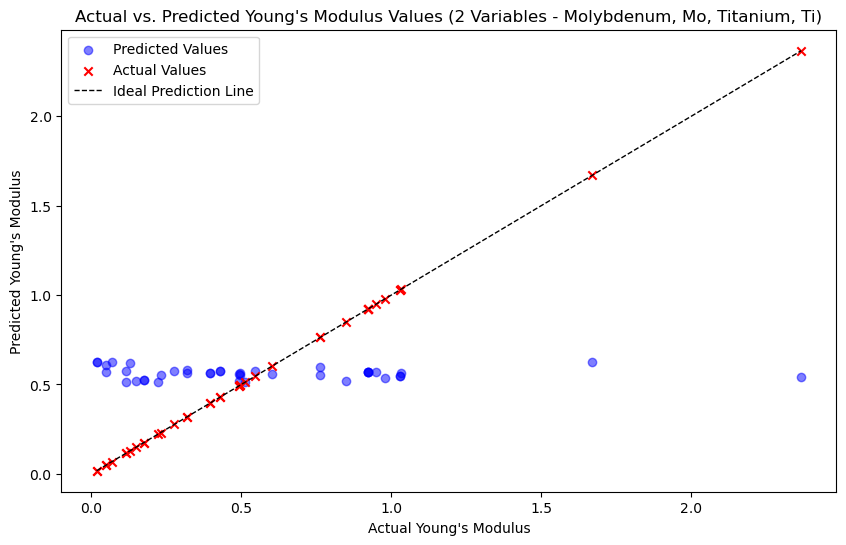

Best combination including Titanium, Ti: ('Molybdenum, Mo', 'Titanium, Ti'), MSE: 0.219252347946167
Graph and LaTeX file saved with element pair in names: Images/Titanium/Young Modulus/Titanium_Young's_Modulus_2VariableMLP.png and Images/Titanium/Young Modulus/Titanium_Young's_Modulus_2VariableMLP.tex


In [13]:
top_features = ['Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']
fixed_feature = 'Titanium, Ti'
file_path = 'Ti_model_data/mse_scores_with_titanium_2_features_modulus.csv'
plotdir = 'Images/Titanium/Young Modulus'
process2VariableMLP(metals_and_modulus, top_features, fixed_feature, "Young's Modulus", file_path, plotdir)

Loading existing results...
2/2 [==============================] - 0s 7ms/step


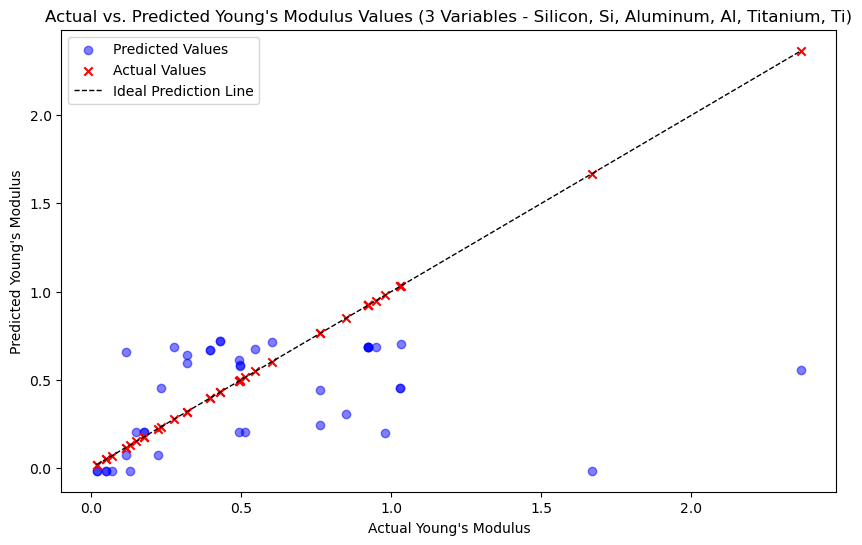

Best combination including Titanium, Ti: ('Silicon, Si', 'Aluminum, Al', 'Titanium, Ti'), MSE: 0.2127387821674347
Graph and LaTeX file saved with element pair in names: Images/Titanium/Young Modulus/Titanium_Young's_Modulus_3VariableMLP.png and Images/Titanium/Young Modulus/Titanium_Young's_Modulus_3VariableMLP.tex


In [14]:
top_features = ['Palladium, Pd', 'Silicon, Si', 'Nitrogen, N', 'Tin, Sn', 'Molybdenum, Mo', 'Zirconium, Zr', 'Iron, Fe', 'Aluminum, Al', 'Chromium, Cr']
fixed_feature = 'Titanium, Ti'
file_path = 'Ti_model_data/mse_scores_with_titanium_3_features_modulus.csv'
plotdir = 'Images/Titanium/Young Modulus'
process3VariableMLP(metals_and_modulus, top_features, fixed_feature, "Young's Modulus", file_path, plotdir)

In [15]:
metals_and_modulus.columns

Index(['Young's Modulus', 'Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Titanium, Ti', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi'],
      dtype='object')

Results file already exists. Loading results...
2/2 [==============================] - 0s 6ms/step
Best combination including Aluminum: ('Molybdenum, Mo', 'Titanium, Ti'), MSE: 0.219252347946167


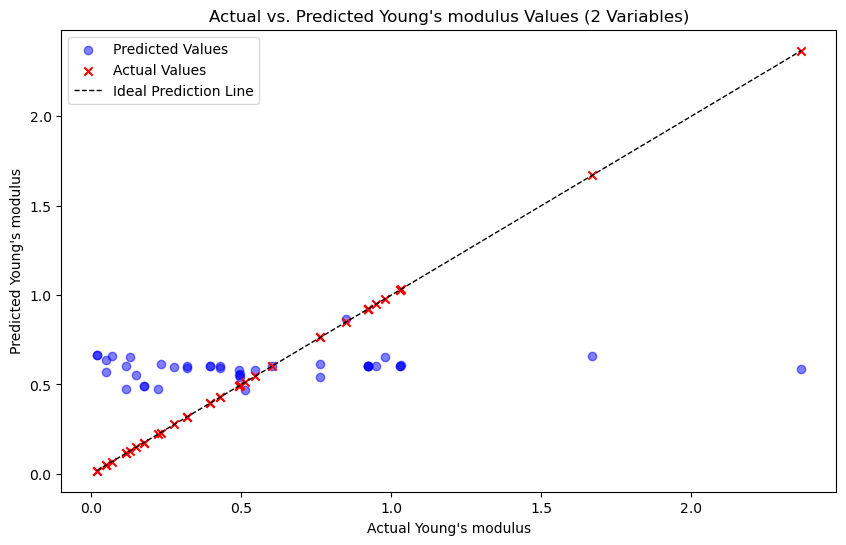

In [16]:
# Assuming metals_and_modulus is preloaded with the relevant data, rename it appropriately if it contains yield strength
top_features = ['Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']
fixed_feature = 'Titanium, Ti'

# Exclude fixed feature if it's accidentally included in top_features
top_features = [feat for feat in top_features if feat != fixed_feature]

# Assuming the DataFrame name that contains 'Yield Strength'
X = metals_and_modulus[top_features + [fixed_feature]]
y = metals_and_modulus["Young's Modulus"]  # Changed from Young's Modulus to Yield Strength

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_2_features_modulus.csv'

# Load or process data
if os.path.exists(file_path):
    print("Results file already exists. Loading results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(lambda x: ast.literal_eval(x))
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("No results file found. Processing new combinations...")
    full_combinations = [(feat, fixed_feature) for feat in top_features]
    mse_scores = {}

    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=2, activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    print("Results saved to", file_path)
    best_combination = tuple(results_df.loc[results_df['MSE'].idxmin(), 'Combination'])

# Define and train the neural network with the best combination
nn_model = Sequential([
    Dense(3, input_dim=2, activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

print(f"Best combination including Aluminum: {best_combination}, MSE: {results_df['MSE'].min()}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', marker='o', alpha=0.5, label='Predicted Values')  # Predicted values as blue circles
plt.scatter(y_test, y_test, color='red', marker='x', label='Actual Values')  # Actual values as red x's
plt.title("Actual vs. Predicted Young's modulus Values (2 Variables)")
plt.xlabel("Actual Young's modulus")
plt.ylabel("Predicted Young's modulus")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='Ideal Prediction Line')  # Ideal prediction line
plt.legend()  # Add a legend to clarify the plot symbols
plt.show()

#### Correlation Matrix 

Palladium, Pd                  0.477824
Silicon, Si                    0.318074
Tin, Sn                        0.200058
Molybdenum, Mo                 0.135609
Aluminum, Al                   0.131664
Chromium, Cr                   0.111025
Nitrogen, N                    0.106963
Zirconium, Zr                  0.058085
Iron, Fe                       0.029831
Niobium, Nb (Columbium, Cb)    0.027073
Copper, Cu                     0.003366
Nickel, Ni                     0.002297
Titanium, Ti                  -0.005389
Hydrogen, H                   -0.008122
Sulfur, S                     -0.015554
Carbon, C                     -0.028063
Manganese, Mn                 -0.028940
Tantalum, Ta                  -0.042593
Bismuth, Bi                   -0.047004
Oxygen, O                     -0.073588
Yttrium, Y                    -0.104915
Boron, B                      -0.104915
Vanadium, V                   -0.134160
Name: Young's Modulus, dtype: float64


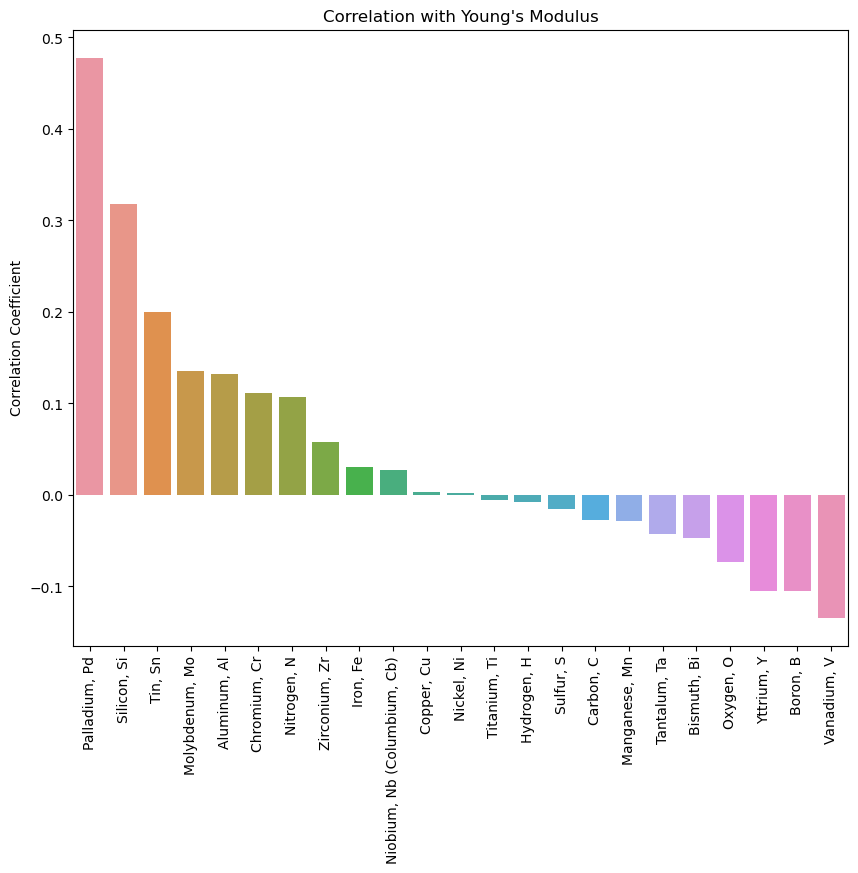

In [17]:
# Calculate correlation matrix including 'Young's Modulus'
corr_matrix = metals_and_modulus.corr()

# Isolate the correlation of 'Young's Modulus' with other features
youngs_corr = corr_matrix["Young's Modulus"].drop("Young's Modulus").sort_values(ascending=False)

# Print the correlation values
print(youngs_corr)

# Visualize correlations using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=youngs_corr.index, y=youngs_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation with Young's Modulus")
plt.ylabel("Correlation Coefficient")
plt.show()

#### Regression

In [18]:
def evaluate_feature(data, feature, target, degree):
    """Evaluate and return a statsmodels regression model."""
    poly = PolynomialFeatures(degree)
    X = data[[feature]].values
    X_poly = poly.fit_transform(X)
    X_poly = sm.add_constant(X_poly)
    y = data[target]
    return sm.OLS(y, X_poly).fit()

def determine_better_model(linear_model, poly_model):
    """Return the better model based on AIC comparison."""
    if linear_model.aic < poly_model.aic:
        return linear_model, 'Linear'
    return poly_model, 'Polynomial'

Positive coefficients indicate an increase in Young's Modulus with an increase in the metal's concentration.

Negative coefficients suggest a decrease in Young's Modulus as the metal's concentration increases.

                          Metal  Coefficient     Effect
0                  Titanium, Ti    -0.000540  Decreases
1                  Aluminum, Al    -0.017522  Decreases
2                     Carbon, C    -0.516533  Decreases
3                   Hydrogen, H    -0.405479  Decreases
4                      Iron, Fe    -0.405579  Decreases
5                   Nitrogen, N     1.861082  Increases
6                     Oxygen, O    -0.863791  Decreases
7                   Vanadium, V    -0.022952  Decreases
8                Molybdenum, Mo    -0.010593  Decreases
9                    Nickel, Ni    -0.019847  Decreases
10                      Tin, Sn     0.085739  Increases
11                Zirconium, Zr    -0.016292  Decreases
12                 Chromium, Cr    -0.017754  Decreases
13                  Silicon, Si     2.881558  Increases
14                Palladium, Pd    14.589254  Increases
15                 Tantalum, Ta    -0.013604  Decreases
16  Niobium, Nb (Columbium, Cb)     0.040214  In

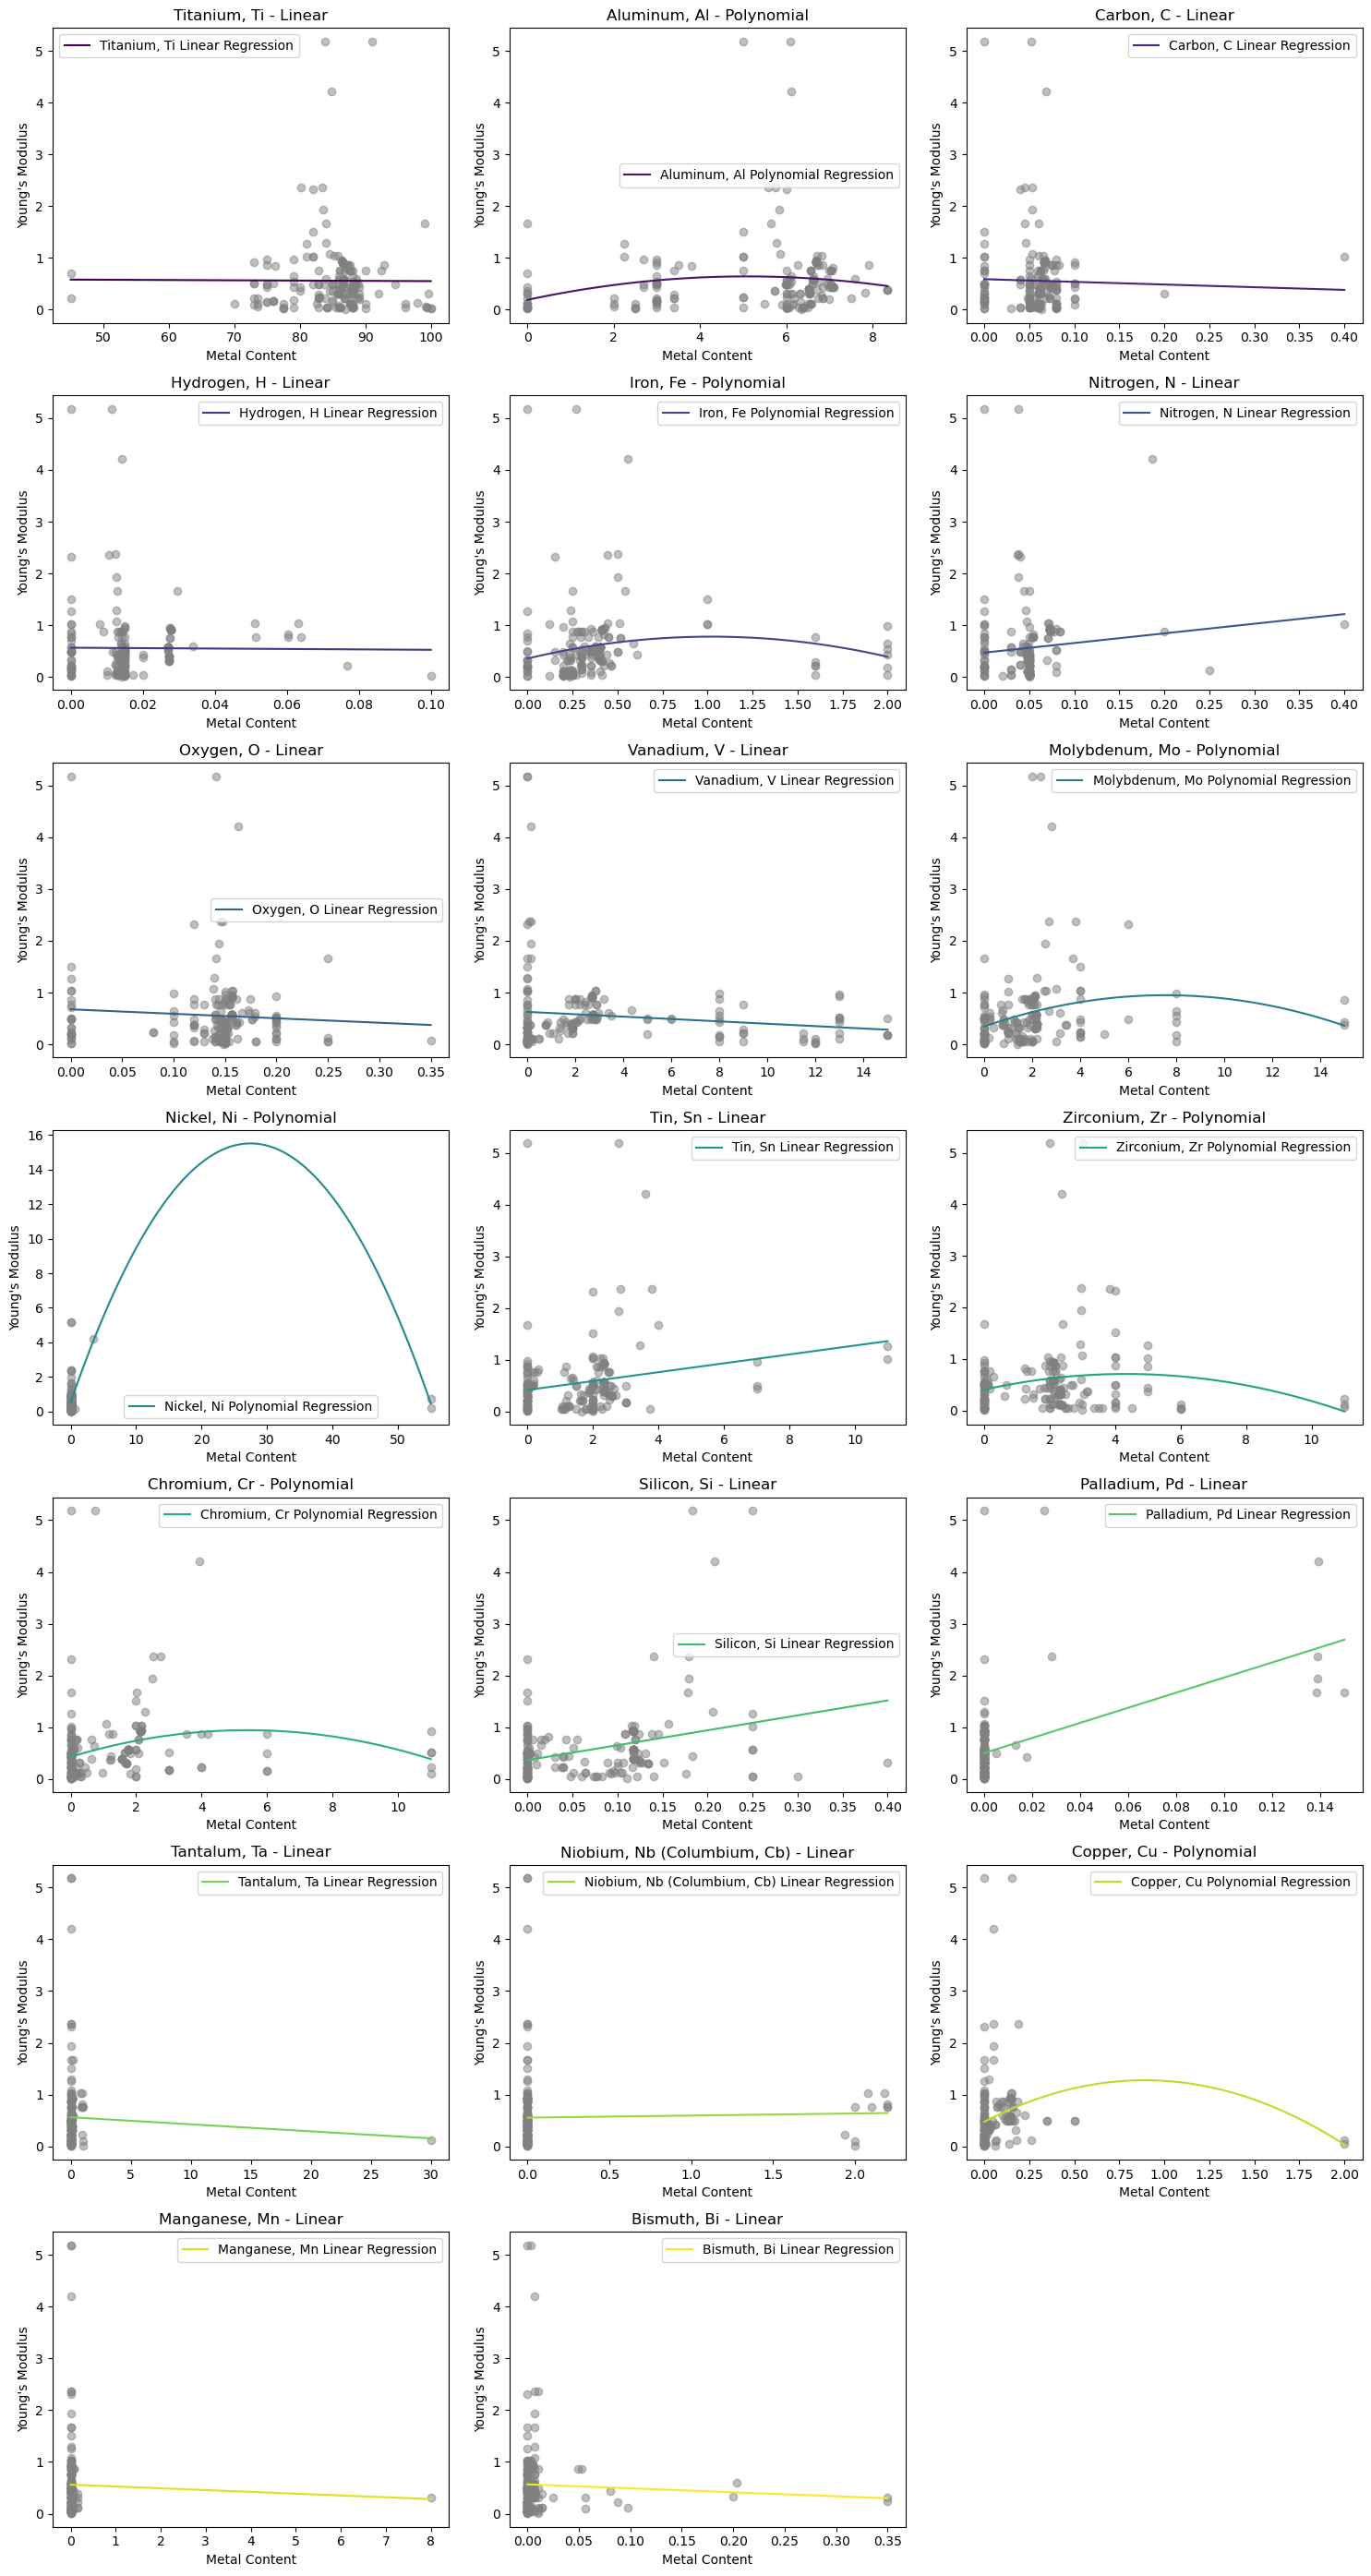

In [19]:
metals = ['Titanium, Ti', 'Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']

models = {}
linear_vs_poly = {}
impact_summary = pd.DataFrame(columns=['Metal', 'Coefficient', 'Effect'])

for metal in metals:
    
    if metals_and_modulus[metal].max() < 0.1:
        continue  # Skip metals where the maximum content is less than 0.01
        
    # Check if the maximum metal content is <= 1 to decide the model type
    if metals_and_modulus[metal].max() <= 1:
        model = evaluate_feature(metals_and_modulus, metal, "Young's Modulus", 1)
        linear_vs_poly[metal] = 'Linear'
    else:
        linear_model = evaluate_feature(metals_and_modulus, metal, "Young's Modulus", 1)
        poly_model = evaluate_feature(metals_and_modulus, metal, "Young's Modulus", 2)
        
        if linear_model.aic < poly_model.aic:
            model = linear_model
            linear_vs_poly[metal] = 'Linear'
        else:
            model = poly_model
            linear_vs_poly[metal] = 'Polynomial'
    
    models[metal] = model
    coeff = model.params[1 if linear_vs_poly[metal] == 'Linear' else 2]
    effect = 'Increases' if coeff > 0 else 'Decreases'

    new_row = pd.DataFrame({'Metal': [metal], 'Coefficient': [coeff], 'Effect': [effect]})
    impact_summary = pd.concat([impact_summary, new_row], ignore_index=True)

print(impact_summary)
# Visualization setup and plotting
cols=3
cols, rows = 3, (len(models) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()
for idx, metal in enumerate(models):
    ax = axes[idx]
    model = models[metal]
    X = np.linspace(metals_and_modulus[metal].min(), metals_and_modulus[metal].max(), 100).reshape(-1, 1)
    preds = model.predict(sm.add_constant(PolynomialFeatures(1 if linear_vs_poly[metal] == 'Linear' else 2).fit_transform(X)))
    ax.plot(X.flatten(), preds, label=f'{metal} {linear_vs_poly[metal]} Regression', color=plt.cm.viridis(np.linspace(0, 1, len(models)))[idx])
    ax.scatter(metals_and_modulus[metal], metals_and_modulus["Young's Modulus"], color='gray', alpha=0.5)
    ax.set(title=f'{metal} - {linear_vs_poly[metal]}', xlabel='Metal Content', ylabel="Young's Modulus")
    ax.legend()

# Turn off axes for any empty subplots
for i in range(idx + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [20]:
# Splitting the DataFrame into positive and negative subsets
positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()

# Sorting each subset
positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value

# Concatenating back into a single DataFrame
sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)

# Define colors based on coefficient sign and set edge colors for better visibility
colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]

# Set up the plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
plt.xlabel('Coefficient Value')
plt.title('Impact of Each Metal on Young\'s Modulus')

# Invert y-axis to have the largest impact at the top
plt.gca().invert_yaxis()

# Add text labels to bars for exact coefficient values
for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
             ha='right' if value < 0 else 'left')

# Show the plot
plt.show()

# Optionally, print the DataFrame for a tabular view
print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

                          Metal  Coefficient     Effect
14                Palladium, Pd    14.589254  Increases
13                  Silicon, Si     2.881558  Increases
5                   Nitrogen, N     1.861082  Increases
10                      Tin, Sn     0.085739  Increases
16  Niobium, Nb (Columbium, Cb)     0.040214  Increases
0                  Titanium, Ti    -0.000540  Decreases
8                Molybdenum, Mo    -0.010593  Decreases
15                 Tantalum, Ta    -0.013604  Decreases
11                Zirconium, Zr    -0.016292  Decreases
1                  Aluminum, Al    -0.017522  Decreases
12                 Chromium, Cr    -0.017754  Decreases
9                    Nickel, Ni    -0.019847  Decreases
7                   Vanadium, V    -0.022952  Decreases
18                Manganese, Mn    -0.034727  Decreases
3                   Hydrogen, H    -0.405479  Decreases
4                      Iron, Fe    -0.405579  Decreases
2                     Carbon, C    -0.516533  De

### <span style="color:lime">Optimizing Youngs Modulus</span>

#### <span style="color:red">Random Forest</span>

In [21]:
selected_features = ['Titanium, Ti', 'Silicon, Si', 'Iron, Fe', 'Nickel, Ni', 'Aluminum, Al', 'Molybdenum, Mo', 'Tin, Sn', 'Vanadium, V', 'Chromium, Cr', 'Zirconium, Zr']
target_variable = 'Young\'s Modulus'

# Split the data into training and testing sets
X = df[selected_features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting the Young's Modulus using the trained model
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Find the maximum predicted Young's Modulus
max_youngs_modulus = max(y_pred)

mse, rmse, max_youngs_modulus

(0.1375354971559095, 0.3708577856212668, 1.3099949149619479)

In [22]:
# Finding the index of the maximum predicted Young's Modulus
index_max_modulus = y_pred.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test.iloc[index_max_modulus]

strongest_composition

Titanium, Ti      80.13562
Silicon, Si        0.14070
Iron, Fe           0.44510
Nickel, Ni         0.00000
Aluminum, Al       5.58100
Molybdenum, Mo     3.81950
Tin, Sn            2.83400
Vanadium, V        0.05000
Chromium, Cr       2.75000
Zirconium, Zr      3.83700
Name: 175, dtype: float64

In [23]:
# Filtering the dataset to ensure Aluminum content is between 75% and 100%
filtered_data = df[(df['Titanium, Ti'] >= 75) & (df['Titanium, Ti'] <= 100)]

# Split the filtered data into training and testing sets
X_filtered = filtered_data[selected_features]
y_filtered = filtered_data[target_variable]
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor on the filtered data
rf_model_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_filtered.fit(X_train_filtered, y_train_filtered)

# Predicting the Young's Modulus using the trained model on filtered data
y_pred_filtered = rf_model_filtered.predict(X_test_filtered)

# Evaluate the model on filtered data
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
rmse_filtered = mse_filtered ** 0.5

# Find the maximum predicted Young's Modulus on filtered data
max_youngs_modulus_filtered = max(y_pred_filtered)

mse_filtered, rmse_filtered, max_youngs_modulus_filtered


(0.6661194760394802, 0.8161614276841808, 1.6701045781535955)

In [24]:
# Finding the index of the maximum predicted Young's Modulus
index_max_modulus = y_pred_filtered.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test_filtered.iloc[index_max_modulus]

strongest_composition

Titanium, Ti      84.0190
Silicon, Si        0.2054
Iron, Fe           0.2381
Nickel, Ni         0.0000
Aluminum, Al       5.7700
Molybdenum, Mo     2.2035
Tin, Sn            3.4280
Vanadium, V        0.0000
Chromium, Cr       2.2700
Zirconium, Zr      2.9190
Name: 166, dtype: float64

In [25]:
# File path for the output CSV
output_file_path = "Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_modulus.csv"

# Check if the output file already exists
if os.path.exists(output_file_path):
    # Read the existing results
    hypothetical_results = pd.read_csv(output_file_path)
    print("Loaded results from existing file.")
else:
    # Define the increments for Aluminum and the other metals
    al_increments = np.arange(75, 101, 5)  # Correct range for Aluminum from 75% to 100%
    other_increments = np.arange(0, 26, 5)  # Other metals must sum up to fill the remaining percentage
    metals = ['Silicon, Si', 'Iron, Fe', 'Nickel, Ni', 'Aluminum, Al', 'Molybdenum, Mo', 'Tin, Sn', 'Vanadium, V', 'Chromium, Cr', 'Zirconium, Zr']
    
    # Generate all valid combinations where the total percentage is 100
    valid_combinations = []
    for al_percent in al_increments:
        for combo in product(other_increments, repeat=len(metals)):
            if sum(combo) == (100 - al_percent):  # Ensure the total sum with Aluminum is 100%
                valid_combinations.append((al_percent,) + combo)
    
    # Convert the list of combinations into a DataFrame
    hypothetical_metals_df = pd.DataFrame(valid_combinations, columns=['Titanium, Ti'] + metals)
    
    # Assuming rf_model is already trained and available
    # Predict Young's Modulus for these hypothetical alloys
    hypothetical_youngs_modulus = rf_model.predict(hypothetical_metals_df)
    
    # Combining the compositions and their predicted Young's Modulus
    hypothetical_results = hypothetical_metals_df.copy()
    hypothetical_results['Predicted Young\'s Modulus'] = hypothetical_youngs_modulus
    
    # Save all combinations and their predicted Young's Modulus to a CSV file
    hypothetical_results.to_csv("Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_modulus.csv", index=False)
    print("Predictions performed and results saved.")
    
    # Find the top 10 combinations with the highest predicted Young's Modulus
top_10_modulus_combinations = hypothetical_results.nlargest(10, 'Predicted Young\'s Modulus')
    
# Print the top 10 combinations
print("Top 10 Young's Modulus Combinations:")
print(top_10_modulus_combinations.head(10))  # Print only the top 5 of these top 10

Loaded results from existing file.
Top 10 Young's Modulus Combinations:
      Titanium, Ti  Silicon, Si  Iron, Fe  Nickel, Ni  Aluminum, Al  \
858             75            5         0           0             0   
857             75            5         0           0             0   
859             75            5         0           0             0   
861             75            5         0           0             0   
952             75            5         0           5             0   
1156            75           10         0           0             0   
860             75            5         0           0             0   
848             75            5         0           0             0   
851             75            5         0           0             0   
949             75            5         0           5             0   

      Molybdenum, Mo  Tin, Sn  Vanadium, V  Chromium, Cr  Zirconium, Zr  \
858               15        0            0             5              0

#### <span style="color:red">MLP</span>

In [26]:
# Assuming metals_and_modulus is preloaded with the relevant data
X = metals_and_modulus[['Titanium, Ti', 'Silicon, Si', 'Iron, Fe', 'Nickel, Ni', 'Aluminum, Al', 'Molybdenum, Mo', 'Tin, Sn', 'Vanadium, V', 'Chromium, Cr', 'Zirconium, Zr']]
y = metals_and_modulus["Young's Modulus"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [2000, 3000, 4000]

# Path for the grid search results CSV
results_csv_path = 'Ti_model_data/grid_search_titanium_modulus_results.csv'

# Check if results already exist
if os.path.exists(results_csv_path):
    # Load and print the existing results
    results_df = pd.read_csv(results_csv_path)
    # Finding the best configuration with the lowest MSE
    best_row = results_df.loc[results_df['MSE'].idxmin()]
    best_layers = ast.literal_eval(best_row['Layers'])  # Convert string back to tuple if stored as string
    best_max_iter = best_row['Max_iter']
    best_mse = best_row['MSE']
    print(f"Best Configuration: Layers={best_layers}, Max_iter={best_max_iter}, Best MSE={best_mse}")
    print("Loaded results from existing file:")
    print(results_df)
else:
    # Initialize a list to store results
    results = []
    best_mse = float('inf')
    best_configuration = None

    # Grid search over layer configurations and max_iter_options
    for layers in layer_configurations:
        for max_iter in max_iter_options:
            base_nn = MLPRegressor(hidden_layer_sizes=layers, activation='relu', solver='adam', max_iter=max_iter)
            bagging_model = BaggingRegressor(base_nn, n_estimators=10, random_state=42)
            bagging_model.fit(X_train, y_train)

            y_pred = bagging_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            # Save each configuration's MSE
            results.append({'Layers': layers, 'Max_iter': max_iter, 'MSE': mse})

            if mse < best_mse:
                best_mse = mse
                best_layers = layers
                best_max_iter = max_iter

            print(f"Configuration: Layers={layers}, Max_iter={max_iter}, MSE={mse}")

    print(f"Best Configuration: Layers={best_layers}, Max_iter={max_iter}, Best MSE={best_mse}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(results_csv_path, index=False)
    print("Grid search results saved to 'grid_search_results.csv'.")

Best Configuration: Layers=(8, 8), Max_iter=2000, Best MSE=0.3910923739634257
Loaded results from existing file:
          Layers  Max_iter       MSE
0     (30, 3, 1)      2000  1.536491
1     (30, 3, 1)      3000  1.536491
2     (30, 3, 1)      4000  1.536491
3        (40, 2)      2000  0.612773
4        (40, 2)      3000  0.597132
..           ...       ...       ...
76     (2, 2, 2)      3000  0.604583
77     (2, 2, 2)      4000  0.604583
78  (2, 2, 2, 2)      2000  0.621468
79  (2, 2, 2, 2)      3000  0.621468
80  (2, 2, 2, 2)      4000  0.621468

[81 rows x 3 columns]


/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.20714050550006452


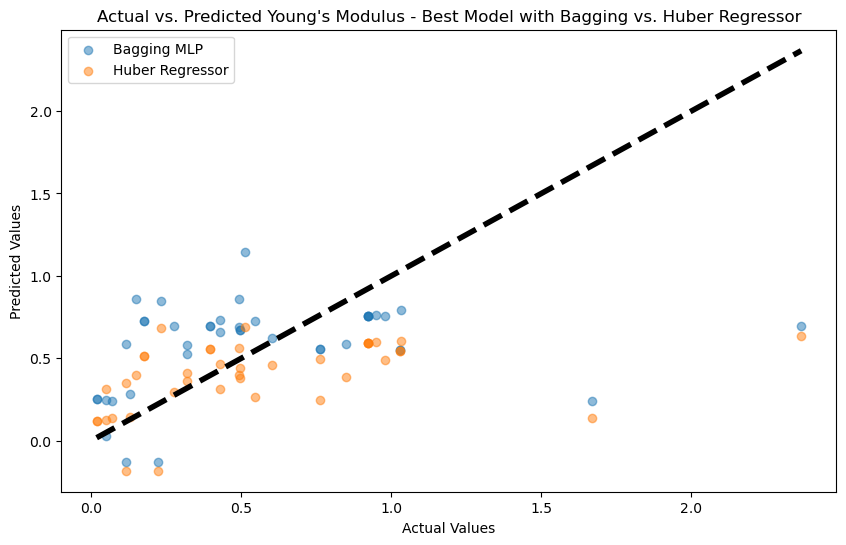

In [27]:
# Retrain the best model with Bagging
best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
best_bagging_model.fit(X_train, y_train)
best_preds = best_bagging_model.predict(X_test)

# Initialize the Huber Regressor
huber_reg = HuberRegressor()

# Fit the model
huber_reg.fit(X_train, y_train)

# Make predictions
y_pred_huber = huber_reg.predict(X_test)

# Calculate Mean Squared Error for Huber Regressor
mse_huber = mean_squared_error(y_test, y_pred_huber)
print(f"Mean Squared Error - Huber Regressor: {mse_huber}")


# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_preds, alpha=0.5, label='Bagging MLP')
plt.scatter(y_test, y_pred_huber, alpha=0.5, label='Huber Regressor')
plt.title('Actual vs. Predicted Young\'s Modulus - Best Model with Bagging vs. Huber Regressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.legend()
plt.show()

In [28]:
def evaluate_rank_correlation(actuals, preds):
    """
    Computes the Spearman's rank correlation coefficient between actual and predicted values.

    Parameters:
    - actuals (np.array): Array of actual values.
    - preds (np.array): Array of predicted values.

    Returns:
    - float: Spearman's rank correlation coefficient.
    """
    # Calculate Spearman's rank correlation
    correlation, p_value = spearmanr(actuals, preds)

    print("Spearman's rank correlation coefficient:", correlation)
    print("P-value of the correlation coefficient:", p_value)

    return correlation

In [29]:
def plot_rank_correlation(actuals, preds):
    """
    Plots a scatter plot of actual vs. predicted values and calculates Spearman's rank correlation.

    Parameters:
    - actuals (np.array): Array of actual values.
    - preds (np.array): Array of predicted values.
    """
    # Calculate Spearman's rank correlation
    correlation, _ = spearmanr(actuals, preds)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actuals, y=preds, color='blue', edgecolor='w', s=100, alpha=0.7)

    # Plot a 45-degree line
    max_val = max(actuals.max(), preds.max())
    min_val = min(actuals.min(), preds.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction Line')

    # Optional: add a regression line
    sns.regplot(x=actuals, y=preds, scatter=False, color='red', label='Regression Line')
    
    plt.title(f'Scatter Plot of Actual vs. Predicted with Spearman Correlation: {correlation:.2f}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

Spearman's rank correlation coefficient: 0.37532717374722524
P-value of the correlation coefficient: 0.015602537196023914


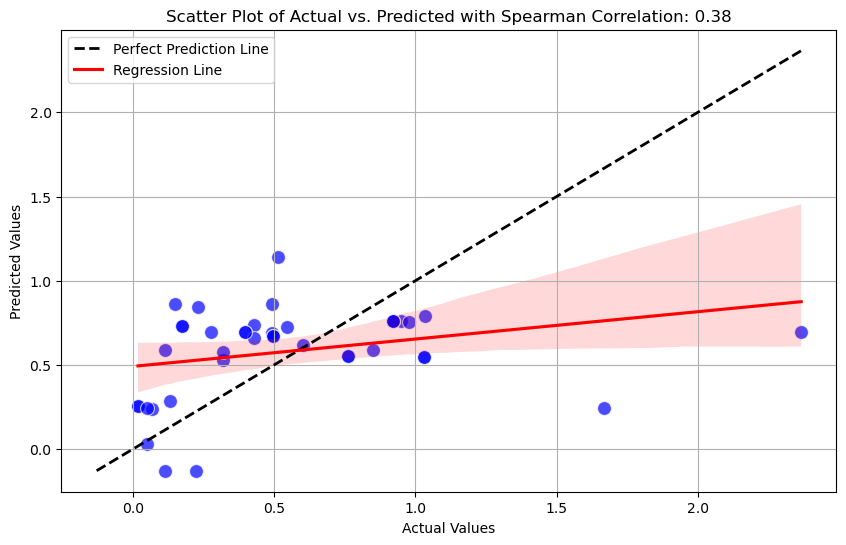

Spearman's rank correlation coefficient: 0.5808759467245527
P-value of the correlation coefficient: 6.837351787244232e-05


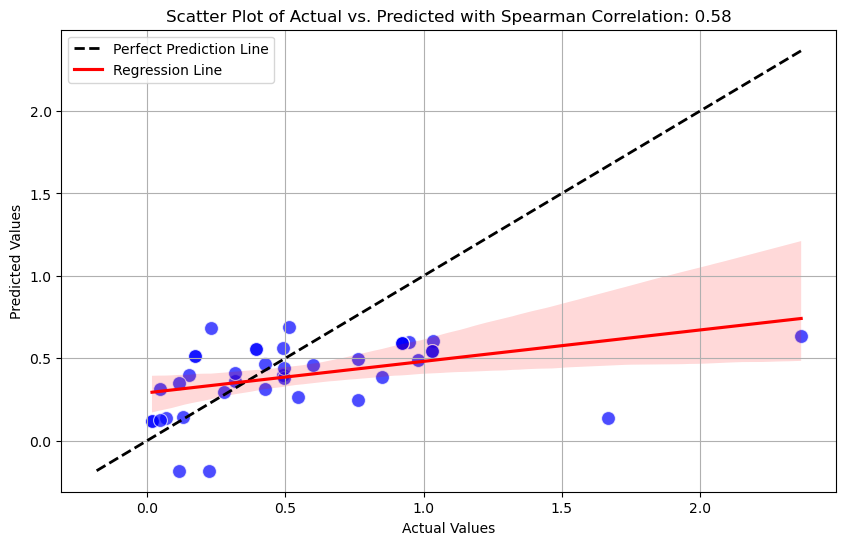

In [30]:
actuals = y_test  # Your array of actual Young's moduli
preds = best_preds   # Your array of predicted Young's moduli

rank_correlation = evaluate_rank_correlation(actuals, preds)


plot_rank_correlation(actuals, preds)

rank_correlation = evaluate_rank_correlation(actuals, y_pred_huber)
plot_rank_correlation(actuals, y_pred_huber)

In [31]:
def objective_function(composition):
    # Convert the composition list to a DataFrame with appropriate column names
    composition_df = pd.DataFrame([composition], columns=X_train.columns)
    
    # Predict the Young's modulus for the given composition
    predicted_modulus = best_bagging_model.predict(composition_df).flatten()[0]
    
    # Calculate the diversity penalty as the variance of component proportions, excluding the first
    diversity_penalty = np.sum((np.array(composition[1:]) - np.mean(composition[1:]))**2)
    
    # Calculate the final adjusted score (negative for maximization in minimize function)
    adjusted_score = predicted_modulus

    # Return the negated adjusted score
    return -adjusted_score

In [32]:
bounds = [(75, 100)] + [(0, 100) for _ in range(1, len(X_train.columns))]
cons = ({'type': 'eq', 'fun': lambda x: 100 - np.sum(x)})

results = []
best_score = -np.inf  # Assuming maximization
best_composition = None

for i in range(100):
    # Generate initial random composition
    initial_composition_random = [75] + [np.random.rand() * 25 for _ in range(1, len(X_train.columns))]
    initial_composition_random = np.array(initial_composition_random)
    initial_composition_random *= 100 / np.sum(initial_composition_random)  # Normalize to sum to 100%

    # Perform the minimization
    result = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=cons, 
        options={'disp': True, 'maxiter': 1000}
    )

    if result.success:
        adjusted_score = -result.fun  # Convert back since we minimize the negative in objective_function
        results.append((result.x, adjusted_score))
        if adjusted_score > best_score:
            best_score = adjusted_score
            best_composition = result.x

# Output the best result found
print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

# Save results
results_path = 'Ti_model_data/modulus_optimization_results.csv'
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists

with open(results_path, 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.2947163905728885
            Iterations: 16
            Function evaluations: 199
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.348586316867954
            Iterations: 28
            Function evaluations: 320
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.2517077515165367
            Iterations: 19
            Function evaluations: 227
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.3485848759882733
            Iterations: 35
            Function evaluations: 399
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.3485864822174434
            Iterations: 26
            Func

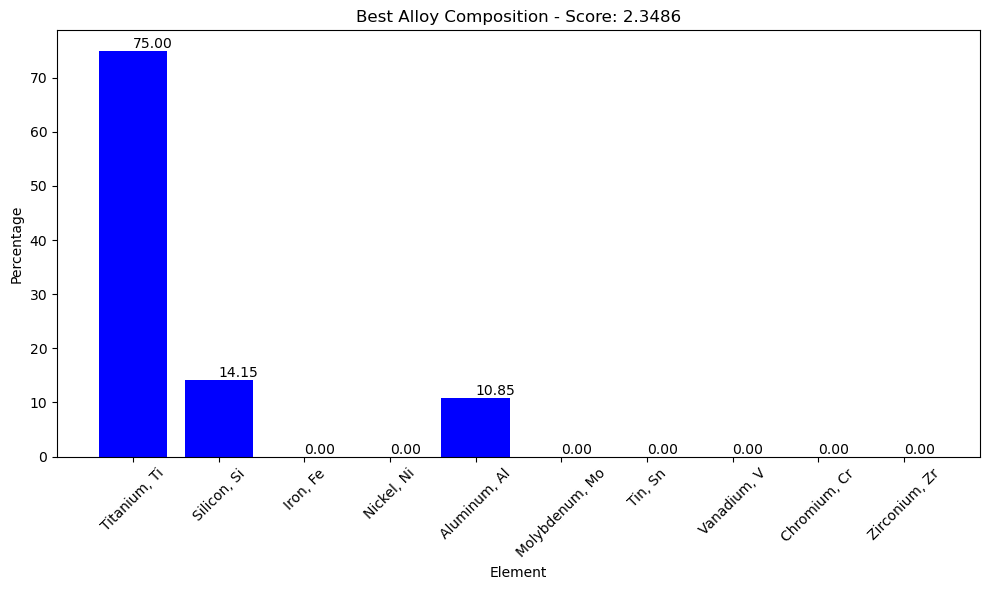

In [33]:
# Assuming we already have the best alloy and its score from the earlier setup
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

# Plot the best alloy composition along with its score
plt.figure(figsize=(10, 6))
bars = plt.bar(selected_features, best_alloy, color='blue')
plt.xlabel('Element')
plt.ylabel('Percentage')
plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
plt.xticks(rotation=45)

# Add the score to each bar in the graph
for bar, percentage in zip(bars, best_alloy):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')  # for composition percentage

plt.tight_layout()
plt.savefig('best_alloy_composition_with_score.png')
plt.show()


## Yield Strength

### Data Preperation

In [34]:
# Assuming df is your DataFrame and it contains the columns 'Yield Strength' and 'Density'
df['Yield Strength'] = df['Yield Strength'].apply(extract_numeric)

# List all columns to keep (metal percentages and Yield Strength)
columns_to_keep = ['Yield Strength'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_yield = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_yield.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_yield.head()

(Series([], dtype: int64),
    Yield Strength  Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  \
 0        0.003330           3.4       0.05        0.015      1.60   
 1        0.237168           3.0       0.05        0.015      2.00   
 2        0.075479           0.0       0.00        0.020      0.35   
 3        0.228797           2.7       0.08        0.015      0.20   
 4        0.718165           3.0       0.00        0.000      0.00   
 
    Nitrogen, N  Oxygen, O  Titanium, Ti  Vanadium, V  Molybdenum, Mo  ...  \
 0         0.05       0.13        82.855          9.0             0.0  ...   
 1         0.00       0.10        79.000          8.0             8.0  ...   
 2         0.05       0.20        80.000          0.0            15.0  ...   
 3         0.05       0.15        75.000         13.0             0.0  ...   
 4         0.00       0.00        94.500          2.5             0.0  ...   
 
    Yttrium, Y  Zirconium, Zr  Chromium, Cr  Silicon, Si  Palladium, Pd  \
 0    

In [35]:
# Splitting the dataset into features and target variable
X = metals_and_yield.drop('Yield Strength', axis=1)
y = metals_and_yield['Yield Strength']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  Nitrogen, N  Oxygen, O  \
 198       6.83600   0.082900     0.013490  0.362700     0.074200   0.161000   
 38        7.82150   0.069100     0.014880  0.290000     0.050000   0.142800   
 24        6.29600   0.060000     0.013730  0.232400     0.050000   0.150400   
 122       6.68391   0.067627     0.027655  0.430395     0.073237   0.156627   
 196       6.10700   0.067300     0.014965  0.366200     0.047500   0.179000   
 
      Titanium, Ti  Vanadium, V  Molybdenum, Mo  Nickel, Ni  ...  Yttrium, Y  \
 198     87.075290       2.1800         1.80850         0.0  ...         0.0   
 38      86.366270       1.3350         1.07850         0.0  ...         0.0   
 24      87.983030       0.0000         1.52300         0.0  ...         0.0   
 122     86.415666       2.6961         2.13013         0.0  ...         0.0   
 196     88.600010       2.8975         0.24250         0.0  ...         0.0   
 
      Zirconium, Zr  Chromium, Cr  S

### Feature Selection

#### Random Forest Feature Importance

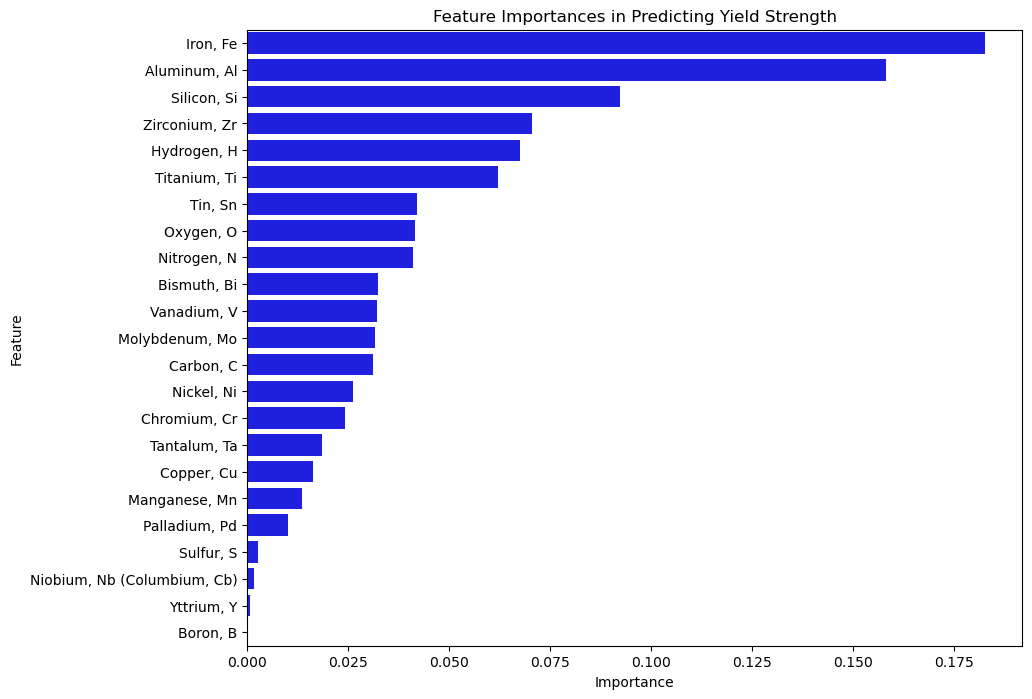

In [36]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)

# Get feature importances from the Random Forest model
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization of feature importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

rf_mse, features_importance_df

features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# Use seaborn to plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_importance_df, color='blue')
plt.title('Feature Importances in Predicting Yield Strength')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Combination Neural Network Feature Combination Importance

Processing new combinations...
Processing combination: ('Aluminum, Al', 'Chromium, Cr', 'Titanium, Ti')
Processing combination: ('Aluminum, Al', 'Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Aluminum, Al', 'Silicon, Si', 'Titanium, Ti')
Processing combination: ('Aluminum, Al', 'Iron, Fe', 'Titanium, Ti')
Processing combination: ('Aluminum, Al', 'Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Aluminum, Al', 'Oxygen, O', 'Titanium, Ti')
Processing combination: ('Aluminum, Al', 'Carbon, C', 'Titanium, Ti')
Processing combination: ('Aluminum, Al', 'Tin, Sn', 'Titanium, Ti')
Processing combination: ('Aluminum, Al', 'Zirconium, Zr', 'Titanium, Ti')
Processing combination: ('Chromium, Cr', 'Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Chromium, Cr', 'Silicon, Si', 'Titanium, Ti')
Processing combination: ('Chromium, Cr', 'Iron, Fe', 'Titanium, Ti')
Processing combination: ('Chromium, Cr', 'Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Chromium, Cr

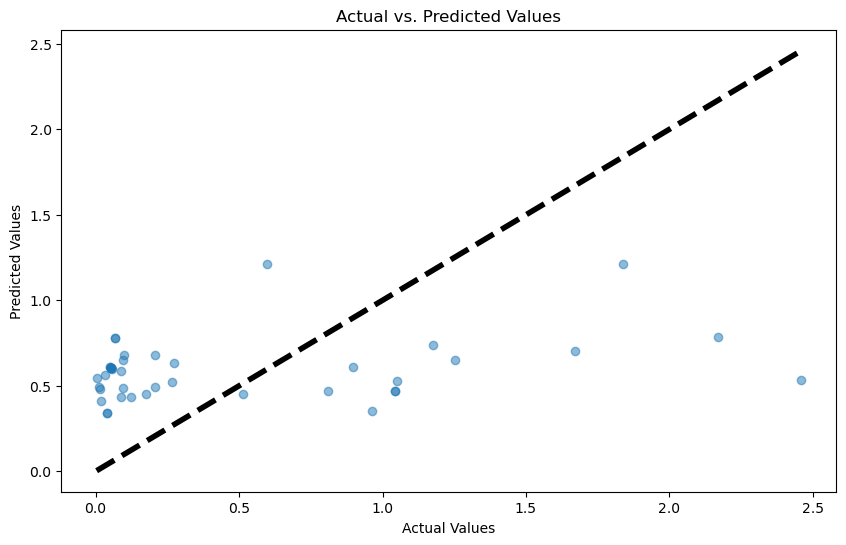

In [37]:
# Assuming 'metals_and_yield' is a DataFrame containing the required data
# If not, you need to load or define this DataFrame.

top_features = ['Aluminum, Al', 'Chromium, Cr', 'Molybdenum, Mo', 'Silicon, Si', 'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Carbon, C', 'Tin, Sn', 'Zirconium, Zr']
fixed_feature = 'Titanium, Ti'

# Ensure the DataFrame contains these columns before proceeding
if not set(top_features + [fixed_feature]).issubset(metals_and_yield.columns):
    raise ValueError("DataFrame does not contain all required features.")

X = metals_and_yield[top_features + [fixed_feature]]
y = metals_and_yield["Yield Strength"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_3_features_yield.csv'

if os.path.exists(file_path):
    print("Loading existing results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(ast.literal_eval)
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("Processing new combinations...")
    mse_scores = {}
    full_combinations = [combo + (fixed_feature,) for combo in combinations(top_features, 2)]
    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=len(combo), activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame([(combo, mse) for combo, mse in mse_scores.items()], columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    best_combination = min(mse_scores, key=mse_scores.get)

# Neural network training with the best combination found or loaded
nn_model = Sequential([
    Dense(3, input_dim=len(best_combination), activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()


No results file found. Processing new combinations...
Processing combination: ('Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Carbon, C', 'Titanium, Ti')
Processing combination: ('Hydrogen, H', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Titanium, Ti')
Processing combination: ('Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Titanium, Ti')
Processing combination: ('Vanadium, V', 'Titanium, Ti')
Processing combination: ('Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Titanium, Ti')
Processing combination: ('Sulfur, S', 'Titanium, Ti')
Processing combination: ('Boron, B', 'Titanium, Ti')
Processing combination: ('Tin, Sn', 'Titanium, Ti')
Processing combination: ('Yttrium, Y', 'Titanium, Ti')
Processing combination: ('Zirconium, Zr', 'Titanium, Ti')
Processing combination: ('Chromium, Cr', 'Titanium, Ti')
Processing combination: ('Silicon, Si', 'Titanium, Ti')
Processing combination: ('Palladium, Pd', 'Titanium, Ti')
Pro

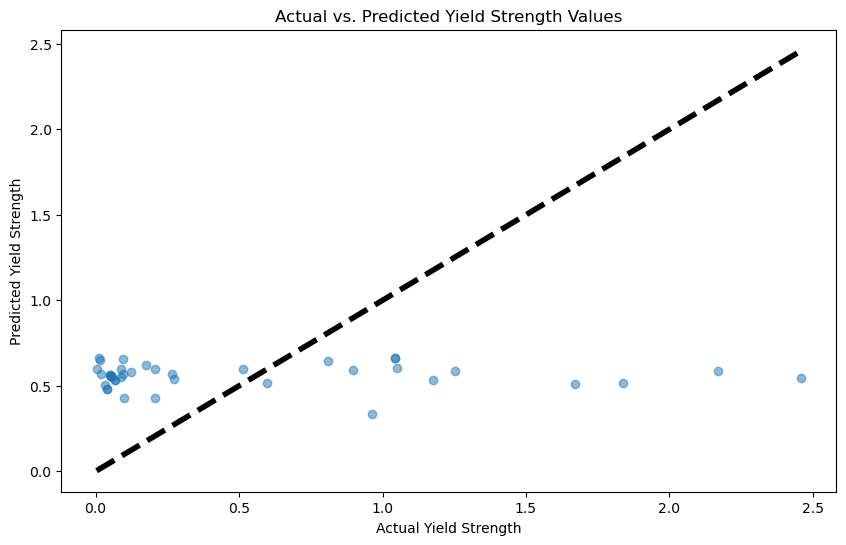

In [38]:
# If not already imported, this is necessary for converting string to tuple

# Assuming metals_and_yield is preloaded with the relevant data, rename it appropriately if it contains yield strength
top_features = ['Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']
fixed_feature = 'Titanium, Ti'

# Exclude fixed feature if it's accidentally included in top_features
top_features = [feat for feat in top_features if feat != fixed_feature]

# Assuming the DataFrame name that contains 'Yield Strength'
X = metals_and_yield[top_features + [fixed_feature]]
y = metals_and_yield["Yield Strength"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_2_features_yield.csv'

# Load or process data
if os.path.exists(file_path):
    print("Results file already exists. Loading results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(lambda x: ast.literal_eval(x))
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("No results file found. Processing new combinations...")
    full_combinations = [(feat, fixed_feature) for feat in top_features]
    mse_scores = {}

    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=2, activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    print("Results saved to", file_path)
    best_combination = tuple(results_df.loc[results_df['MSE'].idxmin(), 'Combination'])

print(f"Best combination including Aluminum: {best_combination}, MSE: {results_df['MSE'].min()}")

# Define and train the neural network with the best combination
nn_model = Sequential([
    Dense(3, input_dim=2, activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)

y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Yield Strength Values')
plt.xlabel('Actual Yield Strength')
plt.ylabel('Predicted Yield Strength')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

#### Correlation Matrix

Palladium, Pd                  0.477824
Silicon, Si                    0.318074
Tin, Sn                        0.200058
Molybdenum, Mo                 0.135609
Aluminum, Al                   0.131664
Chromium, Cr                   0.111025
Nitrogen, N                    0.106963
Zirconium, Zr                  0.058085
Iron, Fe                       0.029831
Niobium, Nb (Columbium, Cb)    0.027073
Copper, Cu                     0.003366
Nickel, Ni                     0.002297
Titanium, Ti                  -0.005389
Hydrogen, H                   -0.008122
Sulfur, S                     -0.015554
Carbon, C                     -0.028063
Manganese, Mn                 -0.028940
Tantalum, Ta                  -0.042593
Bismuth, Bi                   -0.047004
Oxygen, O                     -0.073588
Yttrium, Y                    -0.104915
Boron, B                      -0.104915
Vanadium, V                   -0.134160
Name: Young's Modulus, dtype: float64


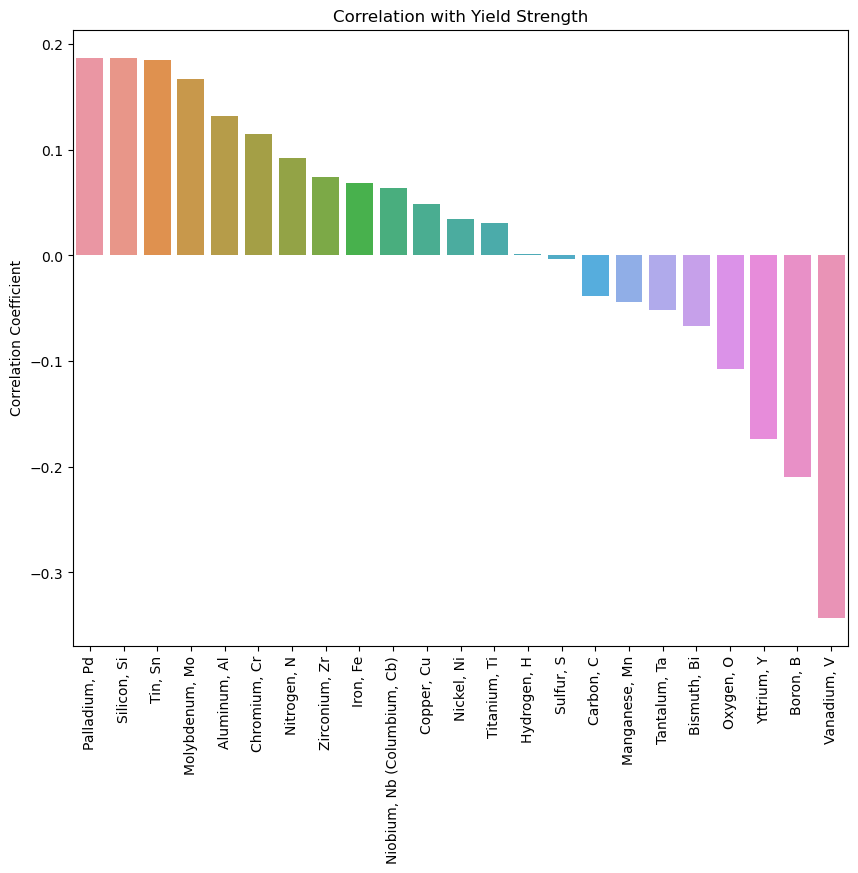

In [39]:
# Calculate correlation matrix including 'Yield Strength'
corr_matrix = metals_and_yield.corr()

# Isolate the correlation of 'Yield Strength' with other features
yield_corr = corr_matrix["Yield Strength"].drop("Yield Strength").sort_values(ascending=False)

# Print the correlation values
print(youngs_corr)

# Visualize correlations using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=youngs_corr.index, y=yield_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation with Yield Strength")
plt.ylabel("Correlation Coefficient")
plt.show()

#### Regression

                          Metal  Coefficient     Effect
0                  Titanium, Ti    -0.016074  Decreases
1                  Aluminum, Al    -0.013893  Decreases
2                     Carbon, C     1.158707  Increases
3                   Hydrogen, H    -9.650924  Decreases
4                      Iron, Fe     0.966508  Increases
5                   Nitrogen, N     0.547591  Increases
6                     Oxygen, O    -0.559897  Decreases
7                   Vanadium, V     0.011920  Increases
8                Molybdenum, Mo     0.008386  Increases
9                    Nickel, Ni    -0.009707  Decreases
10                      Tin, Sn     0.013180  Increases
11                Zirconium, Zr     0.011180  Increases
12                 Chromium, Cr     0.017798  Increases
13                  Silicon, Si     0.404781  Increases
14                Palladium, Pd     4.701568  Increases
15                 Tantalum, Ta     0.018654  Increases
16  Niobium, Nb (Columbium, Cb)    -0.091439  De

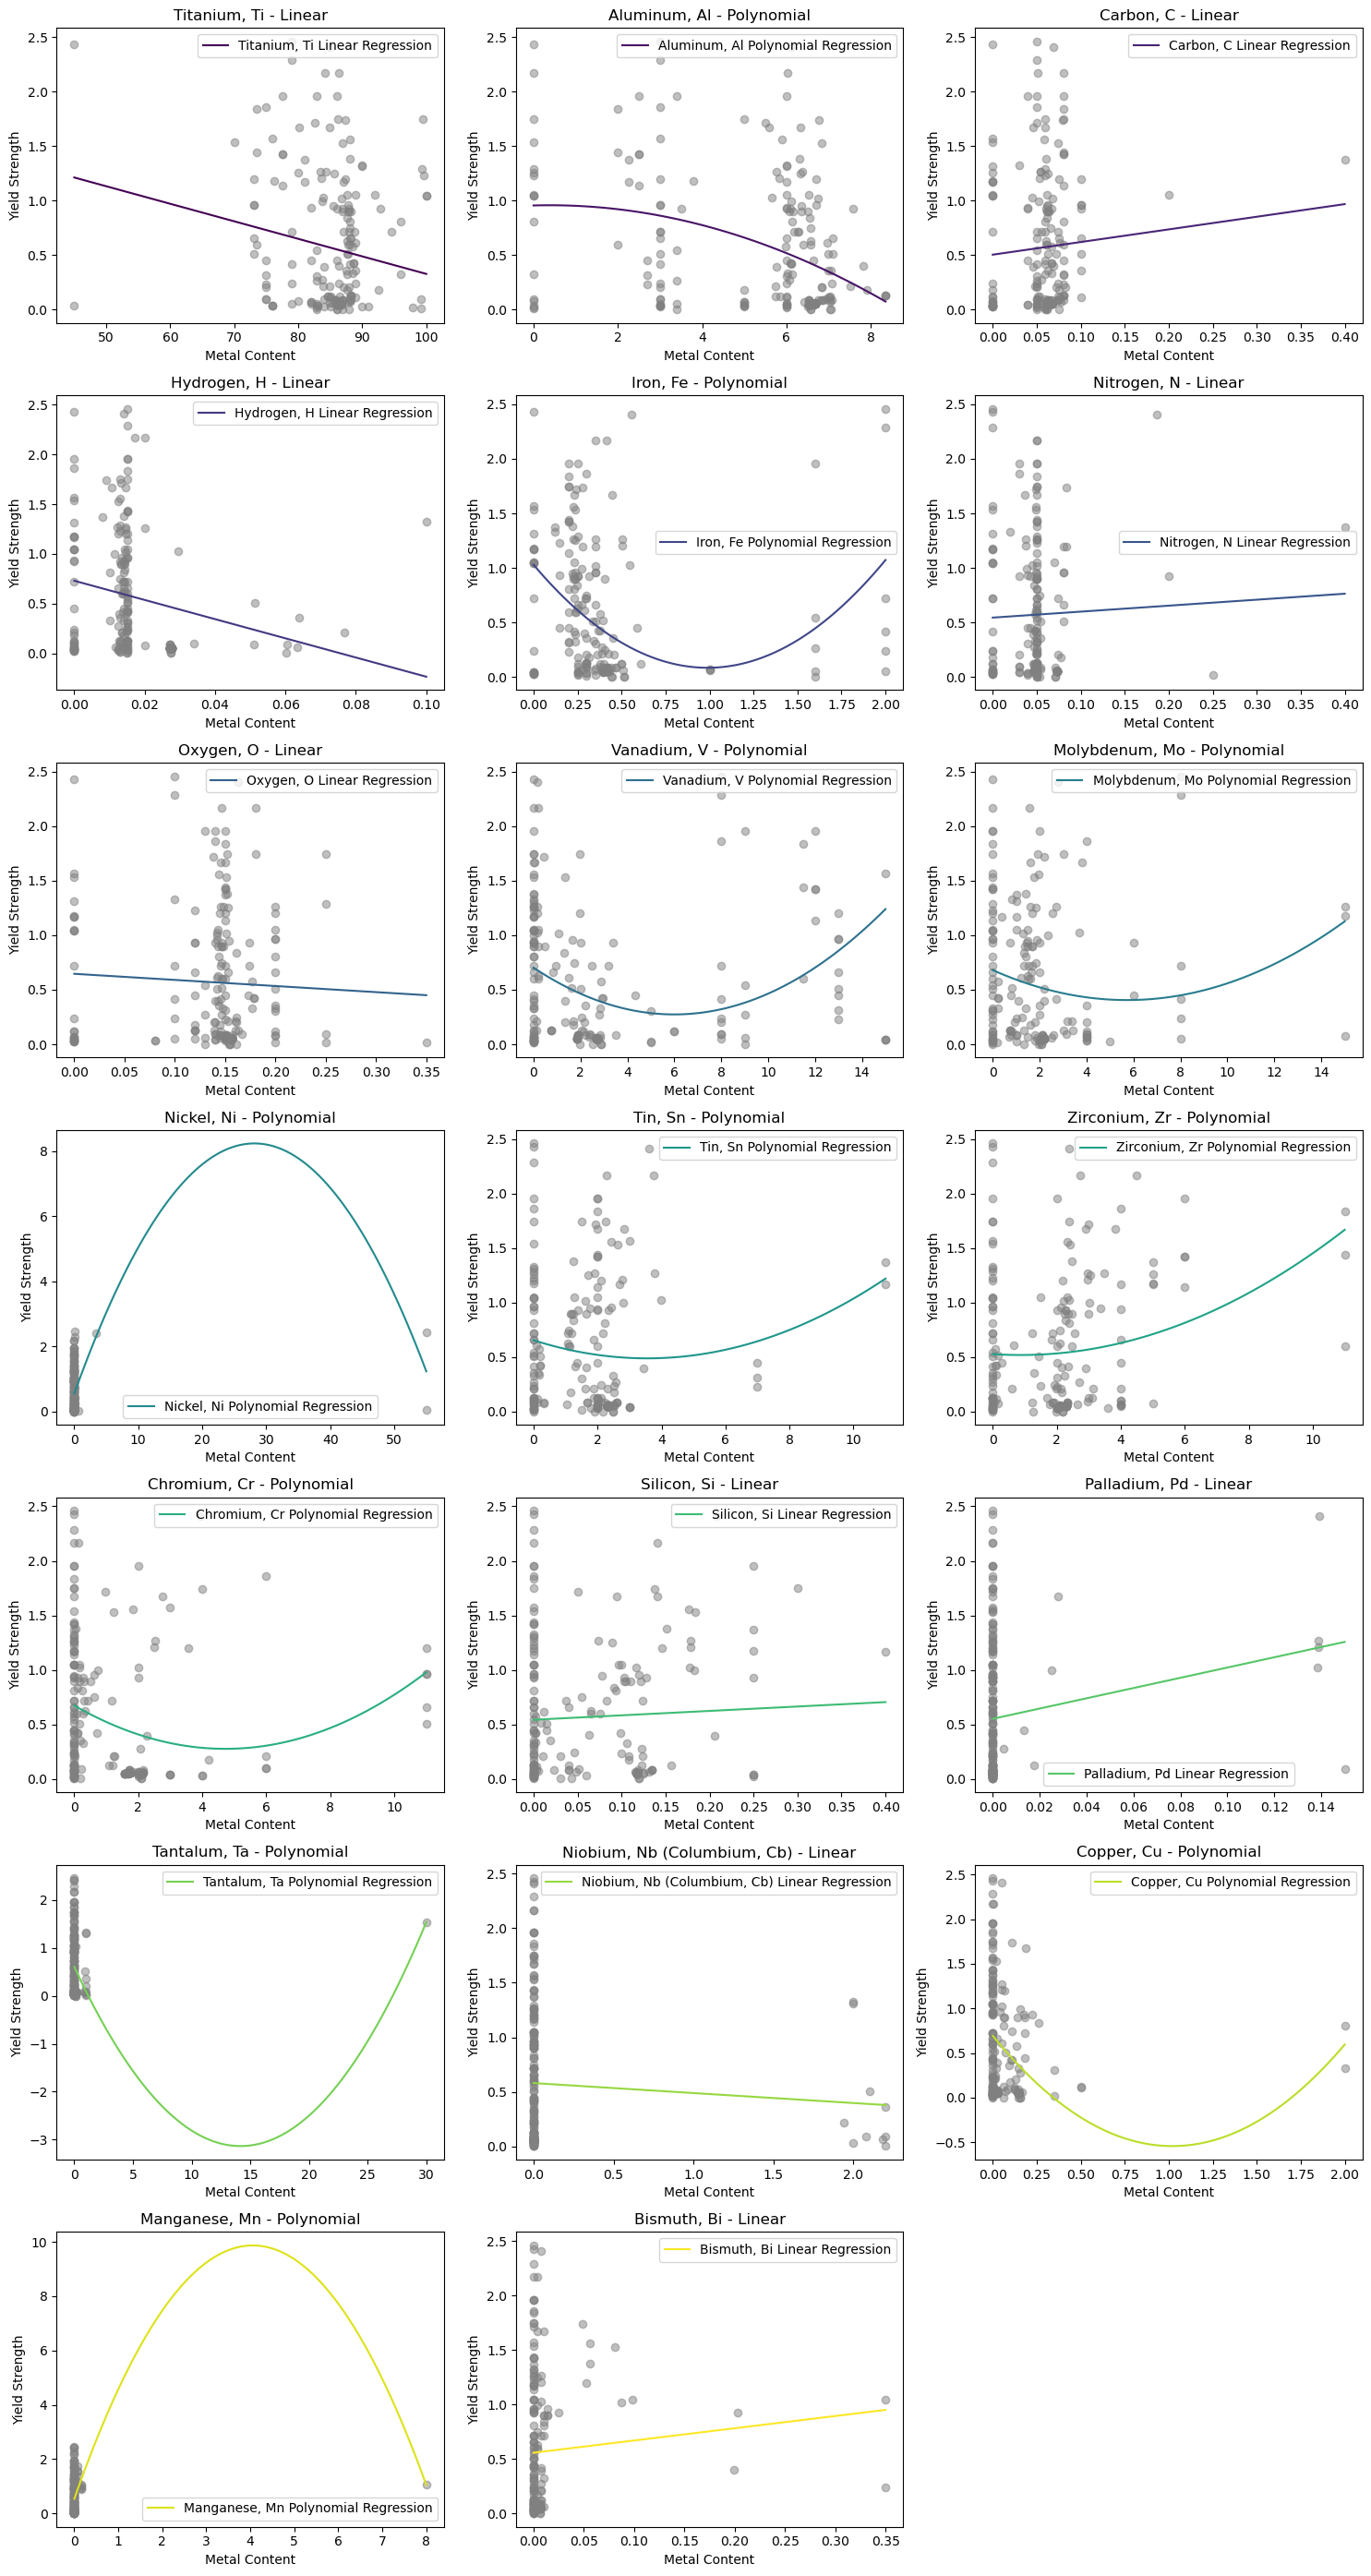

In [40]:
metals = ['Titanium, Ti', 'Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']

models = {}
linear_vs_poly = {}
impact_summary = pd.DataFrame(columns=['Metal', 'Coefficient', 'Effect'])

for metal in metals:
    # Check if the maximum metal content is <= 1 to decide the model type
    if metals_and_yield[metal].max() < 0.1:
        continue  # Skip metals where the maximum content is less than 0.01
    
    if metals_and_yield[metal].max() <= 1:
        model = evaluate_feature(metals_and_yield, metal, "Yield Strength", 1)
        linear_vs_poly[metal] = 'Linear'
    else:
        linear_model = evaluate_feature(metals_and_yield, metal, "Yield Strength", 1)
        poly_model = evaluate_feature(metals_and_yield, metal, "Yield Strength", 2)
        
        if linear_model.aic < poly_model.aic:
            model = linear_model
            linear_vs_poly[metal] = 'Linear'
        else:
            model = poly_model
            linear_vs_poly[metal] = 'Polynomial'
    
    models[metal] = model
    coeff = model.params[1 if linear_vs_poly[metal] == 'Linear' else 2]
    effect = 'Increases' if coeff > 0 else 'Decreases'

    new_row = pd.DataFrame({'Metal': [metal], 'Coefficient': [coeff], 'Effect': [effect]})
    impact_summary = pd.concat([impact_summary, new_row], ignore_index=True)

print(impact_summary)
# Visualization setup and plotting
cols, rows = 3, (len(models) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()
for idx, metal in enumerate(models):
    ax = axes[idx]
    model = models[metal]
    X = np.linspace(metals_and_yield[metal].min(), metals_and_yield[metal].max(), 100).reshape(-1, 1)
    preds = model.predict(sm.add_constant(PolynomialFeatures(1 if linear_vs_poly[metal] == 'Linear' else 2).fit_transform(X)))
    ax.plot(X.flatten(), preds, label=f'{metal} {linear_vs_poly[metal]} Regression', color=plt.cm.viridis(np.linspace(0, 1, len(models)))[idx])
    ax.scatter(metals_and_yield[metal], metals_and_yield["Yield Strength"], color='gray', alpha=0.5)
    ax.set(title=f'{metal} - {linear_vs_poly[metal]}', xlabel='Metal Content', ylabel="Yield Strength")
    ax.legend()

# Turn off axes for any empty subplots
for i in range(idx + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [41]:
# Splitting the DataFrame into positive and negative subsets
positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()

# Sorting each subset
positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value

# Concatenating back into a single DataFrame
sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)

# Define colors based on coefficient sign and set edge colors for better visibility
colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]

# Set up the plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
plt.xlabel('Coefficient Value')
plt.title('Impact of Each Metal on Yield Strength')

# Invert y-axis to have the largest impact at the top
plt.gca().invert_yaxis()

# Add text labels to bars for exact coefficient values
for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
             ha='right' if value < 0 else 'left')

# Show the plot
plt.show()

# Optionally, print the DataFrame for a tabular view
print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

                          Metal  Coefficient     Effect
14                Palladium, Pd     4.701568  Increases
17                   Copper, Cu     1.186618  Increases
2                     Carbon, C     1.158707  Increases
19                  Bismuth, Bi     1.121594  Increases
4                      Iron, Fe     0.966508  Increases
5                   Nitrogen, N     0.547591  Increases
13                  Silicon, Si     0.404781  Increases
15                 Tantalum, Ta     0.018654  Increases
12                 Chromium, Cr     0.017798  Increases
10                      Tin, Sn     0.013180  Increases
7                   Vanadium, V     0.011920  Increases
11                Zirconium, Zr     0.011180  Increases
8                Molybdenum, Mo     0.008386  Increases
9                    Nickel, Ni    -0.009707  Decreases
1                  Aluminum, Al    -0.013893  Decreases
0                  Titanium, Ti    -0.016074  Decreases
16  Niobium, Nb (Columbium, Cb)    -0.091439  De

### <span style="color:lime">Optimizing Yield Strength</span>

#### <span style="color:red">Random Forest</span>

In [42]:
selected_features = ['Titanium, Ti', 'Palladium, Pd', 'Copper, Cu', 'Oxygen, O', 'Nitrogen, N', 'Aluminum, Al', 'Nickel, Ni', 'Niobium, Nb (Columbium, Cb)', 'Zirconium, Zr', 'Tantalum, Ta']
target_variable = 'Yield Strength'

# Split the data into training and testing sets
X = df[selected_features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10000, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting the Yield Strength using the trained model
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Find the maximum predicted Yield Strength
max_yield_strength = max(y_pred)

mse, rmse, max_yield_strength

(0.3840188425956667, 0.619692538760688, 1.4306542348576439)

In [43]:
# Finding the index of the maximum predicted Yield Strength
index_max_yield = y_pred.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test.iloc[index_max_yield]

strongest_composition

Titanium, Ti                   99.127
Palladium, Pd                   0.150
Copper, Cu                      0.000
Oxygen, O                       0.250
Nitrogen, N                     0.050
Aluminum, Al                    0.000
Nickel, Ni                      0.000
Niobium, Nb (Columbium, Cb)     0.000
Zirconium, Zr                   0.000
Tantalum, Ta                    0.000
Name: 132, dtype: float64

In [44]:
# Filtering the dataset to ensure Aluminum content is between 75% and 100%
filtered_data = df[(df['Titanium, Ti'] >= 75) & (df['Titanium, Ti'] <= 100)]

# Split the filtered data into training and testing sets
X_filtered = filtered_data[selected_features]
y_filtered = filtered_data[target_variable]
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
X_filtered, y_filtered, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor on the filtered data
rf_model_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_filtered.fit(X_train_filtered, y_train_filtered)

# Predicting the Yield Strength using the trained model on filtered data
y_pred_filtered = rf_model_filtered.predict(X_test_filtered)

# Evaluate the model on filtered data
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
rmse_filtered = mse_filtered ** 0.5

# Find the maximum predicted Yield Strength on filtered data
max_yield_strength_filtered = max(y_pred_filtered)

mse_filtered, rmse_filtered, max_yield_strength_filtered

(0.42271806679262475, 0.6501677220476457, 1.4856247068773967)

In [45]:
# Finding the index of the maximum predicted Yield Strength
index_max_yield = y_pred_filtered.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test_filtered.iloc[index_max_yield]

strongest_composition

Titanium, Ti                   77.50
Palladium, Pd                   0.00
Copper, Cu                      0.00
Oxygen, O                       0.15
Nitrogen, N                     0.05
Aluminum, Al                    2.50
Nickel, Ni                      0.00
Niobium, Nb (Columbium, Cb)     0.00
Zirconium, Zr                   6.00
Tantalum, Ta                    0.00
Name: 90, dtype: float64

In [46]:
# File path for the output CSV
output_file_path = "Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_yield.csv"

# Check if the output file already exists
if os.path.exists(output_file_path):
    # Read the existing results
    hypothetical_results = pd.read_csv(output_file_path)
    print("Loaded results from existing file.")
else:
    # Define the increments for Aluminum and the other metals
    al_increments = np.arange(75, 101, 5)  # Correct range for Aluminum from 75% to 100%
    other_increments = np.arange(0, 26, 5)  # Other metals must sum up to fill the remaining percentage
    metals = ['Palladium, Pd', 'Copper, Cu', 'Oxygen, O', 'Nitrogen, N', 'Aluminum, Al', 'Nickel, Ni', 'Niobium, Nb (Columbium, Cb)', 'Zirconium, Zr', 'Tantalum, Ta']
    
    # Generate all valid combinations where the total percentage is 100
    valid_combinations = []
    for al_percent in al_increments:
        for combo in product(other_increments, repeat=len(metals)):
            if sum(combo) == (100 - al_percent):  # Ensure the total sum with Aluminum is 100%
                valid_combinations.append((al_percent,) + combo)
    
    # Convert the list of combinations into a DataFrame
    hypothetical_metals_df = pd.DataFrame(valid_combinations, columns=['Titanium, Ti'] + metals)
    
    # Assuming rf_model is already trained and available
    # Predict Yield Strength for these hypothetical alloys
    hypothetical_yield_strength = rf_model.predict(hypothetical_metals_df)
    
    # Combining the compositions and their predicted Yield Strength
    hypothetical_results = hypothetical_metals_df.copy()
    hypothetical_results['Predicted Yield Strength'] = hypothetical_yield_strength
    
    # Save all combinations and their predicted Yield Strength to a CSV file
    hypothetical_results.to_csv("Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_yield.csv", index=False)
    print("Predictions performed and results saved.")
    
    # Find the top 10 combinations with the highest predicted Yield Strength
top_10_yield_combinations = hypothetical_results.nlargest(10, 'Predicted Yield Strength')
    
# Print the top 10 combinations
print("Top 10 Yield Strength Combinations:")
print(top_10_yield_combinations.head(10))  # Print only the top 5 of these top 10

Loaded results from existing file.
Top 10 Yield Strength Combinations:
      Titanium, Ti  Palladium, Pd  Copper, Cu  Oxygen, O  Nitrogen, N  \
2001           100              0           0          0            0   
2000            95              5           0          0            0   
1994            95              0           0          0            0   
1992            95              0           0          0            0   
1996            95              0           0          0            0   
1995            95              0           0          0            0   
1997            95              0           0          0            5   
1993            95              0           0          0            0   
1950            90              0           0          0            0   
1985            90              5           0          0            0   

      Aluminum, Al  Nickel, Ni  Niobium, Nb (Columbium, Cb)  Zirconium, Zr  \
2001             0           0                 

#### <span style="color:red">MLP</span>

In [47]:
X = metals_and_yield[['Titanium, Ti', 'Palladium, Pd', 'Copper, Cu', 'Oxygen, O', 'Nitrogen, N', 'Aluminum, Al', 'Nickel, Ni', 'Niobium, Nb (Columbium, Cb)', 'Zirconium, Zr', 'Tantalum, Ta']]
y = metals_and_yield["Yield Strength"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [2000, 3000, 4000]

# Path for the grid search results CSV
results_csv_path = 'Ti_model_data/grid_search_titanium_yield_results.csv'

# Check if results already exist
if os.path.exists(results_csv_path):
    # Load and print the existing results
    results_df = pd.read_csv(results_csv_path)
    # Finding the best configuration with the lowest MSE
    best_row = results_df.loc[results_df['MSE'].idxmin()]
    best_layers = ast.literal_eval(best_row['Layers'])  # Convert string back to tuple if stored as string
    best_max_iter = best_row['Max_iter']
    best_mse = best_row['MSE']
    print(f"Best Configuration: Layers={best_layers}, Max_iter={best_max_iter}, Best MSE={best_mse}")
    print("Loaded results from existing file:")
    print(results_df)
else:
    # Initialize a list to store results
    results = []
    best_mse = float('inf')
    best_configuration = None

    # Grid search over layer configurations and max_iter_options
    for layers in layer_configurations:
        for max_iter in max_iter_options:
            base_nn = MLPRegressor(hidden_layer_sizes=layers, activation='relu', solver='adam', max_iter=max_iter)
            bagging_model = BaggingRegressor(base_nn, n_estimators=10, random_state=42)
            bagging_model.fit(X_train, y_train)

            y_pred = bagging_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            # Save each configuration's MSE
            results.append({'Layers': layers, 'Max_iter': max_iter, 'MSE': mse})

            if mse < best_mse:
                best_mse = mse
                best_layers = layers
                best_max_iter = max_iter

            print(f"Configuration: Layers={layers}, Max_iter={max_iter}, MSE={mse}")

    print(f"Best Configuration: Layers={best_layers}, Max_iter={max_iter}, Best MSE={best_mse}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(results_csv_path, index=False)
    print("Grid search results saved.")

Best Configuration: Layers=(5, 5), Max_iter=2000, Best MSE=0.4078595394199809
Loaded results from existing file:
          Layers  Max_iter       MSE
0     (30, 3, 1)      2000  0.509109
1     (30, 3, 1)      3000  0.509109
2     (30, 3, 1)      4000  0.509109
3        (40, 2)      2000  0.618627
4        (40, 2)      3000  0.581681
..           ...       ...       ...
76     (2, 2, 2)      3000  0.495289
77     (2, 2, 2)      4000  0.495289
78  (2, 2, 2, 2)      2000  0.543680
79  (2, 2, 2, 2)      3000  0.543680
80  (2, 2, 2, 2)      4000  0.543680

[81 rows x 3 columns]


/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.4180482832941556


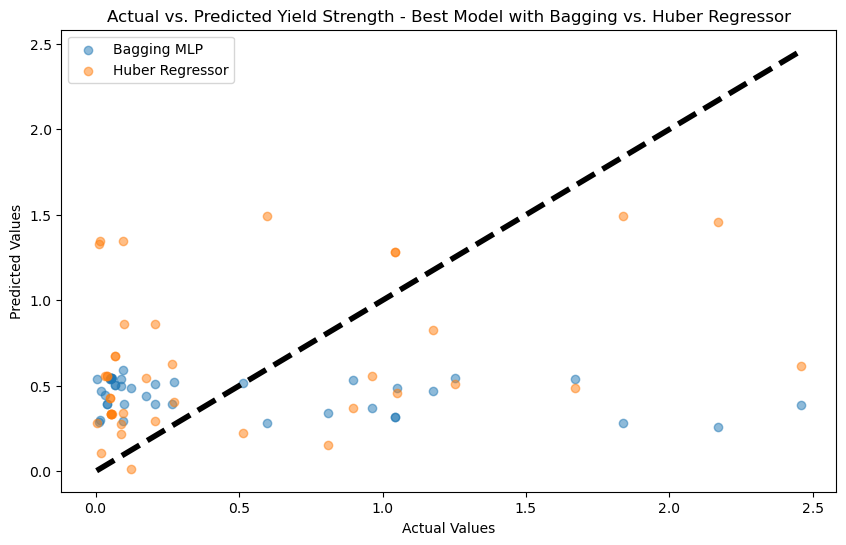

In [48]:
# Retrain the best model with Bagging
best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
best_bagging_model.fit(X_train, y_train)
best_preds = best_bagging_model.predict(X_test)

# Initialize the Huber Regressor
huber_reg = HuberRegressor()

# Fit the model
huber_reg.fit(X_train, y_train)

# Make predictions
y_pred_huber = huber_reg.predict(X_test)

# Calculate Mean Squared Error for Huber Regressor
mse_huber = mean_squared_error(y_test, y_pred_huber)
print(f"Mean Squared Error - Huber Regressor: {mse_huber}")


# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_preds, alpha=0.5, label='Bagging MLP')
plt.scatter(y_test, y_pred_huber, alpha=0.5, label='Huber Regressor')
plt.title('Actual vs. Predicted Yield Strength - Best Model with Bagging vs. Huber Regressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.legend()
plt.show()

Spearman's rank correlation coefficient: -0.285558512069942
P-value of the correlation coefficient: 0.07032481376437899


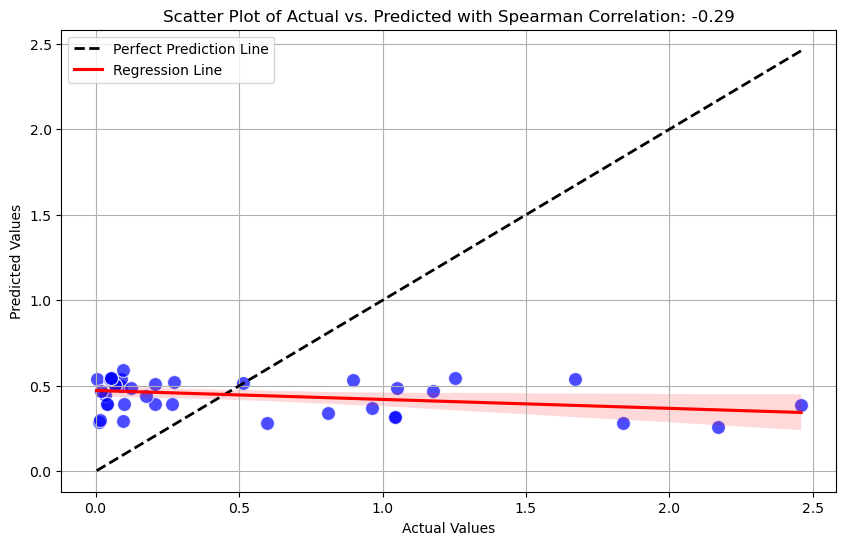

Spearman's rank correlation coefficient: 0.2681990668578087
P-value of the correlation coefficient: 0.08999529386661569


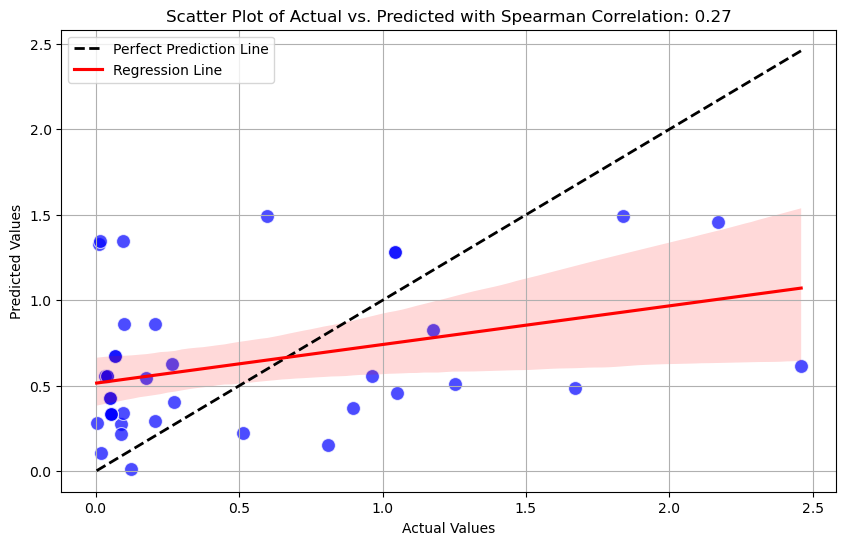

In [49]:
actuals = y_test  # Your array of actual Young's moduli
preds = best_preds   # Your array of predicted Young's moduli

rank_correlation = evaluate_rank_correlation(actuals, preds)


plot_rank_correlation(actuals, preds)

rank_correlation = evaluate_rank_correlation(actuals, y_pred_huber)
plot_rank_correlation(actuals, y_pred_huber)

In [50]:
bounds = [(75, 100)] + [(0, 100) for _ in range(1, len(X_train.columns))]
cons = ({'type': 'eq', 'fun': lambda x: 100 - np.sum(x)})

results = []
best_score = -np.inf  # Assuming maximization
best_composition = None

for i in range(25):
    # Generate initial random composition
    initial_composition_random = [75] + [np.random.rand() * 25 for _ in range(1, len(X_train.columns))]
    initial_composition_random = np.array(initial_composition_random)
    initial_composition_random *= 100 / np.sum(initial_composition_random)  # Normalize to sum to 100%

    # Perform the minimization
    result = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=cons, 
        options={'disp': True, 'maxiter': 1000}
    )

    if result.success:
        adjusted_score = -result.fun  # Convert back since we minimize the negative in objective_function
        results.append((result.x, adjusted_score))
        if adjusted_score > best_score:
            best_score = adjusted_score
            best_composition = result.x

# Output the best result found
print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

# Save results
results_path = 'Ti_model_data/yield_optimization_results.csv'
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists

with open(results_path, 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.2801157870939406
            Iterations: 35
            Function evaluations: 444
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4435054171455515
            Iterations: 43
            Function evaluations: 501
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4435058276773365
            Iterations: 40
            Function evaluations: 465
            Gradient evaluations: 40
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4435059364697644
            Iterations: 46
            Function evaluations: 529
            Gradient evaluations: 46
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4435070887356345
            Iterations: 38
            Fun

In [51]:
# Assuming we already have the best alloy and its score from the earlier setup
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

# Plot the best alloy composition along with its score
plt.figure(figsize=(10, 6))
bars = plt.bar(X.columns, best_alloy, color='blue')
plt.xlabel('Element')
plt.ylabel('Percentage')
plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
plt.xticks(rotation=45)

# Add the score to each bar in the graph
for bar, percentage in zip(bars, best_alloy):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')  # for composition percentage

plt.tight_layout()
plt.savefig('best_alloy_composition_with_score.png')
plt.show()


## Tensile Strength

### Data Preperation

In [52]:
# Assuming df1 is your DataFrame and it contains the columns 'Tensile Strength'
df['Tensile Strength'] = df['Tensile Strength'].apply(extract_numeric)

# List all columns to keep (metal percentages and Tensile Strength)
columns_to_keep = ['Tensile Strength'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_tensile = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_tensile.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_tensile.head()

(Series([], dtype: int64),
    Tensile Strength  Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  \
 0          0.011765           3.4       0.05        0.015      1.60   
 1          0.303573           3.0       0.05        0.015      2.00   
 2          0.024904           0.0       0.00        0.020      0.35   
 3          0.300824           2.7       0.08        0.015      0.20   
 4          0.553215           3.0       0.00        0.000      0.00   
 
    Nitrogen, N  Oxygen, O  Titanium, Ti  Vanadium, V  Molybdenum, Mo  ...  \
 0         0.05       0.13        82.855          9.0             0.0  ...   
 1         0.00       0.10        79.000          8.0             8.0  ...   
 2         0.05       0.20        80.000          0.0            15.0  ...   
 3         0.05       0.15        75.000         13.0             0.0  ...   
 4         0.00       0.00        94.500          2.5             0.0  ...   
 
    Yttrium, Y  Zirconium, Zr  Chromium, Cr  Silicon, Si  Palladium, 

In [53]:
# Splitting the dataset into features and target variable
X = metals_and_tensile.drop('Tensile Strength', axis=1)
y = metals_and_tensile['Tensile Strength']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  Nitrogen, N  Oxygen, O  \
 198       6.83600   0.082900     0.013490  0.362700     0.074200   0.161000   
 38        7.82150   0.069100     0.014880  0.290000     0.050000   0.142800   
 24        6.29600   0.060000     0.013730  0.232400     0.050000   0.150400   
 122       6.68391   0.067627     0.027655  0.430395     0.073237   0.156627   
 196       6.10700   0.067300     0.014965  0.366200     0.047500   0.179000   
 
      Titanium, Ti  Vanadium, V  Molybdenum, Mo  Nickel, Ni  ...  Yttrium, Y  \
 198     87.075290       2.1800         1.80850         0.0  ...         0.0   
 38      86.366270       1.3350         1.07850         0.0  ...         0.0   
 24      87.983030       0.0000         1.52300         0.0  ...         0.0   
 122     86.415666       2.6961         2.13013         0.0  ...         0.0   
 196     88.600010       2.8975         0.24250         0.0  ...         0.0   
 
      Zirconium, Zr  Chromium, Cr  S

### Feature Selection

#### Random Forest Feature Importance

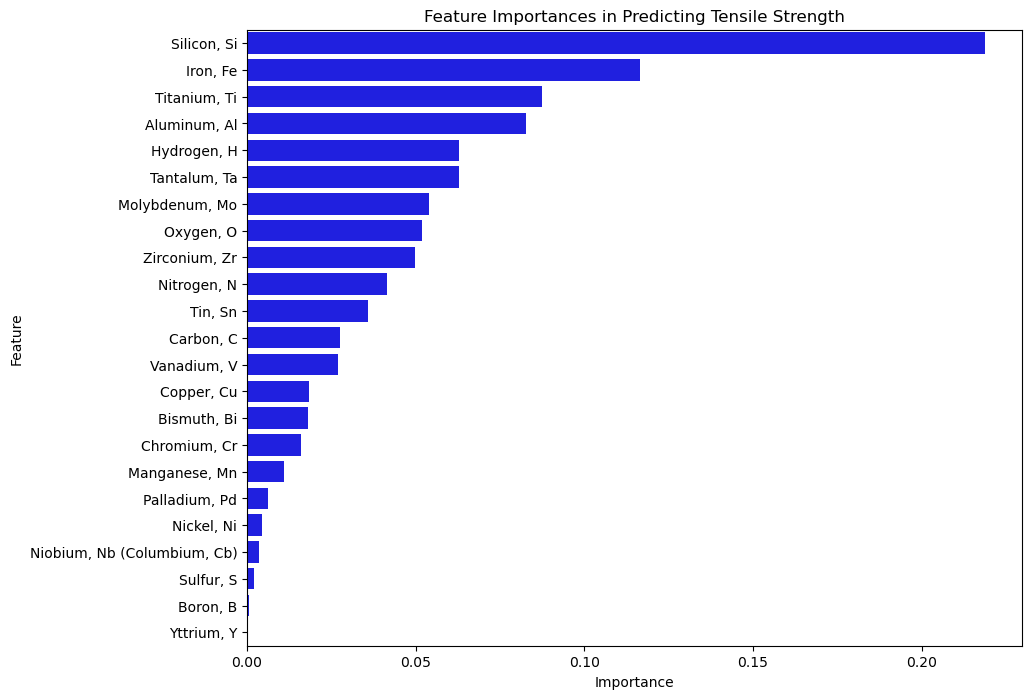

In [54]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)

# Get feature importances from the Random Forest model
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization of feature importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

rf_mse, features_importance_df

features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# Use seaborn to plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_importance_df, color='blue')
plt.title('Feature Importances in Predicting Tensile Strength')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Combination Neural Network Feature Combination Importance

Processing new combinations...
Processing combination: ('Oxygen, O', 'Nickel, Ni', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Iron, Fe', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Silicon, Si', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Chromium, Cr', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Tin, Sn', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Palladium, Pd', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Iron, Fe', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Silicon, Si', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Molybdenum, Mo', 'Titanium, Ti'

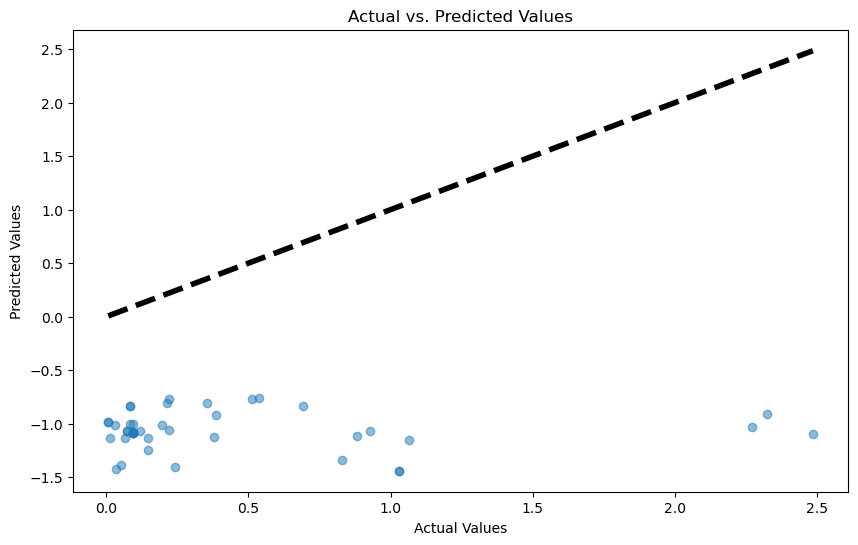

In [55]:
# Assuming metals_and_tensile is preloaded with the relevant data
top_features = ['Oxygen, O', 'Nickel, Ni', 'Aluminum, Al', 'Nitrogen, N', 'Iron, Fe', 'Silicon, Si', 'Molybdenum, Mo', 'Chromium, Cr', 'Tin, Sn', 'Palladium, Pd']
fixed_feature = 'Titanium, Ti'
X = metals_and_tensile[top_features + [fixed_feature]]
y = metals_and_tensile["Tensile Strength"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_3_features_tensile.csv'

if os.path.exists(file_path):
    print("Loading existing results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(ast.literal_eval)
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("Processing new combinations...")
    mse_scores = {}
    full_combinations = [combo + (fixed_feature,) for combo in combinations(top_features, 2)]
    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    best_combination = min(mse_scores, key=mse_scores.get)

# Define and compile the neural network regardless of how best_combination was obtained
nn_model = Sequential([
    Dense(3, input_dim=3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

In [56]:
# Assuming metals_and_tensile is preloaded with the relevant data, rename it appropriately if it contains yield strength
top_features = ['Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']
fixed_feature = 'Titanium, Ti'

# Exclude fixed feature if it's accidentally included in top_features
top_features = [feat for feat in top_features if feat != fixed_feature]

# Assuming the DataFrame name that contains 'Yield Strength'
X = metals_and_tensile[top_features + [fixed_feature]]
y = metals_and_tensile["Tensile Strength"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_2_features_tensile.csv'

# Load or process data
if os.path.exists(file_path):
    print("Results file already exists. Loading results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(lambda x: ast.literal_eval(x))
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("No results file found. Processing new combinations...")
    full_combinations = [(feat, fixed_feature) for feat in top_features]
    mse_scores = {}

    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=2, activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    print("Results saved to", file_path)
    best_combination = tuple(results_df.loc[results_df['MSE'].idxmin(), 'Combination'])

print(f"Best combination including Aluminum: {best_combination}, MSE: {results_df['MSE'].min()}")

# Define and train the neural network with the best combination
nn_model = Sequential([
    Dense(3, input_dim=2, activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)

y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

No results file found. Processing new combinations...
Processing combination: ('Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Carbon, C', 'Titanium, Ti')
Processing combination: ('Hydrogen, H', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Titanium, Ti')
Processing combination: ('Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Titanium, Ti')
Processing combination: ('Vanadium, V', 'Titanium, Ti')
Processing combination: ('Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Titanium, Ti')
Processing combination: ('Sulfur, S', 'Titanium, Ti')
Processing combination: ('Boron, B', 'Titanium, Ti')
Processing combination: ('Tin, Sn', 'Titanium, Ti')
Processing combination: ('Yttrium, Y', 'Titanium, Ti')
Processing combination: ('Zirconium, Zr', 'Titanium, Ti')
Processing combination: ('Chromium, Cr', 'Titanium, Ti')
Processing combination: ('Silicon, Si', 'Titanium, Ti')
Processing combination: ('Palladium, Pd', 'Titanium, Ti')
Pro

#### Correlation Matrix 

In [57]:
# Calculate correlation matrix including 'Tensile Strength'
corr_matrix = metals_and_tensile.corr()

# Isolate the correlation of 'Tensile Strength' with other features
tensile_corr = corr_matrix["Tensile Strength"].drop("Tensile Strength").sort_values(ascending=False)

# Print the correlation values
print(tensile_corr)

# Visualize correlations using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=tensile_corr.index, y=tensile_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation with Tensile Strength")
plt.ylabel("Correlation Coefficient")
plt.show()

Tantalum, Ta                   0.200554
Palladium, Pd                  0.195678
Silicon, Si                    0.121905
Sulfur, S                      0.112441
Boron, B                       0.092554
Yttrium, Y                     0.092554
Bismuth, Bi                    0.071601
Zirconium, Zr                  0.066306
Manganese, Mn                  0.043817
Carbon, C                      0.043766
Tin, Sn                        0.031490
Nitrogen, N                    0.023198
Molybdenum, Mo                -0.004985
Iron, Fe                      -0.006675
Oxygen, O                     -0.008961
Titanium, Ti                  -0.010871
Vanadium, V                   -0.011361
Niobium, Nb (Columbium, Cb)   -0.041471
Chromium, Cr                  -0.045061
Nickel, Ni                    -0.059960
Copper, Cu                    -0.081125
Hydrogen, H                   -0.098977
Aluminum, Al                  -0.256560
Name: Tensile Strength, dtype: float64


#### Regression

In [58]:
metals = ['Titanium, Ti', 'Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']

models = {}
linear_vs_poly = {}
impact_summary = pd.DataFrame(columns=['Metal', 'Coefficient', 'Effect'])

for metal in metals:
    # Check if the maximum metal content is <= 1 to decide the model type
    if metals_and_tensile[metal].max() < 0.1:
        continue  # Skip metals where the maximum content is less than 0.01
        
    if metals_and_tensile[metal].max() <= 1:
        model = evaluate_feature(metals_and_tensile, metal, "Tensile Strength", 1)
        linear_vs_poly[metal] = 'Linear'
    else:
        linear_model = evaluate_feature(metals_and_tensile, metal, "Tensile Strength", 1)
        poly_model = evaluate_feature(metals_and_tensile, metal, "Tensile Strength", 2)
        
        if linear_model.aic < poly_model.aic:
            model = linear_model
            linear_vs_poly[metal] = 'Linear'
        else:
            model = poly_model
            linear_vs_poly[metal] = 'Polynomial'
    
    models[metal] = model
    coeff = model.params[1 if linear_vs_poly[metal] == 'Linear' else 2]
    effect = 'Increases' if coeff > 0 else 'Decreases'

    new_row = pd.DataFrame({'Metal': [metal], 'Coefficient': [coeff], 'Effect': [effect]})
    impact_summary = pd.concat([impact_summary, new_row], ignore_index=True)

print(impact_summary)
# Visualization setup and plotting
cols, rows = 3, (len(models) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()
for idx, metal in enumerate(models):
    ax = axes[idx]
    model = models[metal]
    X = np.linspace(metals_and_tensile[metal].min(), metals_and_tensile[metal].max(), 100).reshape(-1, 1)
    preds = model.predict(sm.add_constant(PolynomialFeatures(1 if linear_vs_poly[metal] == 'Linear' else 2).fit_transform(X)))
    ax.plot(X.flatten(), preds, label=f'{metal} {linear_vs_poly[metal]} Regression', color=plt.cm.viridis(np.linspace(0, 1, len(models)))[idx])
    ax.scatter(metals_and_tensile[metal], metals_and_tensile["Tensile Strength"], color='gray', alpha=0.5)
    ax.set(title=f'{metal} - {linear_vs_poly[metal]}', xlabel='Metal Content', ylabel="Tensile Strength")
    ax.legend()

# Turn off axes for any empty subplots
for i in range(idx + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

                          Metal  Coefficient     Effect
0                  Titanium, Ti    -0.001014  Decreases
1                  Aluminum, Al    -0.074177  Decreases
2                     Carbon, C     0.749565  Increases
3                   Hydrogen, H    -4.597921  Decreases
4                      Iron, Fe     0.715758  Increases
5                   Nitrogen, N     0.375570  Increases
6                     Oxygen, O    -0.097871  Decreases
7                   Vanadium, V     0.008824  Increases
8                Molybdenum, Mo    -0.001364  Decreases
9                    Nickel, Ni    -0.009906  Decreases
10                      Tin, Sn     0.012557  Increases
11                Zirconium, Zr     0.022660  Increases
12                 Chromium, Cr     0.012680  Increases
13                  Silicon, Si     1.027598  Increases
14                Palladium, Pd     5.559176  Increases
15                 Tantalum, Ta     0.011174  Increases
16  Niobium, Nb (Columbium, Cb)    -1.534548  De

In [59]:
# Splitting the DataFrame into positive and negative subsets
positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()

# Sorting each subset
positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value

# Concatenating back into a single DataFrame
sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)

# Define colors based on coefficient sign and set edge colors for better visibility
colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]

# Set up the plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
plt.xlabel('Coefficient Value')
plt.title('Impact of Each Metal on Tensile Strength')

# Invert y-axis to have the largest impact at the top
plt.gca().invert_yaxis()

# Add text labels to bars for exact coefficient values
for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
             ha='right' if value < 0 else 'left')

# Show the plot
plt.show()

# Optionally, print the DataFrame for a tabular view
print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

                          Metal  Coefficient     Effect
14                Palladium, Pd     5.559176  Increases
19                  Bismuth, Bi     1.088689  Increases
13                  Silicon, Si     1.027598  Increases
17                   Copper, Cu     1.009757  Increases
2                     Carbon, C     0.749565  Increases
4                      Iron, Fe     0.715758  Increases
5                   Nitrogen, N     0.375570  Increases
11                Zirconium, Zr     0.022660  Increases
12                 Chromium, Cr     0.012680  Increases
10                      Tin, Sn     0.012557  Increases
15                 Tantalum, Ta     0.011174  Increases
7                   Vanadium, V     0.008824  Increases
0                  Titanium, Ti    -0.001014  Decreases
8                Molybdenum, Mo    -0.001364  Decreases
9                    Nickel, Ni    -0.009906  Decreases
1                  Aluminum, Al    -0.074177  Decreases
6                     Oxygen, O    -0.097871  De

### <span style="color:lime">Optimizing Tensile Strength</span>

#### <span style="color:red">Random Forest</span>

In [60]:
selected_features = ['Titanium, Ti', 'Oxygen, O', 'Nitrogen, N', 'Nickel, Ni', 'Zirconium, Zr', 'Vanadium, V', 'Niobium, Nb (Columbium, Cb)', 'Carbon, C', 'Manganese, Mn']
target_variable = "Tensile Strength"

# Split the data into training and testing sets
X = df[selected_features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10000, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting the "Tensile Strength" using the trained model
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Find the maximum predicted Tensile Strength
max_tensile_strength = max(y_pred)

mse, rmse, max_tensile_strength

(0.45270504800282235, 0.6728335960717348, 1.4919445743282929)

In [61]:
# Finding the index of the maximum predicted Tensile Strength
index_max_tensile = y_pred.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test.iloc[index_max_tensile]

strongest_composition

Titanium, Ti                   97.877
Oxygen, O                       0.250
Nitrogen, N                     0.250
Nickel, Ni                      0.600
Zirconium, Zr                   0.000
Vanadium, V                     0.000
Niobium, Nb (Columbium, Cb)     0.000
Carbon, C                       0.060
Manganese, Mn                   0.000
Name: 84, dtype: float64

In [62]:
# Filtering the dataset to ensure Aluminum content is between 75% and 100%
filtered_data = df[(df['Titanium, Ti'] >= 75) & (df['Titanium, Ti'] <= 100)]

# Split the filtered data into training and testing sets
X_filtered = filtered_data[selected_features]
y_filtered = filtered_data[target_variable]
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor on the filtered data
rf_model_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_filtered.fit(X_train_filtered, y_train_filtered)

# Predicting the Tensile Strength using the trained model on filtered data
y_pred_filtered = rf_model_filtered.predict(X_test_filtered)

# Evaluate the model on filtered data
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
rmse_filtered = mse_filtered ** 0.5

# Find the maximum predicted on filtered data
max_tensile_strength_filtered = max(y_pred_filtered)

mse_filtered, rmse_filtered, max_tensile_strength_filtered

(0.4004644786990864, 0.6328226281503265, 1.4094089876670324)

In [63]:
# Finding the index of the maximum predicted Tensile Strength
index_max_tensile = y_pred.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test.iloc[index_max_tensile]

strongest_composition

Titanium, Ti                   97.877
Oxygen, O                       0.250
Nitrogen, N                     0.250
Nickel, Ni                      0.600
Zirconium, Zr                   0.000
Vanadium, V                     0.000
Niobium, Nb (Columbium, Cb)     0.000
Carbon, C                       0.060
Manganese, Mn                   0.000
Name: 84, dtype: float64

In [64]:
# File path for the output CSV
output_file_path = "Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_tensile.csv"

# Check if the output file already exists
if os.path.exists(output_file_path):
    # Read the existing results
    hypothetical_results = pd.read_csv(output_file_path)
    print("Loaded results from existing file.")
else:
    # Define the increments for Aluminum and the other metals
    al_increments = np.arange(75, 101, 5)  # Correct range for Aluminum from 75% to 100%
    other_increments = np.arange(0, 26, 5)  # Other metals must sum up to fill the remaining percentage
    metals = [ 'Oxygen, O', 'Nitrogen, N', 'Nickel, Ni', 'Zirconium, Zr', 'Vanadium, V', 'Niobium, Nb (Columbium, Cb)', 'Carbon, C', 'Manganese, Mn']
    
    # Generate all valid combinations where the total percentage is 100
    valid_combinations = []
    for al_percent in al_increments:
        for combo in product(other_increments, repeat=len(metals)):
            if sum(combo) == (100 - al_percent):  # Ensure the total sum with Aluminum is 100%
                valid_combinations.append((al_percent,) + combo)
    
    # Convert the list of combinations into a DataFrame
    hypothetical_metals_df = pd.DataFrame(valid_combinations, columns=['Titanium, Ti'] + metals)
    
    # Assuming rf_model is already trained and available
    # Predict Tensile Strength for these hypothetical alloys
    hypothetical_tensile_strength = rf_model.predict(hypothetical_metals_df)
    
    # Combining the compositions and their predicted Tensile Strength
    hypothetical_results = hypothetical_metals_df.copy()
    hypothetical_results['Predicted Tensile Strength'] = hypothetical_tensile_strength
    
    # Save all combinations and their predicted Tensile Strength to a CSV file
    hypothetical_results.to_csv("Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_tensile.csv", index=False)
    print("Predictions performed and results saved.")
    
    # Find the top 10 combinations with the highest predicted Tensile Strength
top_10_tensile_combinations = hypothetical_results.nlargest(10, 'Predicted Tensile Strength')
    
# Print the top 10 combinations
print("Top 10 Tensile Strength Combinations:")
print(top_10_tensile_combinations.head(10))  # Print only the top 5 of these top 10

Loaded results from existing file.
Top 10 Tensile Strength Combinations:
      Titanium, Ti  Palladium, Pd  Oxygen, O  Nitrogen, N  Nickel, Ni  \
1931            85              5          5            0           0   
1877            85              0          5            0           0   
1999            95              0          5            0           0   
1873            85              0          5            0           0   
1868            85              0          5            0           0   
1895            85              0         10            0           0   
1933            85              5          5            0           0   
1867            85              0          5            0           0   
1870            85              0          5            0           0   
1937            85              5         10            0           0   

      Zirconium, Zr  Vanadium, V  Niobium, Nb (Columbium, Cb)  Carbon, C  \
1931              0            0               

#### <span style="color:red">MLP</span>

In [65]:
# Assuming metals_and_tensile is preloaded with the relevant data
X = metals_and_tensile[['Titanium, Ti', 'Oxygen, O', 'Nitrogen, N', 'Nickel, Ni', 'Zirconium, Zr', 'Vanadium, V', 'Niobium, Nb (Columbium, Cb)', 'Carbon, C', 'Manganese, Mn']]
y = metals_and_tensile["Tensile Strength"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [2000, 3000, 4000]

# Path for the grid search results CSV
results_csv_path = 'Ti_model_data/grid_search_titanium_tensile_results.csv'

# Check if results already exist
if os.path.exists(results_csv_path):
    # Load and print the existing results
    results_df = pd.read_csv(results_csv_path)
    # Finding the best configuration with the lowest MSE
    best_row = results_df.loc[results_df['MSE'].idxmin()]
    best_layers = ast.literal_eval(best_row['Layers'])  # Convert string back to tuple if stored as string
    best_max_iter = best_row['Max_iter']
    best_mse = best_row['MSE']
    print(f"Best Configuration: Layers={best_layers}, Max_iter={best_max_iter}, Best MSE={best_mse}")
    print("Loaded results from existing file:")
    print(results_df)
else:
    # Initialize a list to store results
    results = []
    best_mse = float('inf')
    best_configuration = None

    # Grid search over layer configurations and max_iter_options
    for layers in layer_configurations:
        for max_iter in max_iter_options:
            base_nn = MLPRegressor(hidden_layer_sizes=layers, activation='relu', solver='adam', max_iter=max_iter)
            bagging_model = BaggingRegressor(base_nn, n_estimators=10, random_state=42)
            bagging_model.fit(X_train, y_train)

            y_pred = bagging_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            # Save each configuration's MSE
            results.append({'Layers': layers, 'Max_iter': max_iter, 'MSE': mse})

            if mse < best_mse:
                best_mse = mse
                best_layers = layers
                best_max_iter = max_iter

            print(f"Configuration: Layers={layers}, Max_iter={max_iter}, MSE={mse}")

    print(f"Best Configuration: Layers={best_layers}, Max_iter={max_iter}, Best MSE={best_mse}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(results_csv_path, index=False)
    print("Grid search results saved.")

Best Configuration: Layers=(8,), Max_iter=2000, Best MSE=0.4431988823682742
Loaded results from existing file:
          Layers  Max_iter       MSE
0     (30, 3, 1)      2000  0.487306
1     (30, 3, 1)      3000  0.487306
2     (30, 3, 1)      4000  0.487306
3        (40, 2)      2000  0.898912
4        (40, 2)      3000  0.863419
..           ...       ...       ...
76     (2, 2, 2)      3000  0.521299
77     (2, 2, 2)      4000  0.527261
78  (2, 2, 2, 2)      2000  0.577875
79  (2, 2, 2, 2)      3000  0.577875
80  (2, 2, 2, 2)      4000  0.577875

[81 rows x 3 columns]


/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.40511998301065427


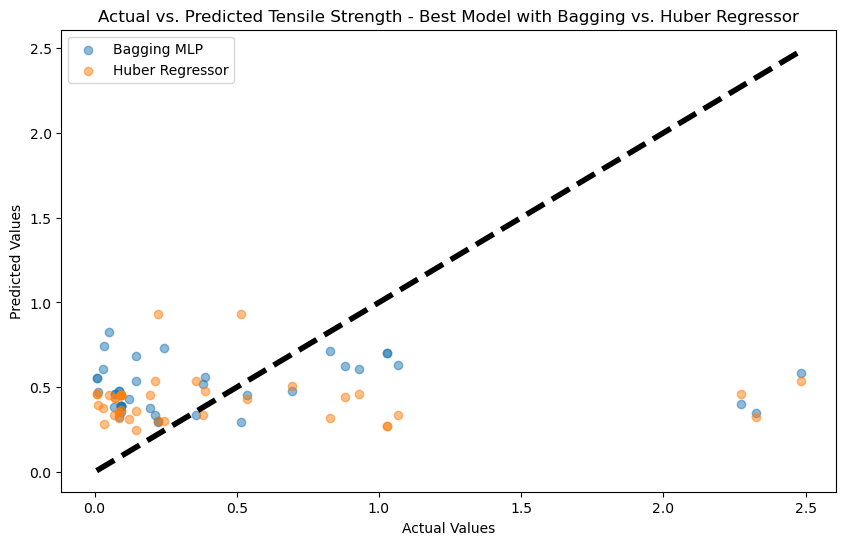

In [66]:
# Retrain the best model with Bagging
best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
best_bagging_model.fit(X_train, y_train)
best_preds = best_bagging_model.predict(X_test)

# Initialize the Huber Regressor
huber_reg = HuberRegressor()

# Fit the model
huber_reg.fit(X_train, y_train)

# Make predictions
y_pred_huber = huber_reg.predict(X_test)

# Calculate Mean Squared Error for Huber Regressor
mse_huber = mean_squared_error(y_test, y_pred_huber)
print(f"Mean Squared Error - Huber Regressor: {mse_huber}")


# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_preds, alpha=0.5, label='Bagging MLP')
plt.scatter(y_test, y_pred_huber, alpha=0.5, label='Huber Regressor')
plt.title('Actual vs. Predicted Tensile Strength - Best Model with Bagging vs. Huber Regressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.legend()
plt.show()

Spearman's rank correlation coefficient: 0.058005146376417904
P-value of the correlation coefficient: 0.7186739449308592


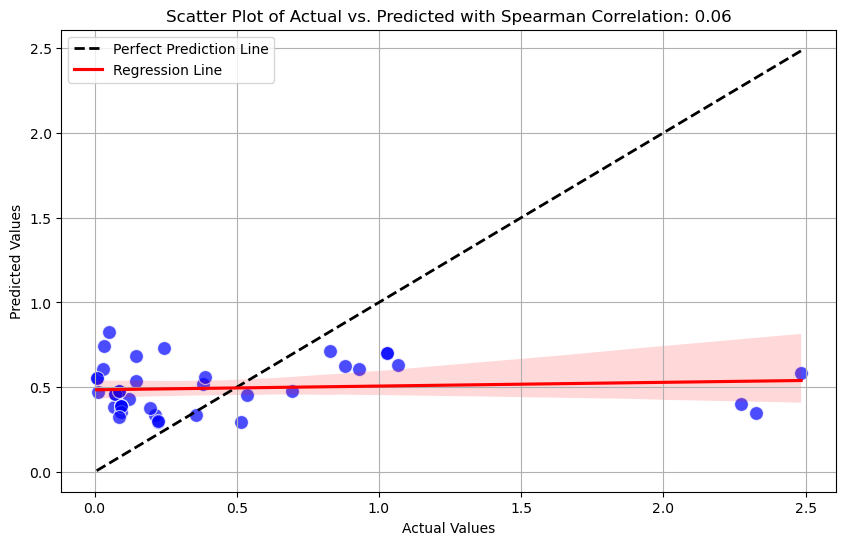

Spearman's rank correlation coefficient: 0.04980592267809718
P-value of the correlation coefficient: 0.7571367001805848


In [67]:
actuals = y_test  # Your array of actual Young's moduli
preds = best_preds   # Your array of predicted Young's moduli

rank_correlation = evaluate_rank_correlation(actuals, preds)


plot_rank_correlation(actuals, preds)

rank_correlation = evaluate_rank_correlation(actuals, y_pred_huber)
plot_rank_correlation(actuals, y_pred_huber)

In [68]:
bounds = [(75, 100)] + [(0, 100) for _ in range(1, len(X_train.columns))]
cons = ({'type': 'eq', 'fun': lambda x: 100 - np.sum(x)})

results = []
best_score = -np.inf  # Assuming maximization
best_composition = None

for i in range(25):
    # Generate initial random composition
    initial_composition_random = [75] + [np.random.rand() * 25 for _ in range(1, len(X_train.columns))]
    initial_composition_random = np.array(initial_composition_random)
    initial_composition_random *= 100 / np.sum(initial_composition_random)  # Normalize to sum to 100%

    # Perform the minimization
    result = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=cons, 
        options={'disp': True, 'maxiter': 1000}
    )

    if result.success:
        adjusted_score = -result.fun  # Convert back since we minimize the negative in objective_function
        results.append((result.x, adjusted_score))
        if adjusted_score > best_score:
            best_score = adjusted_score
            best_composition = result.x

# Output the best result found
print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

# Save results
results_path = 'Ti_model_data/tensile_optimization_results.csv'
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists

with open(results_path, 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.350038409047986
            Iterations: 42
            Function evaluations: 432
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.2292457907897907
            Iterations: 22
            Function evaluations: 236
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.229228636895028
            Iterations: 36
            Function evaluations: 419
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.228980541725818
            Iterations: 35
            Function evaluations: 393
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.2196632155761646
            Iterations: 23
            Functi

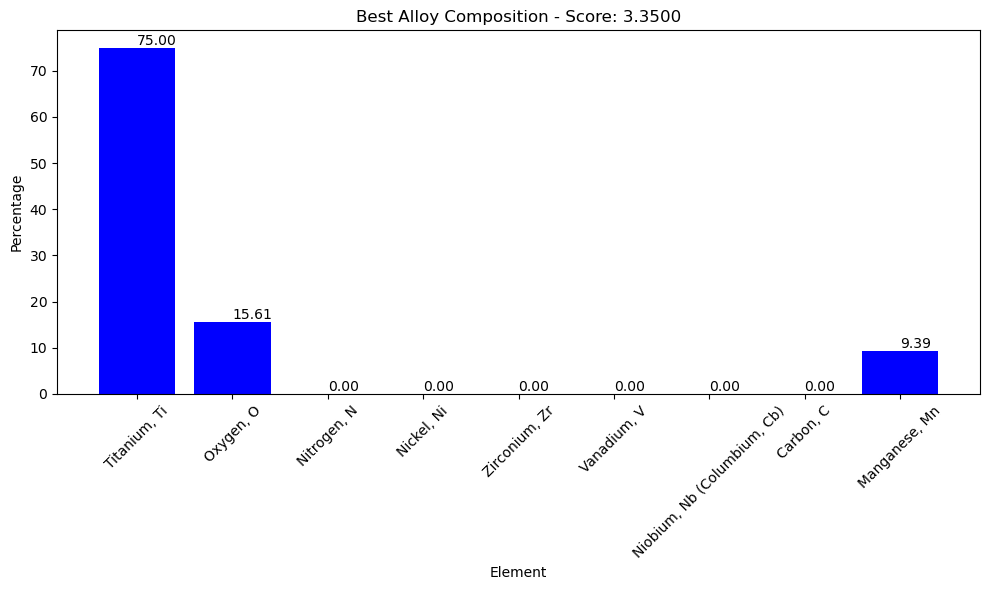

In [69]:
# Assuming we already have the best alloy and its score from the earlier setup
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

# Plot the best alloy composition along with its score
plt.figure(figsize=(10, 6))
bars = plt.bar(X.columns, best_alloy, color='blue')
plt.xlabel('Element')
plt.ylabel('Percentage')
plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
plt.xticks(rotation=45)

# Add the score to each bar in the graph
for bar, percentage in zip(bars, best_alloy):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')  # for composition percentage

plt.tight_layout()
plt.savefig('best_alloy_composition_with_score.png')
plt.show()

## Specific Heat

### Data Preperation

In [70]:
# Assuming df1 is your DataFrame and it contains the columns 'Specific Heat' 
df['Specific Heat'] = df['Specific Heat'].apply(extract_numeric)

# List all columns to keep (metal percentages and Specific Heat)
columns_to_keep = ['Specific Heat'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_heat = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_heat.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_heat.head()

(Series([], dtype: int64),
    Specific Heat  Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  Nitrogen, N  \
 0       0.204190           3.4       0.05        0.015      1.60         0.05   
 1       0.204190           3.0       0.05        0.015      2.00         0.00   
 2       0.365633           0.0       0.00        0.020      0.35         0.05   
 3       0.064434           2.7       0.08        0.015      0.20         0.05   
 4       0.204190           3.0       0.00        0.000      0.00         0.00   
 
    Oxygen, O  Titanium, Ti  Vanadium, V  Molybdenum, Mo  ...  Yttrium, Y  \
 0       0.13        82.855          9.0             0.0  ...       0.000   
 1       0.10        79.000          8.0             8.0  ...       0.000   
 2       0.20        80.000          0.0            15.0  ...       0.000   
 3       0.15        75.000         13.0             0.0  ...       0.005   
 4       0.00        94.500          2.5             0.0  ...       0.000   
 
    Zirconium, 

In [71]:
# Splitting the dataset into features and target variable
X = metals_and_heat.drop('Specific Heat', axis=1)
y = metals_and_heat['Specific Heat']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  Nitrogen, N  Oxygen, O  \
 198       6.83600   0.082900     0.013490  0.362700     0.074200   0.161000   
 38        7.82150   0.069100     0.014880  0.290000     0.050000   0.142800   
 24        6.29600   0.060000     0.013730  0.232400     0.050000   0.150400   
 122       6.68391   0.067627     0.027655  0.430395     0.073237   0.156627   
 196       6.10700   0.067300     0.014965  0.366200     0.047500   0.179000   
 
      Titanium, Ti  Vanadium, V  Molybdenum, Mo  Nickel, Ni  ...  Yttrium, Y  \
 198     87.075290       2.1800         1.80850         0.0  ...         0.0   
 38      86.366270       1.3350         1.07850         0.0  ...         0.0   
 24      87.983030       0.0000         1.52300         0.0  ...         0.0   
 122     86.415666       2.6961         2.13013         0.0  ...         0.0   
 196     88.600010       2.8975         0.24250         0.0  ...         0.0   
 
      Zirconium, Zr  Chromium, Cr  S

### Feature Selection

#### Random Forest Feature Importance

In [72]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)

# Get feature importances from the Random Forest model
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization of feature importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

rf_mse, features_importance_df

features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# Use seaborn to plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_importance_df, color='blue')
plt.title('Feature Importances in Predicting Specfic Heat')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Combination Neural Network Feature Combination Importance

In [73]:
# Assuming metals_and_heat is preloaded with the relevant data
top_features = ['Copper, Cu', 'Nickel, Ni', 'Aluminum, Al', 'Iron, Fe', 'Vanadium, V', 'Tin, Sn', 'Nitrogen, N', 'Niobium, Nb (Columbium, Cb)', 'Zirconium, Zr', 'Chromium, Cr' ]
fixed_feature = 'Titanium, Ti'
X = metals_and_heat[top_features + [fixed_feature]]
y = metals_and_heat["Specific Heat"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_3_features_heat.csv'

if os.path.exists(file_path):
    print("Loading existing results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(ast.literal_eval)
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("Processing new combinations...")
    mse_scores = {}
    full_combinations = [combo + (fixed_feature,) for combo in combinations(top_features, 2)]
    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    best_combination = min(mse_scores, key=mse_scores.get)

# Define and compile the neural network regardless of how best_combination was obtained
nn_model = Sequential([
    Dense(3, input_dim=3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

Processing new combinations...
Processing combination: ('Copper, Cu', 'Nickel, Ni', 'Titanium, Ti')
Processing combination: ('Copper, Cu', 'Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Copper, Cu', 'Iron, Fe', 'Titanium, Ti')
Processing combination: ('Copper, Cu', 'Vanadium, V', 'Titanium, Ti')
Processing combination: ('Copper, Cu', 'Tin, Sn', 'Titanium, Ti')
Processing combination: ('Copper, Cu', 'Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Copper, Cu', 'Niobium, Nb (Columbium, Cb)', 'Titanium, Ti')
Processing combination: ('Copper, Cu', 'Zirconium, Zr', 'Titanium, Ti')
Processing combination: ('Copper, Cu', 'Chromium, Cr', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Iron, Fe', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Vanadium, V', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Tin, Sn', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Nitrogen, N',

No results file found. Processing new combinations...
Processing combination: ('Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Carbon, C', 'Titanium, Ti')
Processing combination: ('Hydrogen, H', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Titanium, Ti')
Processing combination: ('Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Titanium, Ti')
Processing combination: ('Vanadium, V', 'Titanium, Ti')
Processing combination: ('Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Titanium, Ti')
Processing combination: ('Sulfur, S', 'Titanium, Ti')
Processing combination: ('Boron, B', 'Titanium, Ti')
Processing combination: ('Tin, Sn', 'Titanium, Ti')
Processing combination: ('Yttrium, Y', 'Titanium, Ti')
Processing combination: ('Zirconium, Zr', 'Titanium, Ti')
Processing combination: ('Chromium, Cr', 'Titanium, Ti')
Processing combination: ('Silicon, Si', 'Titanium, Ti')
Processing combination: ('Palladium, Pd', 'Titanium, Ti')
Pro

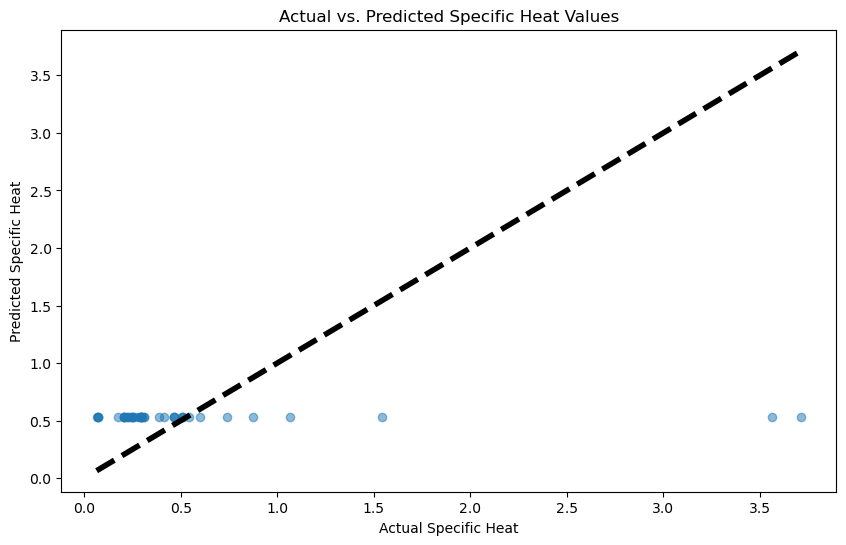

In [74]:
# Assuming metals_and_heat is preloaded with the relevant data, rename it appropriately if it contains yield strength
top_features = ['Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']
fixed_feature = 'Titanium, Ti'

# Exclude fixed feature if it's accidentally included in top_features
top_features = [feat for feat in top_features if feat != fixed_feature]

# Assuming the DataFrame name that contains 'Yield Strength'
X = metals_and_heat[top_features + [fixed_feature]]
y = metals_and_heat["Specific Heat"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_2_features_heat.csv'

# Load or process data
if os.path.exists(file_path):
    print("Results file already exists. Loading results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(lambda x: ast.literal_eval(x))
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("No results file found. Processing new combinations...")
    full_combinations = [(feat, fixed_feature) for feat in top_features]
    mse_scores = {}

    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=2, activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    print("Results saved to", file_path)
    best_combination = tuple(results_df.loc[results_df['MSE'].idxmin(), 'Combination'])

print(f"Best combination including Aluminum: {best_combination}, MSE: {results_df['MSE'].min()}")

# Define and train the neural network with the best combination
nn_model = Sequential([
    Dense(3, input_dim=2, activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)

y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("Actual vs. Predicted Specific Heat Values")
plt.xlabel("Actual Specific Heat")
plt.ylabel("Predicted Specific Heat")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

#### Correlation Matrix 

Palladium, Pd                  0.692822
Bismuth, Bi                    0.359054
Aluminum, Al                   0.119878
Nitrogen, N                    0.085395
Titanium, Ti                   0.082805
Oxygen, O                      0.081779
Silicon, Si                    0.080031
Tin, Sn                        0.043487
Carbon, C                      0.021687
Iron, Fe                       0.021125
Chromium, Cr                  -0.002581
Copper, Cu                    -0.008544
Nickel, Ni                    -0.009432
Hydrogen, H                   -0.018963
Manganese, Mn                 -0.029759
Molybdenum, Mo                -0.036635
Niobium, Nb (Columbium, Cb)   -0.037331
Sulfur, S                     -0.038859
Tantalum, Ta                  -0.043438
Zirconium, Zr                 -0.055648
Yttrium, Y                    -0.063030
Boron, B                      -0.063030
Vanadium, V                   -0.122723
Name: Specific Heat, dtype: float64


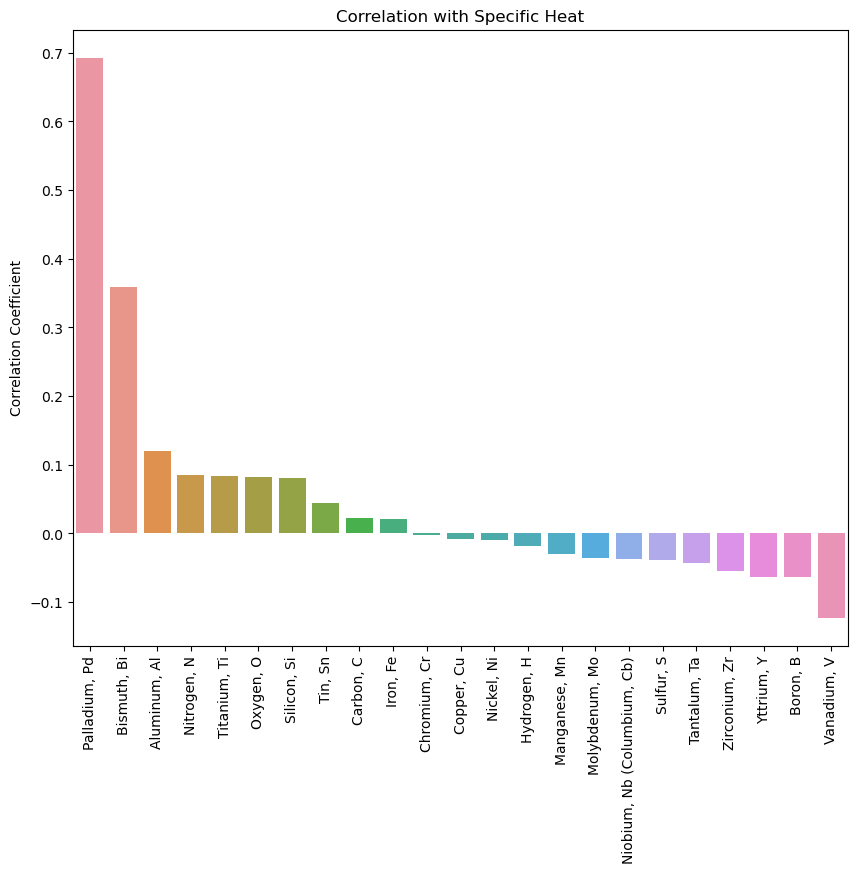

In [75]:
# Calculate correlation matrix 
corr_matrix = metals_and_heat.corr()

# Isolate the correlation of 'Specific Heat' with other features
specific_heat_corr = corr_matrix["Specific Heat"].drop("Specific Heat").sort_values(ascending=False)

# Print the correlation values
print(specific_heat_corr)

# Visualize correlations using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=specific_heat_corr.index, y=specific_heat_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation with Specific Heat")
plt.ylabel("Correlation Coefficient")
plt.show()

#### Regression

                          Metal  Coefficient     Effect
0                  Titanium, Ti     0.010469  Increases
1                  Aluminum, Al     0.029957  Increases
2                     Carbon, C     0.503378  Increases
3                   Hydrogen, H    -1.193866  Decreases
4                      Iron, Fe    -0.569963  Decreases
5                   Nitrogen, N     1.873646  Increases
6                     Oxygen, O     1.210495  Increases
7                   Vanadium, V    -0.026475  Decreases
8                Molybdenum, Mo    -0.013584  Decreases
9                    Nickel, Ni    -0.026252  Decreases
10                      Tin, Sn     0.023502  Increases
11                Zirconium, Zr    -0.025774  Decreases
12                 Chromium, Cr    -0.001089  Decreases
13                  Silicon, Si     0.914277  Increases
14                Palladium, Pd    26.675337  Increases
15                 Tantalum, Ta    -0.017495  Decreases
16  Niobium, Nb (Columbium, Cb)    -0.069924  De

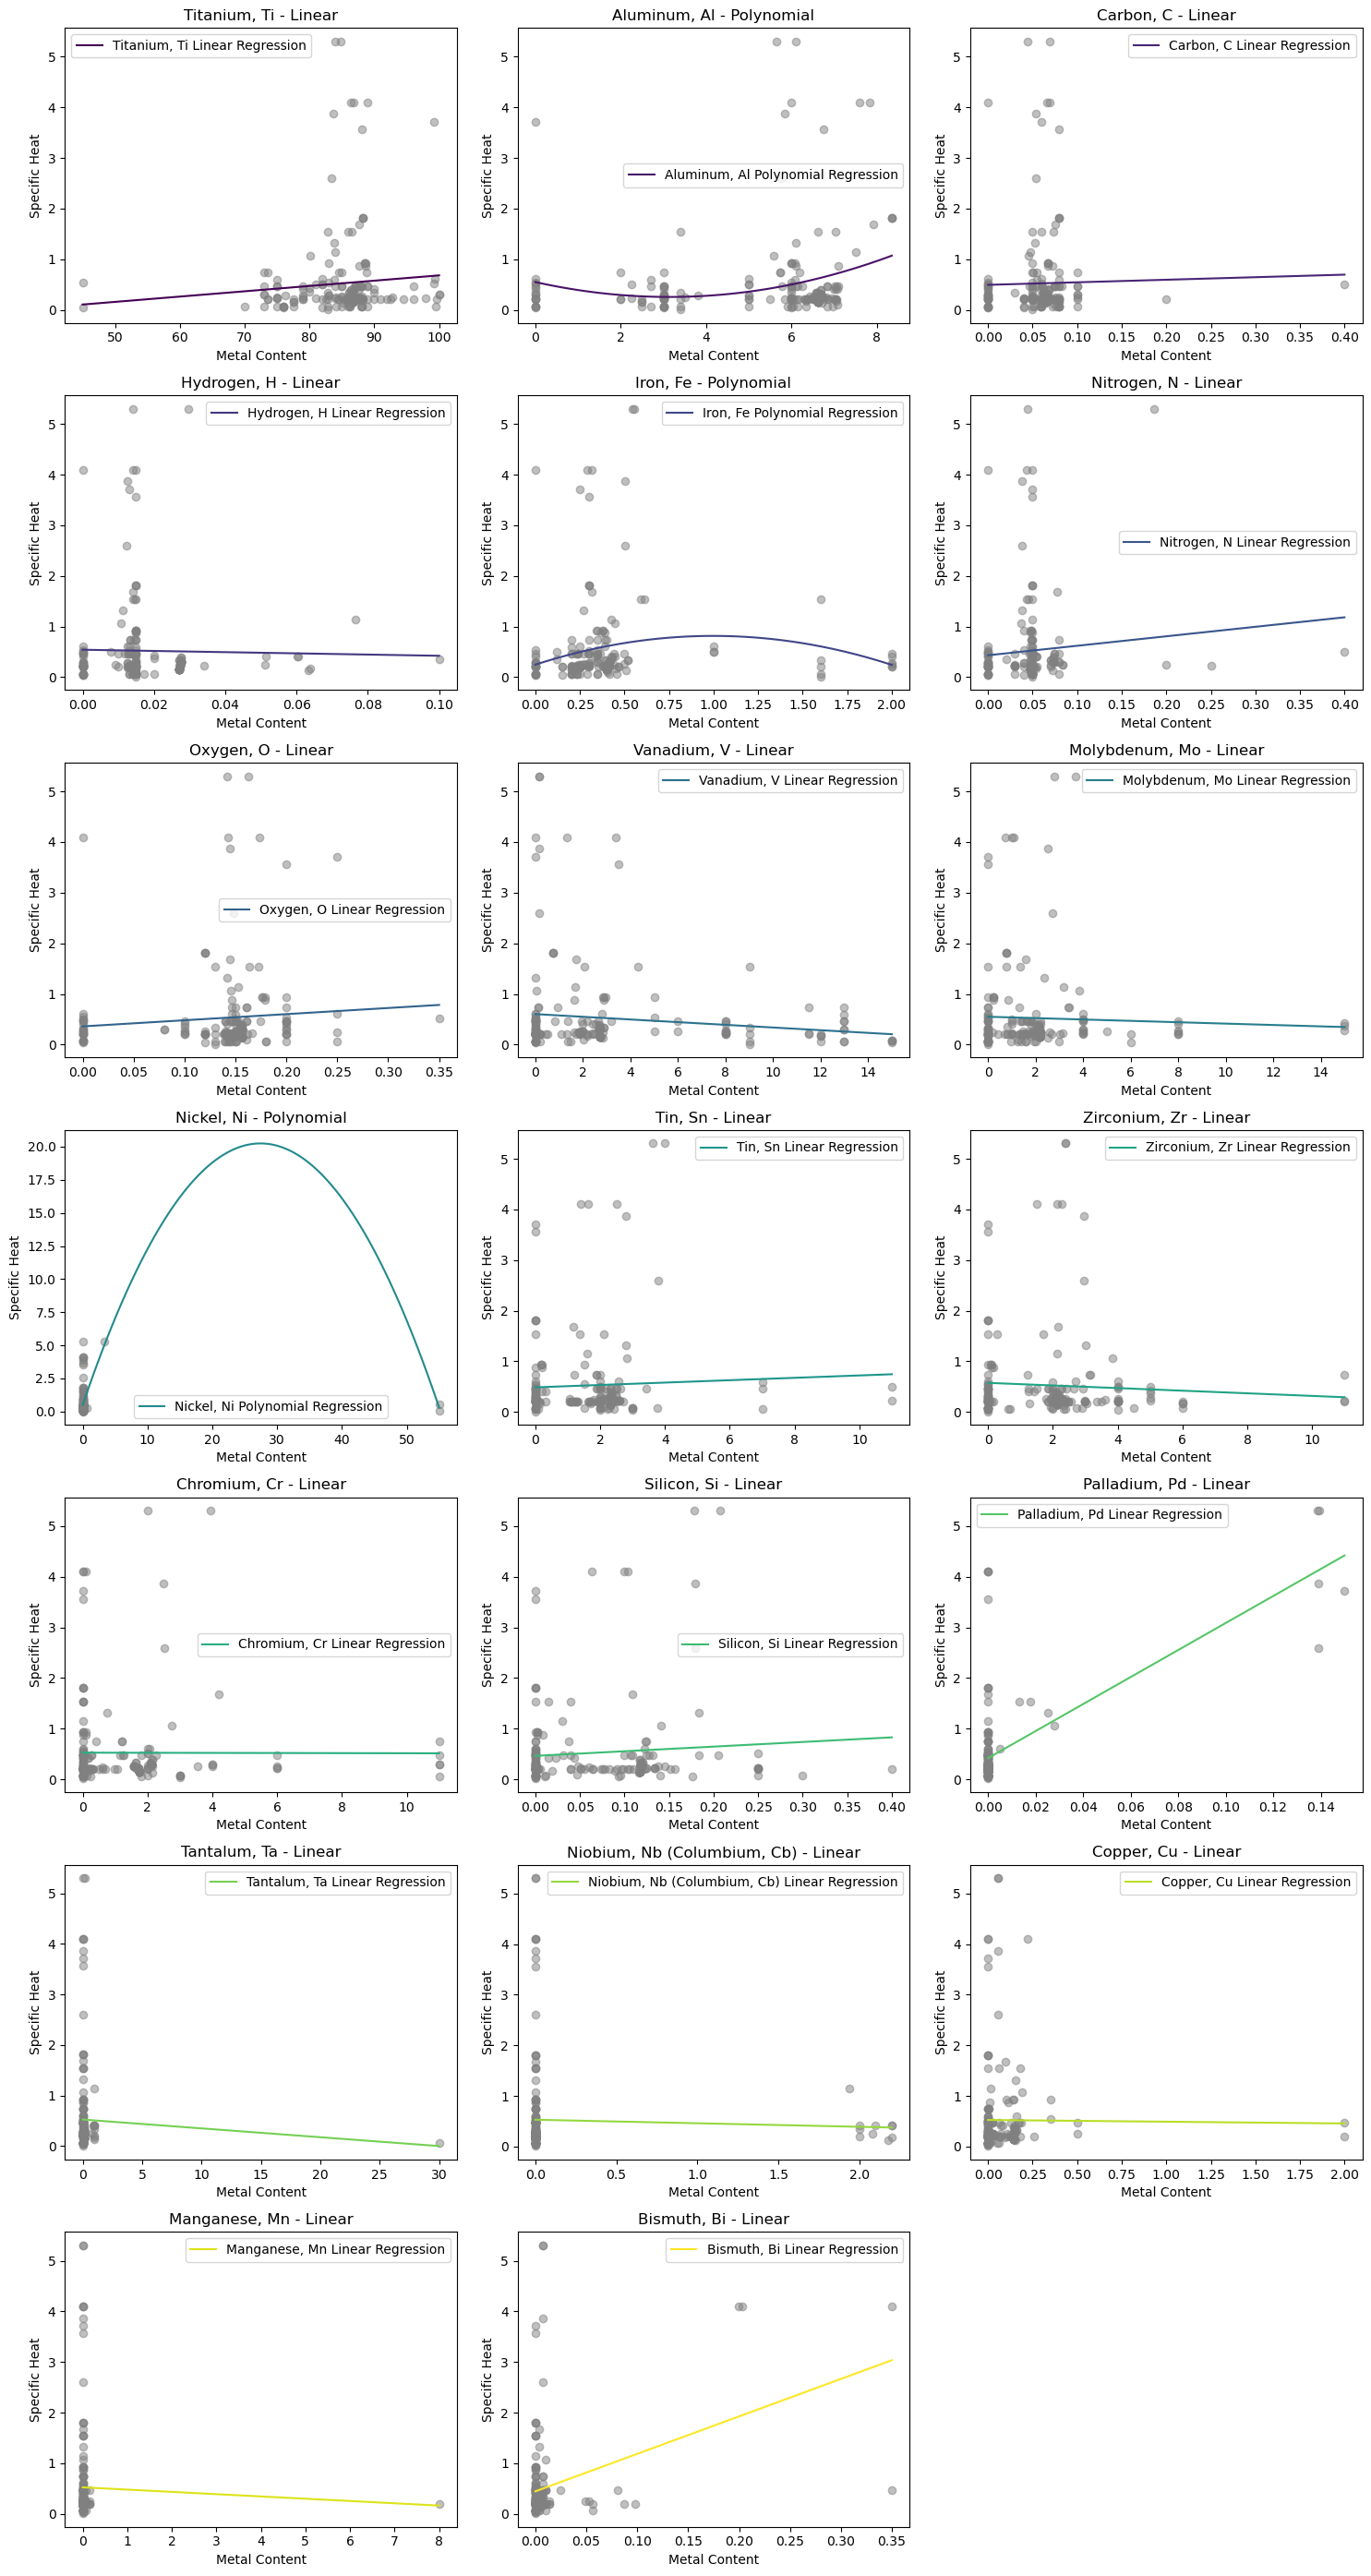

In [76]:
metals = ['Titanium, Ti', 'Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']

models = {}
linear_vs_poly = {}
impact_summary = pd.DataFrame(columns=['Metal', 'Coefficient', 'Effect'])

for metal in metals:
    # Check if the maximum metal content is <= 1 to decide the model type
    if metals_and_heat[metal].max() < 0.1:
        continue  # Skip metals where the maximum content is less than 0.01
        
    if metals_and_heat[metal].max() <= 1:
        model = evaluate_feature(metals_and_heat, metal, "Specific Heat", 1)
        linear_vs_poly[metal] = 'Linear'
    else:
        linear_model = evaluate_feature(metals_and_heat, metal, "Specific Heat", 1)
        poly_model = evaluate_feature(metals_and_heat, metal, "Specific Heat", 2)
        
        if linear_model.aic < poly_model.aic:
            model = linear_model
            linear_vs_poly[metal] = 'Linear'
        else:
            model = poly_model
            linear_vs_poly[metal] = 'Polynomial'
    
    models[metal] = model
    coeff = model.params[1 if linear_vs_poly[metal] == 'Linear' else 2]
    effect = 'Increases' if coeff > 0 else 'Decreases'

    new_row = pd.DataFrame({'Metal': [metal], 'Coefficient': [coeff], 'Effect': [effect]})
    impact_summary = pd.concat([impact_summary, new_row], ignore_index=True)

print(impact_summary)

# Visualization setup and plotting
cols, rows = 3, (len(models) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()
for idx, metal in enumerate(models):
    ax = axes[idx]
    model = models[metal]
    X = np.linspace(metals_and_heat[metal].min(), metals_and_heat[metal].max(), 100).reshape(-1, 1)
    preds = model.predict(sm.add_constant(PolynomialFeatures(1 if linear_vs_poly[metal] == 'Linear' else 2).fit_transform(X)))
    ax.plot(X.flatten(), preds, label=f'{metal} {linear_vs_poly[metal]} Regression', color=plt.cm.viridis(np.linspace(0, 1, len(models)))[idx])
    ax.scatter(metals_and_heat[metal], metals_and_heat["Specific Heat"], color='gray', alpha=0.5)
    ax.set(title=f'{metal} - {linear_vs_poly[metal]}', xlabel='Metal Content', ylabel="Specific Heat")
    ax.legend()

# Turn off axes for any empty subplots
for i in range(idx + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

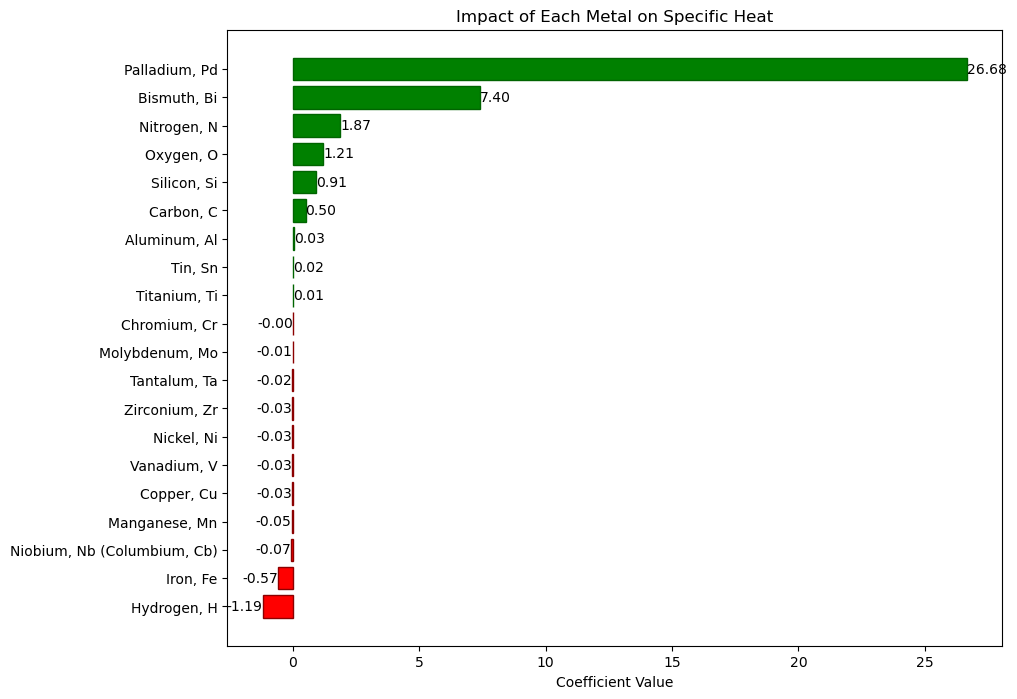

                          Metal  Coefficient     Effect
14                Palladium, Pd    26.675337  Increases
19                  Bismuth, Bi     7.398821  Increases
5                   Nitrogen, N     1.873646  Increases
6                     Oxygen, O     1.210495  Increases
13                  Silicon, Si     0.914277  Increases
2                     Carbon, C     0.503378  Increases
1                  Aluminum, Al     0.029957  Increases
10                      Tin, Sn     0.023502  Increases
0                  Titanium, Ti     0.010469  Increases
12                 Chromium, Cr    -0.001089  Decreases
8                Molybdenum, Mo    -0.013584  Decreases
15                 Tantalum, Ta    -0.017495  Decreases
11                Zirconium, Zr    -0.025774  Decreases
9                    Nickel, Ni    -0.026252  Decreases
7                   Vanadium, V    -0.026475  Decreases
17                   Copper, Cu    -0.034585  Decreases
18                Manganese, Mn    -0.045032  De

In [77]:
# Splitting the DataFrame into positive and negative subsets
positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()

# Sorting each subset
positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value

# Concatenating back into a single DataFrame
sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)

# Define colors based on coefficient sign and set edge colors for better visibility
colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]

# Set up the plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
plt.xlabel('Coefficient Value')
plt.title('Impact of Each Metal on Specific Heat')

# Invert y-axis to have the largest impact at the top
plt.gca().invert_yaxis()

# Add text labels to bars for exact coefficient values
for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
             ha='right' if value < 0 else 'left')

# Show the plot
plt.show()

# Optionally, print the DataFrame for a tabular view
print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

### <span style="color:lime">Optmizing Specific Heat</span>

#### <span style="color:red">Random Forest</span>

In [78]:
selected_features = ['Titanium, Ti', 'Nickel, Ni', 'Aluminum, Al', 'Niobium, Nb (Columbium, Cb)', 'Manganese, Mn', 'Chromium, Cr', 'Tantalum, Ta', 'Tantalum, Ta', 'Tin, Sn', 'Molybdenum, Mo']
target_variable = 'Specific Heat'

# Split the data into training and testing sets
X = df[selected_features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10000, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting the Specific Heat using the trained model
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Find the maximum predicted Specific Heat
max_specific_heat = max(y_pred)

mse, rmse, max_specific_heat

(0.8174252945678003, 0.9041157528590021, 2.687157667374237)

In [79]:
# Finding the index of the maximum predicted Specific Heat
index_max_heat = y_pred.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test.iloc[index_max_heat]

strongest_composition

Titanium, Ti                   92.5
Nickel, Ni                      0.0
Aluminum, Al                    5.0
Niobium, Nb (Columbium, Cb)     0.0
Manganese, Mn                   0.0
Chromium, Cr                    0.0
Tantalum, Ta                    0.0
Tantalum, Ta                    0.0
Tin, Sn                         2.5
Molybdenum, Mo                  0.0
Name: 137, dtype: float64

In [80]:
# Filtering the dataset to ensure Aluminum content is between 75% and 100%
filtered_data = df[(df['Titanium, Ti'] >= 75) & (df['Titanium, Ti'] <= 100)]

# Split the filtered data into training and testing sets
X_filtered = filtered_data[selected_features]
y_filtered = filtered_data[target_variable]
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor on the filtered data
rf_model_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_filtered.fit(X_train_filtered, y_train_filtered)

# Predicting the Specific Heat using the trained model on filtered data
y_pred_filtered = rf_model_filtered.predict(X_test_filtered)

# Evaluate the model on filtered data
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
rmse_filtered = mse_filtered ** 0.5

# Find the maximum predicted Specific Heat on filtered data
max_specific_heat_filtered = max(y_pred_filtered)

mse_filtered, rmse_filtered, max_specific_heat_filtered

(0.4824639986023912, 0.6945962846160287, 2.1791006404433846)

In [81]:
# File path for the output CSV
output_file_path = "Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_heat.csv"

# Check if the output file already exists
if os.path.exists(output_file_path):
    # Read the existing results
    hypothetical_results = pd.read_csv(output_file_path)
    print("Loaded results from existing file.")
else:
    # Define the increments for Aluminum and the other metals
    al_increments = np.arange(75, 101, 5)  # Correct range for Aluminum from 75% to 100%
    other_increments = np.arange(0, 26, 5)  # Other metals must sum up to fill the remaining percentage
    metals = ['Nickel, Ni', 'Aluminum, Al', 'Niobium, Nb (Columbium, Cb)', 'Manganese, Mn', 'Chromium, Cr', 'Tantalum, Ta', 'Tantalum, Ta', 'Tin, Sn', 'Molybdenum, Mo']
    
    # Generate all valid combinations where the total percentage is 100
    valid_combinations = []
    for al_percent in al_increments:
        for combo in product(other_increments, repeat=len(metals)):
            if sum(combo) == (100 - al_percent):  # Ensure the total sum with Aluminum is 100%
                valid_combinations.append((al_percent,) + combo)
    
    # Convert the list of combinations into a DataFrame
    hypothetical_metals_df = pd.DataFrame(valid_combinations, columns=['Titanium, Ti'] + metals)
    
    # Assuming rf_model is already trained and available
    # Predict Specific Heat for these hypothetical alloys
    hypothetical_specific_heat = rf_model.predict(hypothetical_metals_df)
    
    # Combining the compositions and their predicted Specific Heat
    hypothetical_results = hypothetical_metals_df.copy()
    hypothetical_results['Predicted Specific Heat'] = hypothetical_specific_heat
    
    # Save all combinations and their predicted Specific Heat to a CSV file
    hypothetical_results.to_csv("Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_heat.csv", index=False)
    print("Predictions performed and results saved.")
    
    # Find the top 10 combinations with the highest predicted Specific Heat
top_10_heat_combinations = hypothetical_results.nlargest(10, 'Predicted Specific Heat')
    
# Print the top 10 combinations
print("Top 10 Specific Heat Combinations:")
print(top_10_heat_combinations.head(10))  # Print only the top 5 of these top 10

Loaded results from existing file.
Top 10 Specific Heat Combinations:
      Titanium, Ti  Nickel, Ni  Aluminum, Al  Niobium, Nb (Columbium, Cb)  \
709             75           0            10                            0   
711             75           0            10                            0   
714             75           0            10                            0   
723             75           0            10                            0   
772             75           0            15                            0   
1102            75           5            10                            0   
1597            80           0            10                            0   
675             75           0            10                            0   
678             75           0            10                            0   
680             75           0            10                            0   

      Manganese, Mn  Chromium, Cr  Tantalum, Ta  Tantalum, Ta.1  Tin, Sn  \
709   

#### <span style="color:red">MLP</span>

In [82]:
# Assuming metals_and_heat is preloaded with the relevant data
X = metals_and_heat[['Titanium, Ti', 'Nickel, Ni', 'Aluminum, Al', 'Niobium, Nb (Columbium, Cb)', 'Manganese, Mn', 'Chromium, Cr', 'Tantalum, Ta', 'Tantalum, Ta', 'Tin, Sn', 'Molybdenum, Mo']]
y = metals_and_heat['Specific Heat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [2000, 3000, 4000]

# Path for the grid search results CSV
results_csv_path = 'Ti_model_data/grid_search_titanium_heat_results.csv'

# Check if results already exist
if os.path.exists(results_csv_path):
    # Load and print the existing results
    results_df = pd.read_csv(results_csv_path)
    # Finding the best configuration with the lowest MSE
    best_row = results_df.loc[results_df['MSE'].idxmin()]
    best_layers = ast.literal_eval(best_row['Layers'])  # Convert string back to tuple if stored as string
    best_max_iter = best_row['Max_iter']
    best_mse = best_row['MSE']
    print(f"Best Configuration: Layers={best_layers}, Max_iter={best_max_iter}, Best MSE={best_mse}")
    print("Loaded results from existing file:")
    print(results_df)
else:
    # Initialize a list to store results
    results = []
    best_mse = float('inf')
    best_configuration = None

    # Grid search over layer configurations and max_iter_options
    for layers in layer_configurations:
        for max_iter in max_iter_options:
            base_nn = MLPRegressor(hidden_layer_sizes=layers, activation='relu', solver='adam', max_iter=max_iter)
            bagging_model = BaggingRegressor(base_nn, n_estimators=10, random_state=42)
            bagging_model.fit(X_train, y_train)

            y_pred = bagging_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            # Save each configuration's MSE
            results.append({'Layers': layers, 'Max_iter': max_iter, 'MSE': mse})

            if mse < best_mse:
                best_mse = mse
                best_layers = layers
                best_max_iter = max_iter

            print(f"Configuration: Layers={layers}, Max_iter={max_iter}, MSE={mse}")

    print(f"Best Configuration: Layers={best_layers}, Max_iter={max_iter}, Best MSE={best_mse}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(results_csv_path, index=False)
    print("Grid search results saved.")

Best Configuration: Layers=(10, 10), Max_iter=2000, Best MSE=0.1191561584160054
Loaded results from existing file:
          Layers  Max_iter       MSE
0     (30, 3, 1)      2000  0.526380
1     (30, 3, 1)      3000  0.526380
2     (30, 3, 1)      4000  0.526380
3        (40, 2)      2000  0.270779
4        (40, 2)      3000  0.260167
..           ...       ...       ...
76     (2, 2, 2)      3000  0.619453
77     (2, 2, 2)      4000  0.619453
78  (2, 2, 2, 2)      2000  0.666289
79  (2, 2, 2, 2)      3000  0.666289
80  (2, 2, 2, 2)      4000  0.666289

[81 rows x 3 columns]


/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.6614393120655004


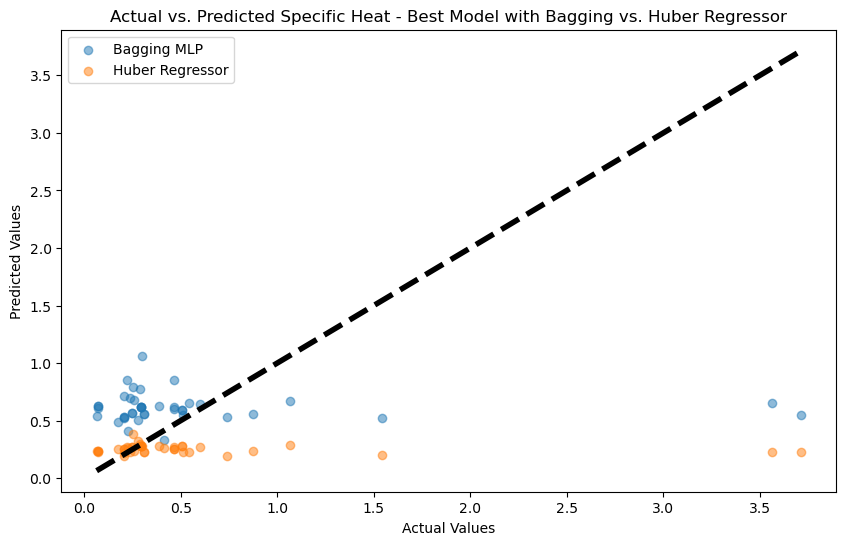

In [83]:
# Retrain the best model with Bagging
best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
best_bagging_model.fit(X_train, y_train)
best_preds = best_bagging_model.predict(X_test)

# Initialize the Huber Regressor
huber_reg = HuberRegressor()

# Fit the model
huber_reg.fit(X_train, y_train)

# Make predictions
y_pred_huber = huber_reg.predict(X_test)

# Calculate Mean Squared Error for Huber Regressor
mse_huber = mean_squared_error(y_test, y_pred_huber)
print(f"Mean Squared Error - Huber Regressor: {mse_huber}")


# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_preds, alpha=0.5, label='Bagging MLP')
plt.scatter(y_test, y_pred_huber, alpha=0.5, label='Huber Regressor')
plt.title('Actual vs. Predicted Specific Heat - Best Model with Bagging vs. Huber Regressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.legend()
plt.show()

Spearman's rank correlation coefficient: 0.02683714803281106
P-value of the correlation coefficient: 0.8677184693776436


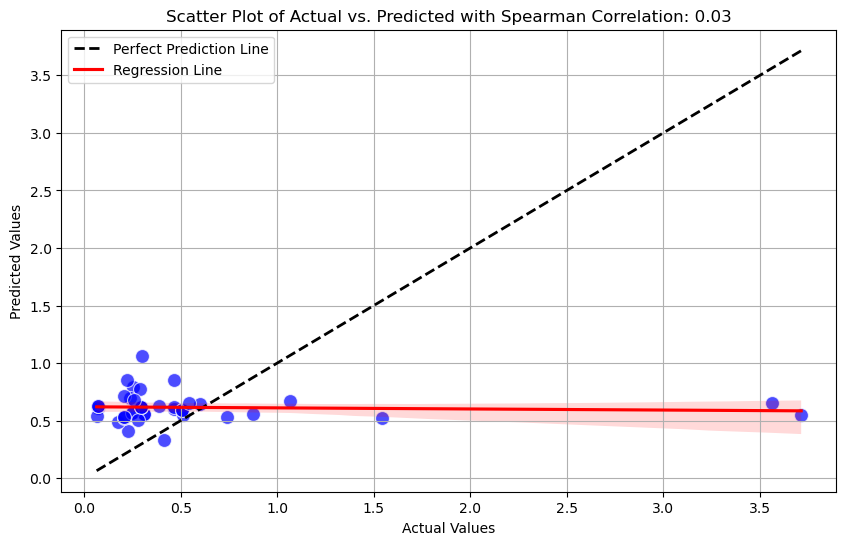

Spearman's rank correlation coefficient: -0.061136332347915934
P-value of the correlation coefficient: 0.7041585288496355


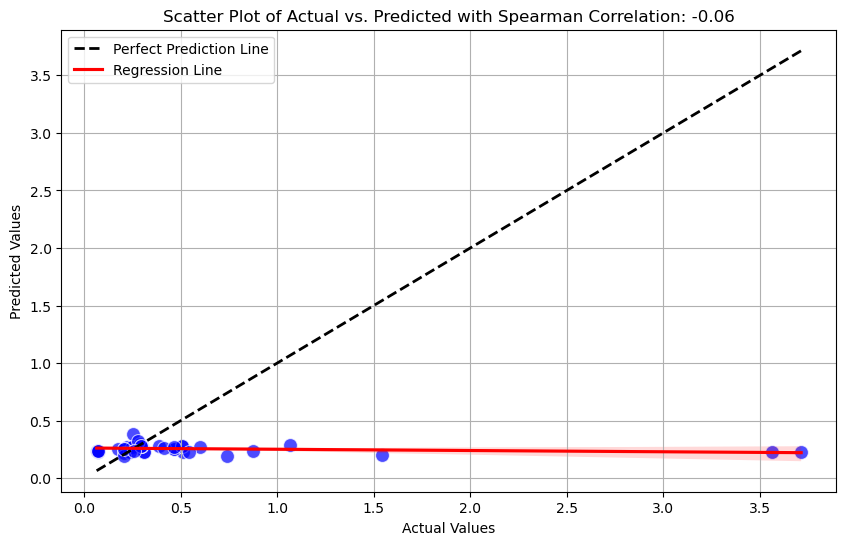

In [84]:
actuals = y_test  # Your array of actual Young's moduli
preds = best_preds   # Your array of predicted Young's moduli

rank_correlation = evaluate_rank_correlation(actuals, preds)


plot_rank_correlation(actuals, preds)

rank_correlation = evaluate_rank_correlation(actuals, y_pred_huber)
plot_rank_correlation(actuals, y_pred_huber)

In [85]:
def objective_function(composition):
    # Convert the composition list to a DataFrame with appropriate column names
    composition_df = pd.DataFrame([composition], columns=X_train.columns)
    
    # Predict the Young's modulus for the given composition
    predicted_modulus = huber_reg.predict(composition_df).flatten()[0]
    
    # Calculate the diversity penalty as the variance of component proportions, excluding the first
    diversity_penalty = np.sum((np.array(composition[1:]) - np.mean(composition[1:]))**2)
    
    # Calculate the final adjusted score (negative for maximization in minimize function)
    adjusted_score = predicted_modulus

    # Return the negated adjusted score
    return -adjusted_score

In [86]:
bounds = [(75, 100)] + [(0, 100) for _ in range(1, len(X_train.columns))]
cons = ({'type': 'eq', 'fun': lambda x: 100 - np.sum(x)})

results = []
best_score = -np.inf  # Assuming maximization
best_composition = None

for i in range(25):
    # Generate initial random composition
    initial_composition_random = [75] + [np.random.rand() * 25 for _ in range(1, len(X_train.columns))]
    initial_composition_random = np.array(initial_composition_random)
    initial_composition_random *= 100 / np.sum(initial_composition_random)  # Normalize to sum to 100%

    # Perform the minimization
    result = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=cons, 
        options={'disp': True, 'maxiter': 1000}
    )

    if result.success:
        adjusted_score = -result.fun  # Convert back since we minimize the negative in objective_function
        results.append((result.x, adjusted_score))
        if adjusted_score > best_score:
            best_score = adjusted_score
            best_composition = result.x

# Output the best result found
print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

# Save results
results_path = 'Ti_model_data/heat_optimization_results.csv'
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists

with open(results_path, 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3570368924062457
            Iterations: 17
            Function evaluations: 187
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3570368924062464
            Iterations: 18
            Function evaluations: 198
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3570368924062601
            Iterations: 17
            Function evaluations: 187
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3570368924062661
            Iterations: 15
            Function evaluations: 165
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3570368924062628
            Iterations: 20
            Fun

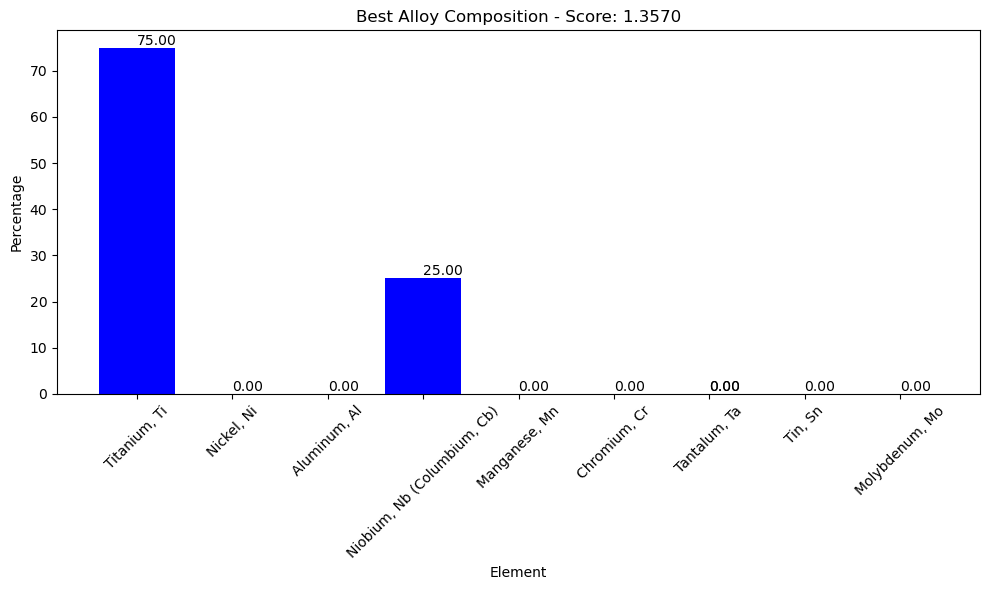

In [87]:
# Assuming we already have the best alloy and its score from the earlier setup
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

# Plot the best alloy composition along with its score
plt.figure(figsize=(10, 6))
bars = plt.bar(X.columns, best_alloy, color='blue')
plt.xlabel('Element')
plt.ylabel('Percentage')
plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
plt.xticks(rotation=45)

# Add the score to each bar in the graph
for bar, percentage in zip(bars, best_alloy):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')  # for composition percentage

plt.tight_layout()
plt.savefig('best_alloy_composition_with_score.png')
plt.show()

## Coefficient of Thermal Expansion

### Data Preperation

In [88]:
# Assuming df1 is your DataFrame and it contains the columns 'Coefficient of Thermal Expansion''
df['Coefficient of Thermal Expansion'] = df['Coefficient of Thermal Expansion'].apply(extract_numeric)

# List all columns to keep (metal percentages and Coefficient of Thermal Expansion)
columns_to_keep = ['Coefficient of Thermal Expansion'] + [col for col in df.columns if ',' in col]

# Create a new dataframe with only these columns
metals_and_thermalE = df[columns_to_keep]

# Check for missing values in the new dataset
missing_values_metals = metals_and_thermalE.isnull().sum()
missing_values_metals[missing_values_metals > 0], metals_and_thermalE.head()

(Series([], dtype: int64),
    Coefficient of Thermal Expansion  Aluminum, Al  Carbon, C  Hydrogen, H  \
 0                          2.448837           3.4       0.05        0.015   
 1                          0.844828           3.0       0.05        0.015   
 2                          0.844828           0.0       0.00        0.020   
 3                          0.725015           2.7       0.08        0.015   
 4                          1.625421           3.0       0.00        0.000   
 
    Iron, Fe  Nitrogen, N  Oxygen, O  Titanium, Ti  Vanadium, V  \
 0      1.60         0.05       0.13        82.855          9.0   
 1      2.00         0.00       0.10        79.000          8.0   
 2      0.35         0.05       0.20        80.000          0.0   
 3      0.20         0.05       0.15        75.000         13.0   
 4      0.00         0.00       0.00        94.500          2.5   
 
    Molybdenum, Mo  ...  Yttrium, Y  Zirconium, Zr  Chromium, Cr  Silicon, Si  \
 0             0.0

In [89]:
# Splitting the dataset into features and target variable
X = metals_and_thermalE.drop('Coefficient of Thermal Expansion', axis=1)
y = metals_and_thermalE['Coefficient of Thermal Expansion']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head(), y_train.head()

(     Aluminum, Al  Carbon, C  Hydrogen, H  Iron, Fe  Nitrogen, N  Oxygen, O  \
 198       6.83600   0.082900     0.013490  0.362700     0.074200   0.161000   
 38        7.82150   0.069100     0.014880  0.290000     0.050000   0.142800   
 24        6.29600   0.060000     0.013730  0.232400     0.050000   0.150400   
 122       6.68391   0.067627     0.027655  0.430395     0.073237   0.156627   
 196       6.10700   0.067300     0.014965  0.366200     0.047500   0.179000   
 
      Titanium, Ti  Vanadium, V  Molybdenum, Mo  Nickel, Ni  ...  Yttrium, Y  \
 198     87.075290       2.1800         1.80850         0.0  ...         0.0   
 38      86.366270       1.3350         1.07850         0.0  ...         0.0   
 24      87.983030       0.0000         1.52300         0.0  ...         0.0   
 122     86.415666       2.6961         2.13013         0.0  ...         0.0   
 196     88.600010       2.8975         0.24250         0.0  ...         0.0   
 
      Zirconium, Zr  Chromium, Cr  S

### Feature Selection

#### Random Forest Feature Importance

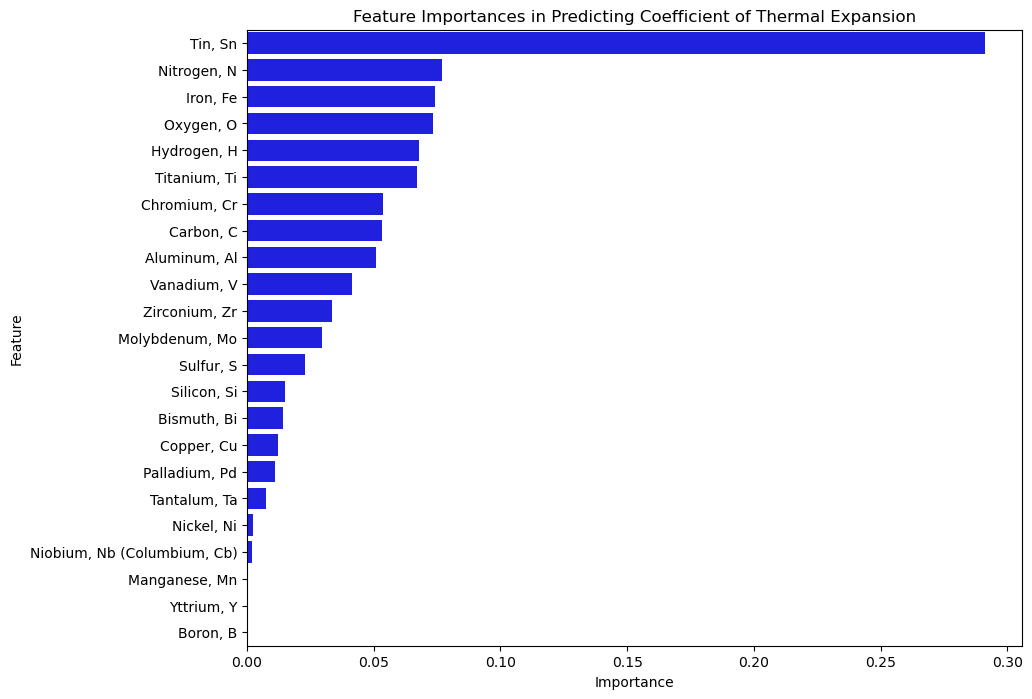

In [90]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)

# Get feature importances from the Random Forest model
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization of feature importances
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

rf_mse, features_importance_df

features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# Use seaborn to plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_importance_df, color='blue')
plt.title('Feature Importances in Predicting Coefficient of Thermal Expansion')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Combination Neural Network Feature Combination Importance

In [91]:
# Assuming metals_and_thermalE is preloaded with the relevant data
top_features = ['Iron, Fe', 'Silicon, Si', 'Nitrogen, N', 'Vanadium, V', 'Molybdenum, Mo', 'Chromium, Cr', 'Zirconium, Zr', 'Aluminum, Al', 'Tin, Sn', 'Oxygen, O', 'Niobium, Nb (Columbium, Cb)']
fixed_feature = 'Titanium, Ti'
X = metals_and_thermalE[top_features + [fixed_feature]]
y = metals_and_thermalE["Coefficient of Thermal Expansion"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_3_features_thermalE.csv'

if os.path.exists(file_path):
    print("Loading existing results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(ast.literal_eval)
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("Processing new combinations...")
    mse_scores = {}
    full_combinations = [combo + (fixed_feature,) for combo in combinations(top_features, 2)]
    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    best_combination = min(mse_scores, key=mse_scores.get)

# Define and train the neural network with the best combination
nn_model = Sequential([
    Dense(3, input_dim=3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

print(f"Best combination including Aluminum: {best_combination}, MSE: {results_df['MSE'].min()}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', marker='o', alpha=0.5, label='Predicted Values')  # Predicted values as blue circles
plt.scatter(y_test, y_test, color='red', marker='x', label='Actual Values')  # Actual values as red x's
plt.title("Actual vs. Predicted Coefficient of Thermal Expansion Values (3 Variables)")
plt.xlabel("Actual Coefficient of Thermal Expansion")
plt.ylabel("Predicted Coefficient of Thermal Expansion")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='Ideal Prediction Line')  # Ideal prediction line
plt.legend()  # Add a legend to clarify the plot symbols
plt.show()

Processing new combinations...
Processing combination: ('Iron, Fe', 'Silicon, Si', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Vanadium, V', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Chromium, Cr', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Zirconium, Zr', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Tin, Sn', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Oxygen, O', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Niobium, Nb (Columbium, Cb)', 'Titanium, Ti')
Processing combination: ('Silicon, Si', 'Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Silicon, Si', 'Vanadium, V', 'Titanium, Ti')
Processing combination: ('Silicon, Si', 'Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Silicon, Si', 'Chromium, Cr', 

In [92]:
# Assuming metals_and_thermalE is preloaded with the relevant data, rename it appropriately if it contains yield strength
top_features = ['Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']
fixed_feature = 'Titanium, Ti'

# Exclude fixed feature if it's accidentally included in top_features
top_features = [feat for feat in top_features if feat != fixed_feature]

# Assuming the DataFrame name that contains 'Yield Strength'
X = metals_and_thermalE[top_features + [fixed_feature]]
y = metals_and_thermalE["Coefficient of Thermal Expansion"]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

file_path = 'Ti_model_data/mse_scores_with_titanium_2_features_thermalE.csv'

# Load or process data
if os.path.exists(file_path):
    print("Results file already exists. Loading results...")
    results_df = pd.read_csv(file_path)
    results_df['Combination'] = results_df['Combination'].apply(lambda x: ast.literal_eval(x))
    best_combination = results_df.loc[results_df['MSE'].idxmin(), 'Combination']
else:
    print("No results file found. Processing new combinations...")
    full_combinations = [(feat, fixed_feature) for feat in top_features]
    mse_scores = {}

    for combo in full_combinations:
        print(f'Processing combination: {combo}')
        X_train_sub = X_train[list(combo)]
        X_test_sub = X_test[list(combo)]

        nn_model = Sequential([
            Dense(3, input_dim=2, activation='relu'),
            Dense(3, activation='relu'),
            Dense(3, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        nn_model.fit(X_train_sub, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
        mse = nn_model.evaluate(X_test_sub, y_test, verbose=0)
        mse_scores[combo] = mse

    results_df = pd.DataFrame(list(mse_scores.items()), columns=['Combination', 'MSE'])
    results_df.to_csv(file_path, index=False)
    print("Results saved to", file_path)
    best_combination = tuple(results_df.loc[results_df['MSE'].idxmin(), 'Combination'])

print(f"Best combination including Aluminum: {best_combination}, MSE: {results_df['MSE'].min()}")

# Define and train the neural network with the best combination
nn_model = Sequential([
    Dense(3, input_dim=2, activation='relu'),
    Dense(3, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
nn_model.fit(X_train[list(best_combination)], y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
y_pred = nn_model.predict(X_test[list(best_combination)]).flatten()

print(f"Best combination including Aluminum: {best_combination}, MSE: {results_df['MSE'].min()}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', marker='o', alpha=0.5, label='Predicted Values')  # Predicted values as blue circles
plt.scatter(y_test, y_test, color='red', marker='x', label='Actual Values')  # Actual values as red x's
plt.title("Actual vs. Predicted Coefficient of Thermal Expansion Values (2 Variables)")
plt.xlabel("Actual Coefficient of Thermal Expansion")
plt.ylabel("Predicted Coefficient of Thermal Expansion")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='Ideal Prediction Line')  # Ideal prediction line
plt.legend()  # Add a legend to clarify the plot symbols
plt.show()

No results file found. Processing new combinations...
Processing combination: ('Aluminum, Al', 'Titanium, Ti')
Processing combination: ('Carbon, C', 'Titanium, Ti')
Processing combination: ('Hydrogen, H', 'Titanium, Ti')
Processing combination: ('Iron, Fe', 'Titanium, Ti')
Processing combination: ('Nitrogen, N', 'Titanium, Ti')
Processing combination: ('Oxygen, O', 'Titanium, Ti')
Processing combination: ('Vanadium, V', 'Titanium, Ti')
Processing combination: ('Molybdenum, Mo', 'Titanium, Ti')
Processing combination: ('Nickel, Ni', 'Titanium, Ti')
Processing combination: ('Sulfur, S', 'Titanium, Ti')
Processing combination: ('Boron, B', 'Titanium, Ti')
Processing combination: ('Tin, Sn', 'Titanium, Ti')
Processing combination: ('Yttrium, Y', 'Titanium, Ti')
Processing combination: ('Zirconium, Zr', 'Titanium, Ti')
Processing combination: ('Chromium, Cr', 'Titanium, Ti')
Processing combination: ('Silicon, Si', 'Titanium, Ti')
Processing combination: ('Palladium, Pd', 'Titanium, Ti')
Pro

#### Correlation Matrix 

Tin, Sn                        0.279341
Silicon, Si                    0.130263
Nitrogen, N                    0.120178
Iron, Fe                       0.098540
Chromium, Cr                   0.070016
Palladium, Pd                  0.068935
Zirconium, Zr                  0.064123
Hydrogen, H                    0.063062
Titanium, Ti                   0.043761
Molybdenum, Mo                 0.016782
Sulfur, S                      0.008552
Niobium, Nb (Columbium, Cb)    0.005017
Tantalum, Ta                  -0.010073
Vanadium, V                   -0.025103
Aluminum, Al                  -0.025951
Yttrium, Y                    -0.067289
Boron, B                      -0.067289
Manganese, Mn                 -0.069121
Bismuth, Bi                   -0.074971
Nickel, Ni                    -0.075481
Oxygen, O                     -0.081338
Copper, Cu                    -0.086415
Carbon, C                     -0.088605
Name: Coefficient of Thermal Expansion, dtype: float64


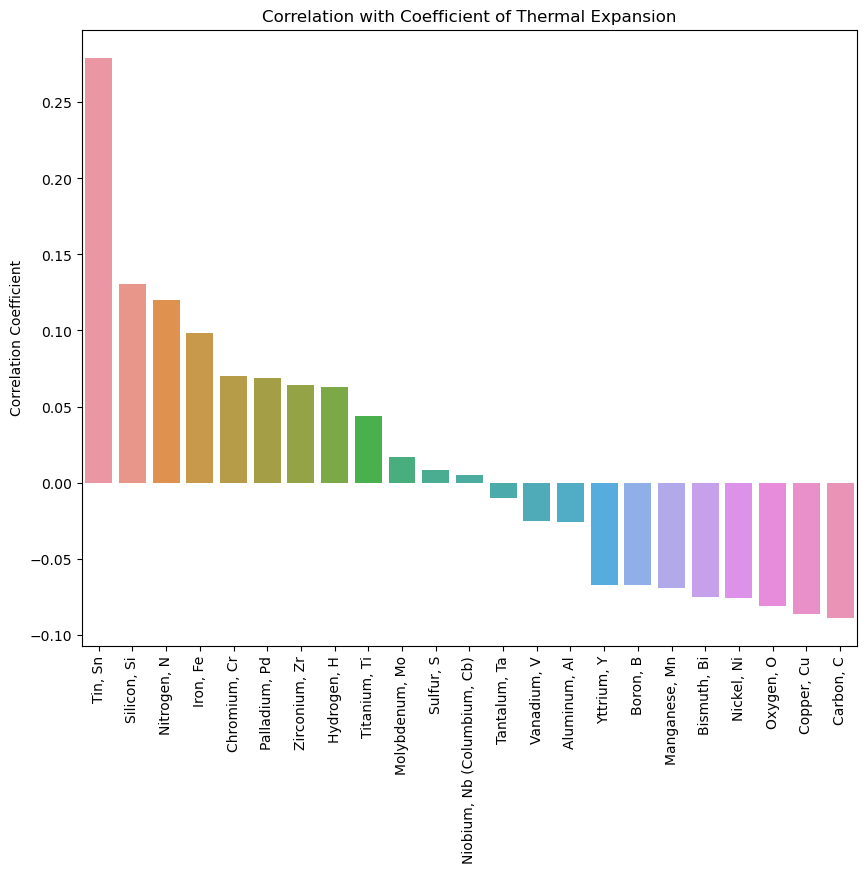

In [93]:
# Calculate correlation matrix including 'Coefficient of Thermal Expansion'
corr_matrix = metals_and_thermalE.corr()

# Isolate the correlation of 'Coefficient of Thermal Expansion' with other features
thermalE_corr = corr_matrix["Coefficient of Thermal Expansion"].drop("Coefficient of Thermal Expansion").sort_values(ascending=False)

# Print the correlation values
print(thermalE_corr)

# Visualize correlations using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=thermalE_corr.index, y=thermalE_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation with Coefficient of Thermal Expansion")
plt.ylabel("Correlation Coefficient")
plt.show()

#### Regression

                          Metal  Coefficient     Effect
0                  Titanium, Ti     0.004545  Increases
1                  Aluminum, Al    -0.008353  Decreases
2                     Carbon, C    -1.689287  Decreases
3                   Hydrogen, H     3.261156  Increases
4                      Iron, Fe     0.180919  Increases
5                   Nitrogen, N     2.165890  Increases
6                     Oxygen, O    -0.988939  Decreases
7                   Vanadium, V    -0.004448  Decreases
8                Molybdenum, Mo    -0.005992  Decreases
9                    Nickel, Ni    -0.011637  Decreases
10                      Tin, Sn     0.011180  Increases
11                Zirconium, Zr     0.024395  Increases
12                 Chromium, Cr    -0.018113  Decreases
13                  Silicon, Si     1.222352  Increases
14                Palladium, Pd     2.180127  Increases
15                 Tantalum, Ta    -0.003332  Decreases
16  Niobium, Nb (Columbium, Cb)     0.007718  In

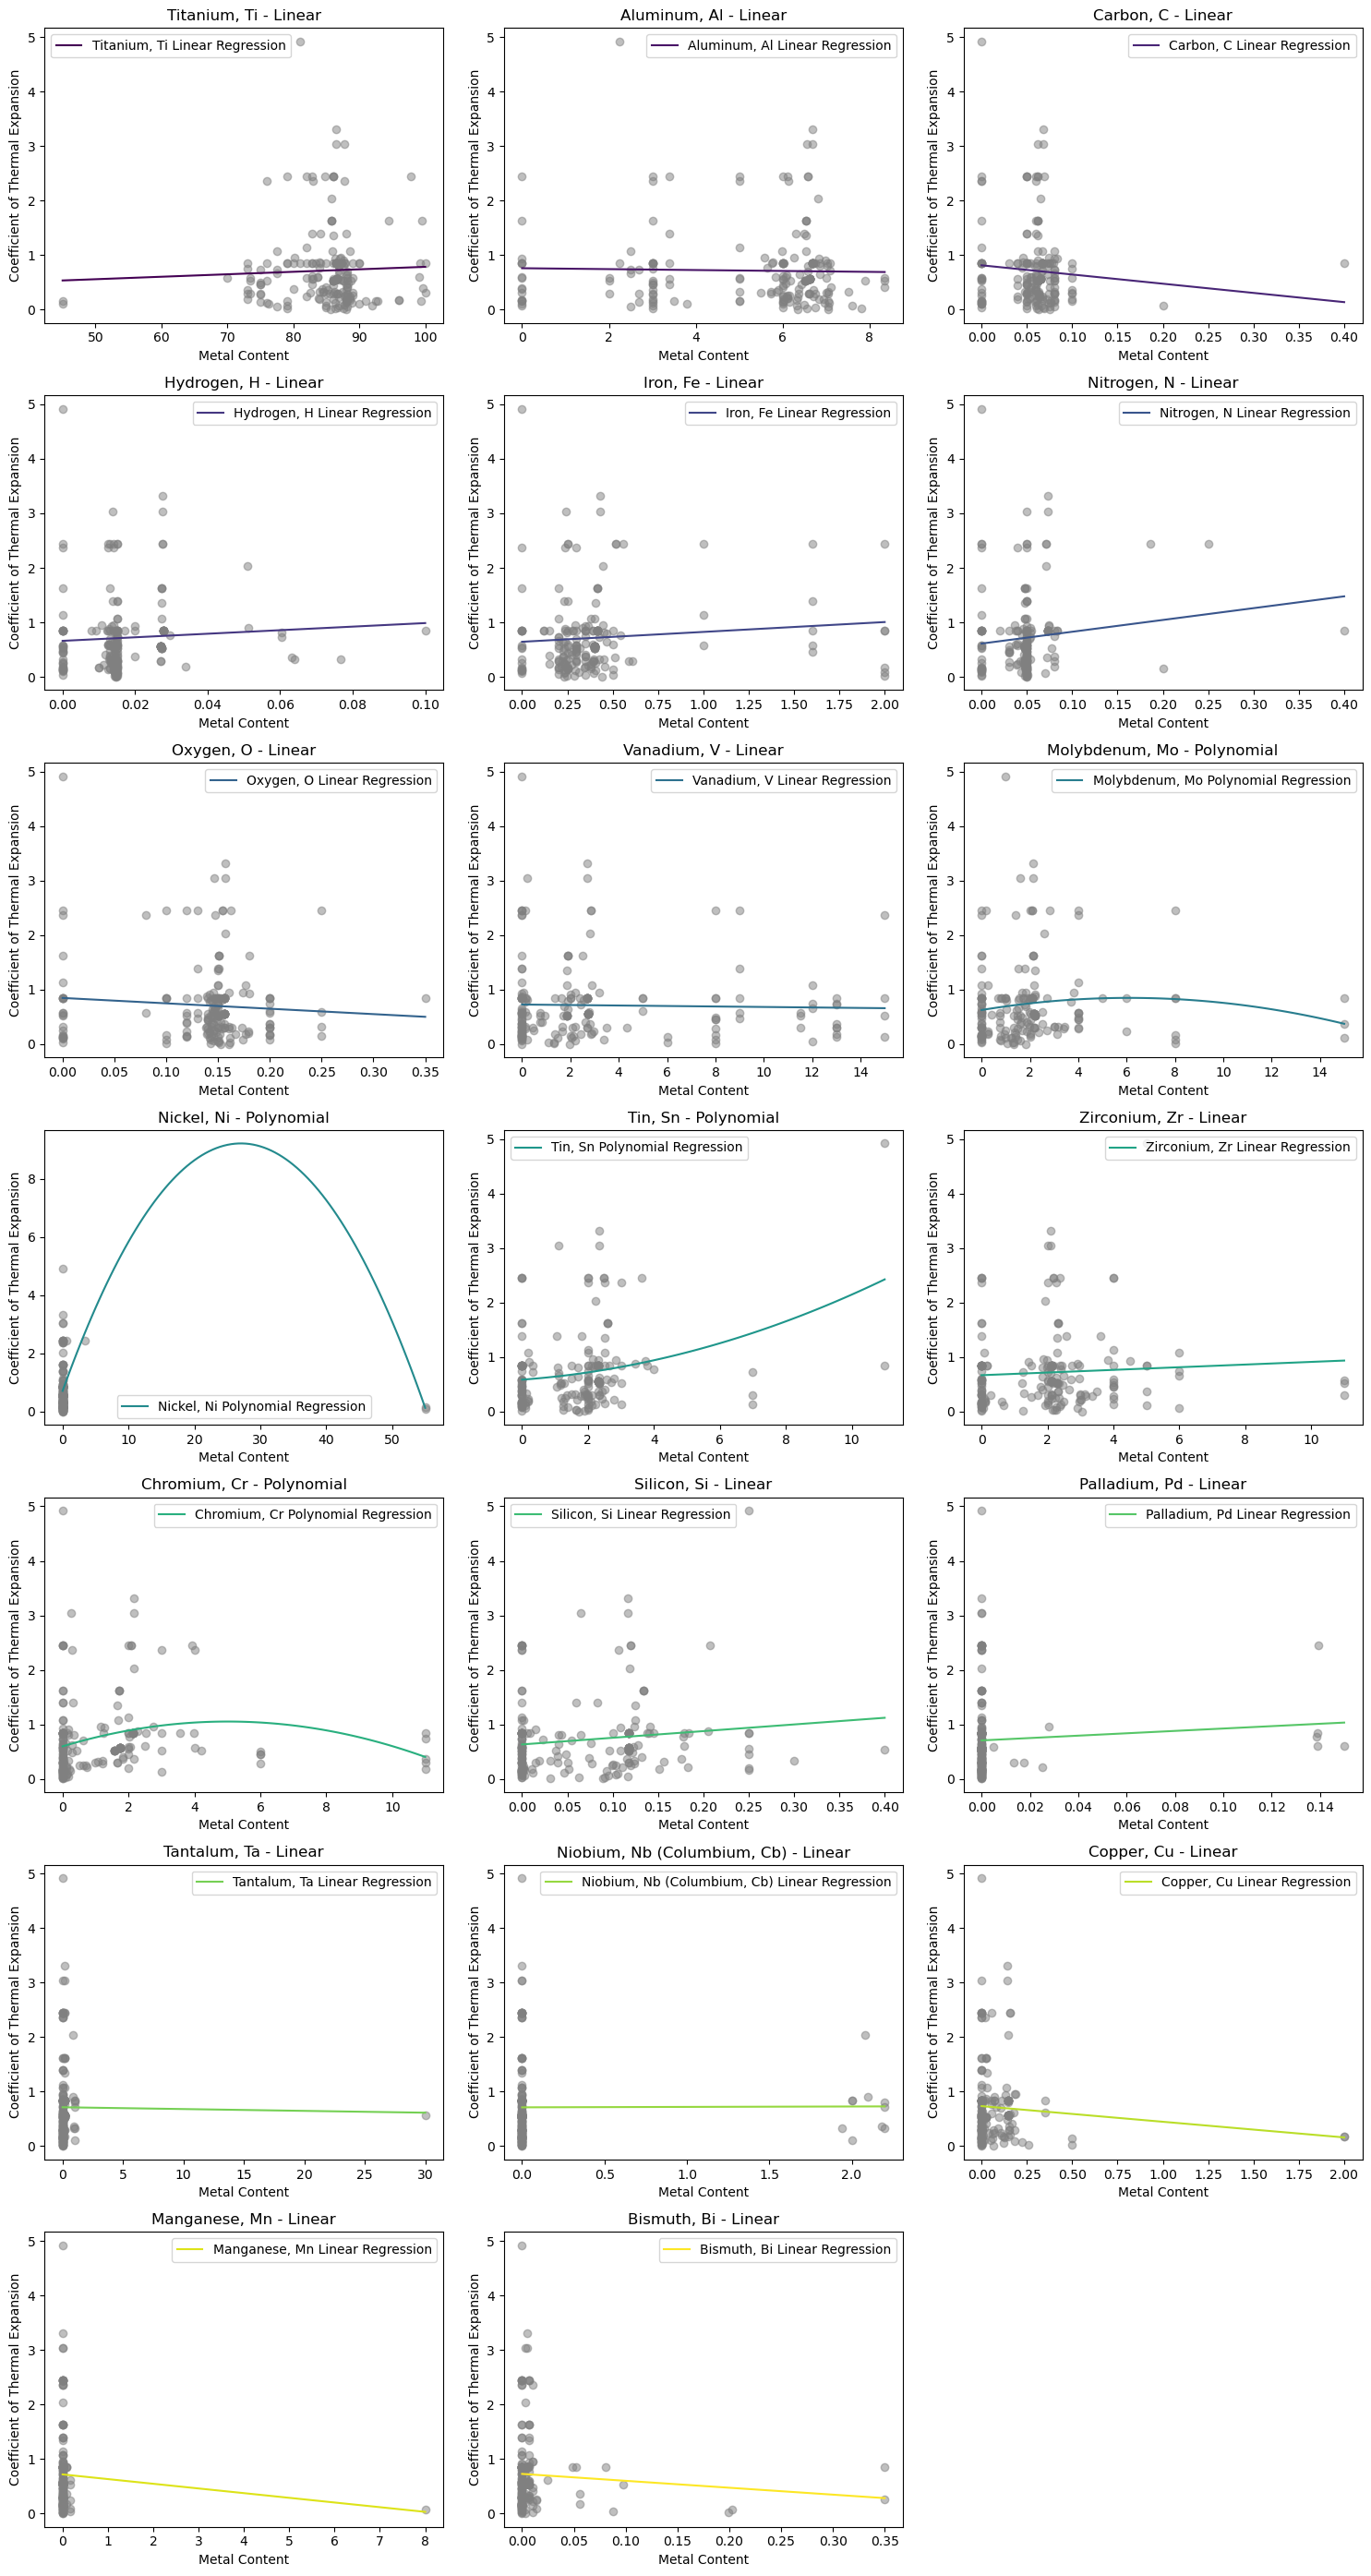

In [94]:
metals = ['Titanium, Ti', 'Aluminum, Al', 'Carbon, C', 'Hydrogen, H',
       'Iron, Fe', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V',
       'Molybdenum, Mo', 'Nickel, Ni', 'Sulfur, S', 'Boron, B', 'Tin, Sn',
       'Yttrium, Y', 'Zirconium, Zr', 'Chromium, Cr', 'Silicon, Si',
       'Palladium, Pd', 'Tantalum, Ta', 'Niobium, Nb (Columbium, Cb)',
       'Copper, Cu', 'Manganese, Mn', 'Bismuth, Bi']

models = {}
linear_vs_poly = {}
impact_summary = pd.DataFrame(columns=['Metal', 'Coefficient', 'Effect'])

for metal in metals:
    
    if metals_and_thermalE[metal].max() < 0.1:
        continue  # Skip metals where the maximum content is less than 0.01
        
    # Check if the maximum metal content is <= 1 to decide the model type
    if metals_and_thermalE[metal].max() <= 1:
        model = evaluate_feature(metals_and_thermalE, metal, "Coefficient of Thermal Expansion", 1)
        linear_vs_poly[metal] = 'Linear'
    else:
        linear_model = evaluate_feature(metals_and_thermalE, metal, "Coefficient of Thermal Expansion", 1)
        poly_model = evaluate_feature(metals_and_thermalE, metal, "Coefficient of Thermal Expansion", 2)
        
        if linear_model.aic < poly_model.aic:
            model = linear_model
            linear_vs_poly[metal] = 'Linear'
        else:
            model = poly_model
            linear_vs_poly[metal] = 'Polynomial'
    
    models[metal] = model
    coeff = model.params[1 if linear_vs_poly[metal] == 'Linear' else 2]
    effect = 'Increases' if coeff > 0 else 'Decreases'

    new_row = pd.DataFrame({'Metal': [metal], 'Coefficient': [coeff], 'Effect': [effect]})
    impact_summary = pd.concat([impact_summary, new_row], ignore_index=True)

print(impact_summary)
# Visualization setup and plotting
cols=3
cols, rows = 3, (len(models) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()
for idx, metal in enumerate(models):
    ax = axes[idx]
    model = models[metal]
    X = np.linspace(metals_and_thermalE[metal].min(), metals_and_thermalE[metal].max(), 100).reshape(-1, 1)
    preds = model.predict(sm.add_constant(PolynomialFeatures(1 if linear_vs_poly[metal] == 'Linear' else 2).fit_transform(X)))
    ax.plot(X.flatten(), preds, label=f'{metal} {linear_vs_poly[metal]} Regression', color=plt.cm.viridis(np.linspace(0, 1, len(models)))[idx])
    ax.scatter(metals_and_thermalE[metal], metals_and_thermalE["Coefficient of Thermal Expansion"], color='gray', alpha=0.5)
    ax.set(title=f'{metal} - {linear_vs_poly[metal]}', xlabel='Metal Content', ylabel="Coefficient of Thermal Expansion")
    ax.legend()

# Turn off axes for any empty subplots
for i in range(idx + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

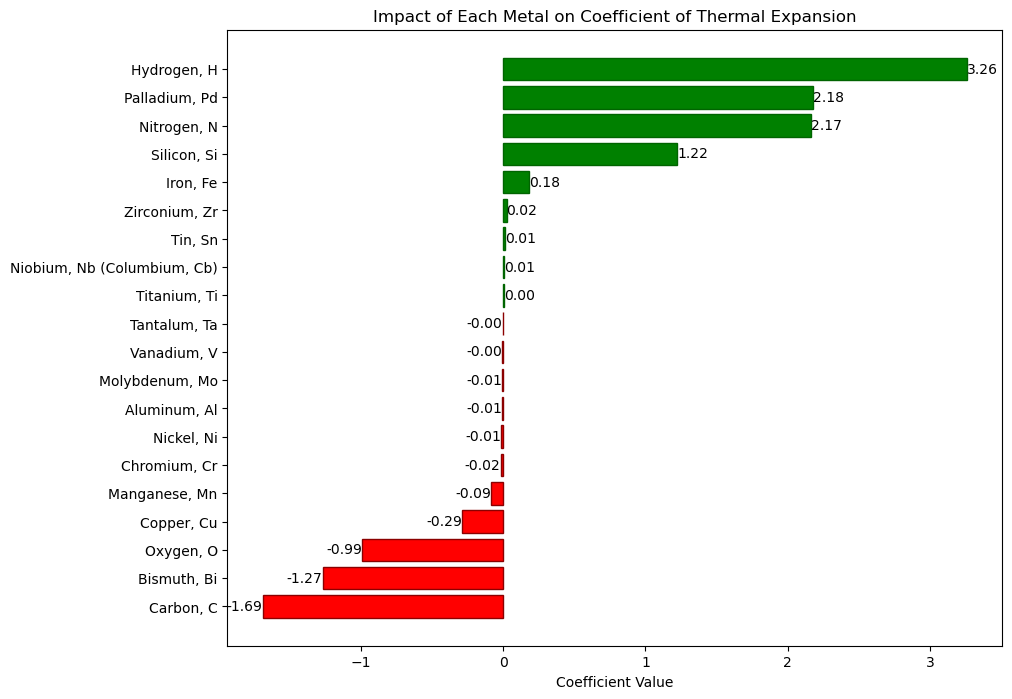

                          Metal  Coefficient     Effect
3                   Hydrogen, H     3.261156  Increases
14                Palladium, Pd     2.180127  Increases
5                   Nitrogen, N     2.165890  Increases
13                  Silicon, Si     1.222352  Increases
4                      Iron, Fe     0.180919  Increases
11                Zirconium, Zr     0.024395  Increases
10                      Tin, Sn     0.011180  Increases
16  Niobium, Nb (Columbium, Cb)     0.007718  Increases
0                  Titanium, Ti     0.004545  Increases
15                 Tantalum, Ta    -0.003332  Decreases
7                   Vanadium, V    -0.004448  Decreases
8                Molybdenum, Mo    -0.005992  Decreases
1                  Aluminum, Al    -0.008353  Decreases
9                    Nickel, Ni    -0.011637  Decreases
12                 Chromium, Cr    -0.018113  Decreases
18                Manganese, Mn    -0.085912  Decreases
17                   Copper, Cu    -0.287315  De

In [95]:
# Splitting the DataFrame into positive and negative subsets
positive_df = impact_summary[impact_summary['Coefficient'] > 0].copy()
negative_df = impact_summary[impact_summary['Coefficient'] < 0].copy()

# Sorting each subset
positive_df.sort_values(by='Coefficient', ascending=False, inplace=True)
negative_df.sort_values(by='Coefficient', ascending=False, inplace=True)  # Sort negatives in descending order by value

# Concatenating back into a single DataFrame
sorted_impact_summary = pd.concat([positive_df, negative_df], axis=0)

# Define colors based on coefficient sign and set edge colors for better visibility
colors = ['green' if x > 0 else 'red' for x in sorted_impact_summary['Coefficient']]
edge_colors = ['darkgreen' if x > 0 else 'darkred' for x in sorted_impact_summary['Coefficient']]

# Set up the plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_impact_summary['Metal'], sorted_impact_summary['Coefficient'], color=colors, edgecolor=edge_colors)
plt.xlabel('Coefficient Value')
plt.title('Impact of Each Metal on Coefficient of Thermal Expansion')

# Invert y-axis to have the largest impact at the top
plt.gca().invert_yaxis()

# Add text labels to bars for exact coefficient values
for bar, value in zip(bars, sorted_impact_summary['Coefficient']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', 
             ha='right' if value < 0 else 'left')

# Show the plot
plt.show()

# Optionally, print the DataFrame for a tabular view
print(sorted_impact_summary[['Metal', 'Coefficient', 'Effect']])

### <span style="color:lime">Optimizing Thermal Expansion</span>

#### <span style="color:red">Random Forest</span>

In [96]:
selected_features = ['Titanium, Ti', 'Silicon, Si', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V', 'Chromium, Cr', 'Molybdenum, Mo', 'Tin, Sn', 'Zirconium, Zr', 'Nickel, Ni']
target_variable = 'Coefficient of Thermal Expansion'

# Split the data into training and testing sets
X = df[selected_features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting the Coefficient of Thermal Expansion using the trained model
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Find the maximum predicted Coefficient of Thermal Expansion
max_thermalE = max(y_pred)

mse, rmse, max_thermalE

(0.3703491721210634, 0.6085632030619855, 2.3866332752134913)

In [97]:
# Finding the index of the maximum predicted Coefficient of Thermal Expansion
index_max_thermalE = y_pred.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test.iloc[index_max_thermalE]

strongest_composition

Titanium, Ti      86.415666
Silicon, Si        0.117054
Nitrogen, N        0.073237
Oxygen, O          0.156627
Vanadium, V        2.696100
Chromium, Cr       2.160200
Molybdenum, Mo     2.130130
Tin, Sn            2.331660
Zirconium, Zr      2.094250
Nickel, Ni         0.000000
Name: 115, dtype: float64

In [98]:
# Filtering the dataset to ensure Aluminum content is between 75% and 100%
filtered_data = df[(df['Titanium, Ti'] >= 75) & (df['Titanium, Ti'] <= 100)]

# Split the filtered data into training and testing sets
X_filtered = filtered_data[selected_features]
y_filtered = filtered_data[target_variable]
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor on the filtered data
rf_model_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_filtered.fit(X_train_filtered, y_train_filtered)

# Predicting the Coefficient of Thermal Expansion using the trained model on filtered data
y_pred_filtered = rf_model_filtered.predict(X_test_filtered)

# Evaluate the model on filtered data
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
rmse_filtered = mse_filtered ** 0.5

# Find the maximum predicted Coefficient of Thermal Expansion on filtered data
max_thermalE_filtered = max(y_pred_filtered)

mse_filtered, rmse_filtered, max_thermalE_filtered

(0.16698998234291898, 0.4086440778268039, 2.0493986812700182)

In [99]:
# Finding the index of the maximum predicted Coefficient of Thermal Expansion
index_max_thermalE = y_pred_filtered.argmax()

# Retrieve the corresponding metal percentages from the test set
strongest_composition = X_test_filtered.iloc[index_max_thermalE]

strongest_composition

Titanium, Ti      86.032843
Silicon, Si        0.119993
Nitrogen, N        0.070616
Oxygen, O          0.154758
Vanadium, V        2.862375
Chromium, Cr       2.081350
Molybdenum, Mo     2.080540
Tin, Sn            2.484470
Zirconium, Zr      2.178420
Nickel, Ni         0.000000
Name: 109, dtype: float64

In [100]:
# File path for the output CSV
output_file_path = "Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_thermalE.csv"

# Check if the output file already exists
if os.path.exists(output_file_path):
    # Read the existing results
    hypothetical_results = pd.read_csv(output_file_path)
    print("Loaded results from existing file.")
else:
    # Define the increments for Aluminum and the other metals
    al_increments = np.arange(75, 101, 5)  # Correct range for Aluminum from 75% to 100%
    other_increments = np.arange(0, 26, 5)  # Other metals must sum up to fill the remaining percentage
    metals = ['Silicon, Si', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V', 'Chromium, Cr', 'Molybdenum, Mo', 'Tin, Sn', 'Zirconium, Zr', 'Nickel, Ni']
    
    # Generate all valid combinations where the total percentage is 100
    valid_combinations = []
    for al_percent in al_increments:
        for combo in product(other_increments, repeat=len(metals)):
            if sum(combo) == (100 - al_percent):
                valid_combinations.append((al_percent,) + combo)
    # Convert the list of combinations into a DataFrame
    hypothetical_metals_df = pd.DataFrame(valid_combinations, columns=['Titanium, Ti'] + metals)
    
    # Assuming rf_model is already trained and available
    # Predict Coefficient of Thermal Expansion for these hypothetical alloys
    hypothetical_thermalE = rf_model.predict(hypothetical_metals_df)
    
    # Combining the compositions and their predicted Coefficient of Thermal Expansion
    hypothetical_results = hypothetical_metals_df.copy()
    hypothetical_results['Predicted Coefficient of Thermal Expansion'] = hypothetical_thermalE
    
    # Save all combinations and their predicted Coefficient of Thermal Expansion to a CSV file
    hypothetical_results.to_csv("Ti_model_data/all_hypothetical_combinations_with_predictions_titanium_thermalE.csv", index=False)
    print("Predictions performed and results saved.")
    
    # Find the top 10 combinations with the highest predicted Coefficient of Thermal Expansion
top_10_thermalE_combinations = hypothetical_results.nlargest(10, 'Predicted Coefficient of Thermal Expansion')
    
# Print the top 10 combinations
print("Top 10 Coefficient of Thermal Expansion Combinations:")
print(top_10_thermalE_combinations.head(10))  # Print only the top 5 of these top 10

Loaded results from existing file.
Top 10 Coefficient of Thermal Expansion Combinations:
      Titanium, Ti  Silicon, Si  Nitrogen, N  Oxygen, O  Vanadium, V  \
1910            85            5            0          0            0   
946             75            5            0          5            0   
855             75            5            0          0            0   
1030            75            5            5          0            0   
1066            75            5            5          5            0   
1645            80            5            0          0            0   
840             75            5            0          0            0   
845             75            5            0          0            0   
1150            75           10            0          0            0   
890             75            5            0          0            5   

      Chromium, Cr  Molybdenum, Mo  Tin, Sn  Zirconium, Zr  Nickel, Ni  \
1910             0               5        5 

#### <span style="color:red">MLP</span>

In [101]:
# Assuming metals_and_thermalE is preloaded with the relevant data
X = metals_and_thermalE[['Titanium, Ti', 'Silicon, Si', 'Nitrogen, N', 'Oxygen, O', 'Vanadium, V', 'Chromium, Cr', 'Molybdenum, Mo', 'Tin, Sn', 'Zirconium, Zr', 'Nickel, Ni', 'Niobium, Nb (Columbium, Cb)', 'Aluminum, Al']]
y = metals_and_thermalE["Coefficient of Thermal Expansion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_configurations = [
    (30, 3, 1), (40, 2), (10, 10), (3, 10, 2),
    (10,), (20,), (30,), (40,), (50,),
    (8,), (8, 8), (8, 5, 2),
    (5, 5), (10, 10), (20, 5), (5, 20),
    (15, 6), (6, 6), (6, 6, 2),
    (5,), (5, 10, 2), (10, 10), (5, 10),
    (2,), (2,2), (2,2,2), (2,2,2,2)
]
max_iter_options = [2000, 3000, 4000]

# Path for the grid search results CSV
results_csv_path = 'Ti_model_data/grid_search_titanium_thermalE_results.csv'

# Check if results already exist
if os.path.exists(results_csv_path):
    # Load and print the existing results
    results_df = pd.read_csv(results_csv_path)
    # Finding the best configuration with the lowest MSE
    best_row = results_df.loc[results_df['MSE'].idxmin()]
    best_layers = ast.literal_eval(best_row['Layers'])  # Convert string back to tuple if stored as string
    best_max_iter = best_row['Max_iter']
    best_mse = best_row['MSE']
    print(f"Best Configuration: Layers={best_layers}, Max_iter={best_max_iter}, Best MSE={best_mse}")
    print("Loaded results from existing file:")
    print(results_df)
else:
    # Initialize a list to store results
    results = []
    best_mse = float('inf')
    best_configuration = None

    # Grid search over layer configurations and max_iter_options
    for layers in layer_configurations:
        for max_iter in max_iter_options:
            base_nn = MLPRegressor(hidden_layer_sizes=layers, activation='relu', solver='adam', max_iter=max_iter)
            bagging_model = BaggingRegressor(base_nn, n_estimators=10, random_state=42)
            bagging_model.fit(X_train, y_train)

            y_pred = bagging_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            # Save each configuration's MSE
            results.append({'Layers': layers, 'Max_iter': max_iter, 'MSE': mse})

            if mse < best_mse:
                best_mse = mse
                best_layers = layers
                best_max_iter = max_iter

            print(f"Configuration: Layers={layers}, Max_iter={max_iter}, MSE={mse}")

    print(f"Best Configuration: Layers={best_layers}, Max_iter={max_iter}, Best MSE={best_mse}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to CSV
    results_df.to_csv(results_csv_path, index=False)
    print("Grid search results saved.")

Best Configuration: Layers=(8, 8), Max_iter=2000, Best MSE=0.2375361662714128
Loaded results from existing file:
          Layers  Max_iter       MSE
0     (30, 3, 1)      2000  0.300700
1     (30, 3, 1)      3000  0.271635
2     (30, 3, 1)      4000  0.271635
3        (40, 2)      2000  0.294214
4        (40, 2)      3000  0.282597
..           ...       ...       ...
76     (2, 2, 2)      3000  0.280581
77     (2, 2, 2)      4000  0.280581
78  (2, 2, 2, 2)      2000  0.309757
79  (2, 2, 2, 2)      3000  0.307895
80  (2, 2, 2, 2)      4000  0.307895

[81 rows x 3 columns]


/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error - Huber Regressor: 0.5362307511200857


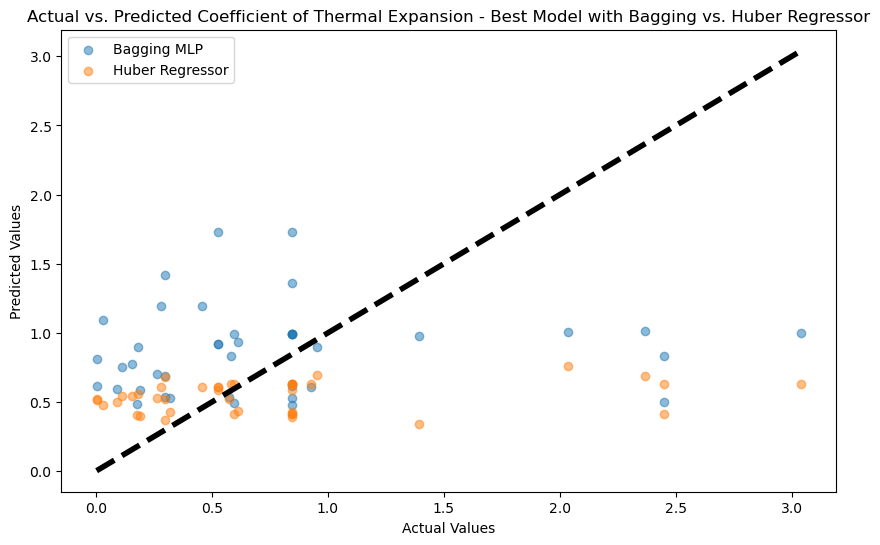

In [102]:
# Retrain the best model with Bagging
best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
best_bagging_model.fit(X_train, y_train)
best_preds = best_bagging_model.predict(X_test)

# Initialize the Huber Regressor
huber_reg = HuberRegressor()

# Fit the model
huber_reg.fit(X_train, y_train)

# Make predictions
y_pred_huber = huber_reg.predict(X_test)

# Calculate Mean Squared Error for Huber Regressor
mse_huber = mean_squared_error(y_test, y_pred_huber)
print(f"Mean Squared Error - Huber Regressor: {mse_huber}")


# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_preds, alpha=0.5, label='Bagging MLP')
plt.scatter(y_test, y_pred_huber, alpha=0.5, label='Huber Regressor')
plt.title('Actual vs. Predicted Coefficient of Thermal Expansion - Best Model with Bagging vs. Huber Regressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.legend()
plt.show()

Spearman's rank correlation coefficient: 0.18045367074611476
P-value of the correlation coefficient: 0.2588839123615769


Spearman's rank correlation coefficient: 0.31203538548496257
P-value of the correlation coefficient: 0.04702089402300739


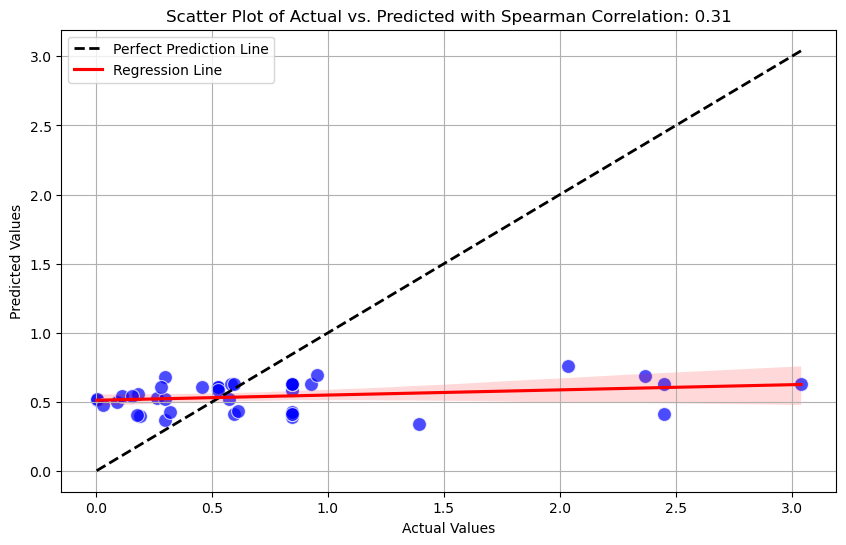

In [103]:
actuals = y_test  # Your array of actual Young's moduli
preds = best_preds   # Your array of predicted Young's moduli

rank_correlation = evaluate_rank_correlation(actuals, preds)


plot_rank_correlation(actuals, preds)

rank_correlation = evaluate_rank_correlation(actuals, y_pred_huber)
plot_rank_correlation(actuals, y_pred_huber)

In [104]:
def objective_function(composition):
    # Convert the composition list to a DataFrame with appropriate column names
    composition_df = pd.DataFrame([composition], columns=X_train.columns)
    
    # Predict the Young's modulus for the given composition
    predicted_modulus = best_bagging_model.predict(composition_df).flatten()[0]
    
    # Calculate the diversity penalty as the variance of component proportions, excluding the first
    diversity_penalty = np.sum((np.array(composition[1:]) - np.mean(composition[1:]))**2)
    
    # Calculate the final adjusted score (negative for maximization in minimize function)
    adjusted_score = predicted_modulus

    # Return the negated adjusted score
    return -adjusted_score

In [105]:
bounds = [(75, 100)] + [(0, 100) for _ in range(1, len(X_train.columns))]
cons = ({'type': 'eq', 'fun': lambda x: 100 - np.sum(x)})

results = []
best_score = -np.inf  # Assuming maximization
best_composition = None

for i in range(25):
    # Generate initial random composition
    initial_composition_random = [75] + [np.random.rand() * 25 for _ in range(1, len(X_train.columns))]
    initial_composition_random = np.array(initial_composition_random)
    initial_composition_random *= 100 / np.sum(initial_composition_random)  # Normalize to sum to 100%

    # Perform the minimization
    result = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=cons, 
        options={'disp': True, 'maxiter': 1000}
    )

    if result.success:
        adjusted_score = -result.fun  # Convert back since we minimize the negative in objective_function
        results.append((result.x, adjusted_score))
        if adjusted_score > best_score:
            best_score = adjusted_score
            best_composition = result.x

# Output the best result found
print(f"Best Composition: {best_composition}")
print(f"Best Score: {best_score}")

# Save results
results_path = 'Ti_model_data/thermalE_optimization_results.csv'
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists

with open(results_path, 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.9656539142688694
            Iterations: 28
            Function evaluations: 388
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.9789171172486477
            Iterations: 33
            Function evaluations: 448
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.9853998587884227
            Iterations: 35
            Function evaluations: 481
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.985779742022558
            Iterations: 45
            Function evaluations: 621
            Gradient evaluations: 45
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.9866396978808436
            Iterations: 39
            Func

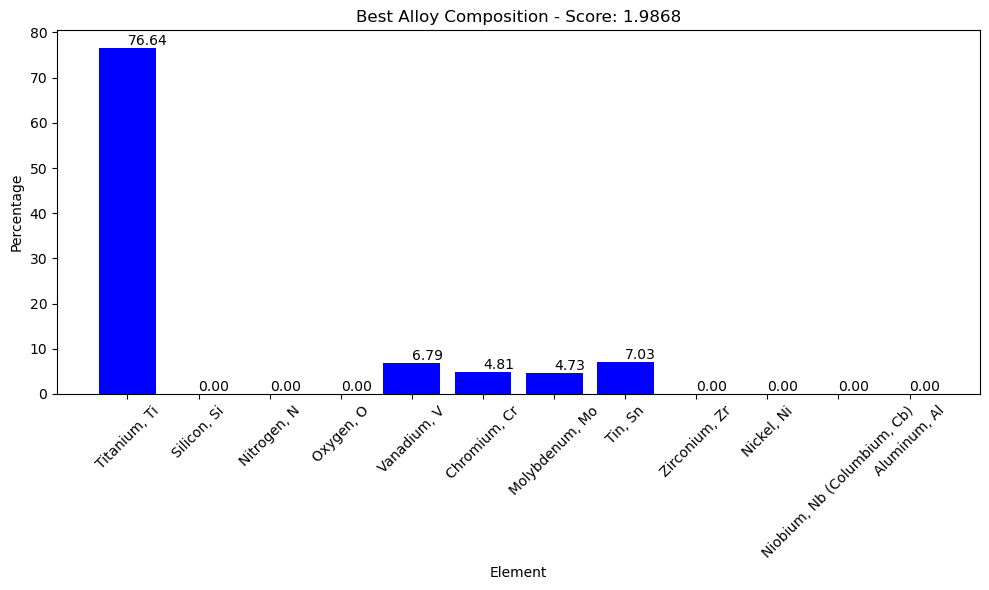

In [106]:
# Assuming we already have the best alloy and its score from the earlier setup
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

# Plot the best alloy composition along with its score
plt.figure(figsize=(10, 6))
bars = plt.bar(X.columns, best_alloy, color='blue')
plt.xlabel('Element')
plt.ylabel('Percentage')
plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
plt.xticks(rotation=45)

# Add the score to each bar in the graph
for bar, percentage in zip(bars, best_alloy):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')  # for composition percentage

plt.tight_layout()
plt.savefig('best_alloy_composition_with_score.png')
plt.show()

## Overall Best Aluminium

In [107]:
# Define target columns
target_columns = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Define input features
input_features = ['Titanium, Ti', 'Aluminum, Al', 'Nitrogen, N', 'Chromium, Cr', 'Manganese, Mn', 'Nickel, Ni', 'Oxygen, O', 'Copper, Cu', 'Niobium, Nb (Columbium, Cb)', 'Silicon, Si']  # List of input feature columns

# Select input features and targets from the DataFrame
input_data = df[input_features]
targets = df[target_columns]

# Split the data into training, validation, and test sets
train_data, test_data, train_targets, test_targets = train_test_split(input_data, targets, test_size=0.3, random_state=42)
train_data, val_data, train_targets, val_targets = train_test_split(train_data, train_targets, test_size=0.2, random_state=42)

# Output the shapes of each set to confirm the sizes
train_data.shape, val_data.shape, test_data.shape

((112, 10), (28, 10), (61, 10))

In [108]:
# Number of input features
input_dim = train_data.shape[1]

# Create the MLP model
model = Sequential([
    Dense(20, input_dim=input_dim, activation='relu'),  # First hidden layer
    Dense(5, activation='linear'),                       # Second hidden layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [109]:
model_path = 'Ti_model_data/Finalmodel.h5'  # Path where the model is saved

# Check if the model file exists
if os.path.exists(model_path):
    print("Model exists. Loading the model...")
    model = load_model(model_path)
    # Optional: Evaluate the model or continue training
else:
    print("No existing model found. Training a new model.")
    # Model training code
    history = model.fit(train_data, train_targets, epochs=350, validation_data=(val_data, val_targets))

    # Save the model after training
    model.save(model_path)
    print("Model saved at:", model_path)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Model exists. Loading the model...


In [110]:
# Assuming df is already defined and includes the necessary properties
min_values = np.array([df['Young\'s Modulus'].min(), df['Yield Strength'].min(), 
                       df['Tensile Strength'].min(), df['Specific Heat'].min(), 
                       df['Coefficient of Thermal Expansion'].min()])
max_values = np.array([df['Young\'s Modulus'].max(), df['Yield Strength'].max(), 
                       df['Tensile Strength'].max(), df['Specific Heat'].max(), 
                       df['Coefficient of Thermal Expansion'].max()])
# Print the minimum and maximum values
print("Minimum Values:", min_values)
print("Maximum Values:", max_values)

def objective_function(composition):
    composition = np.array(composition).reshape(1, -1)
    properties = model.predict(composition, verbose=0).flatten()

    # Normalize each property to the range [0, 1] based on its min and max values
    normalized_properties = (properties - min_values) / (max_values - min_values)

    # Apply weights to the normalized properties
    # Assuming properties are now correctly scaled between 0 and 1
    weighted_score = (normalized_properties[0] * 2 +
                      normalized_properties[1] +
                      normalized_properties[2] +
                      normalized_properties[3] +
                      normalized_properties[4])

    # Calculate the diversity penalty to encourage a diverse composition
    diversity_penalty = -np.sum((composition[1:] - np.mean(composition[1:]))**2)

    # The function aims to maximize the score (thus the negative sign for minimization)
    return -(weighted_score + diversity_penalty)

Minimum Values: [0.00624412 0.00229553 0.00737607 0.01017186 0.00246747]
Maximum Values: [5.18194537 2.45941952 2.48453595 5.3025987  4.91908521]


In [111]:
bounds = [(75, 100)] + [(0, 100) for _ in range(1, 10)]
cons = {'type': 'eq', 'fun': lambda x: 100 - np.sum(x)}

results = []
initial_compositions = []
final_compositions = []

for i in range(25):
    initial_composition_random = [75] + [rand()*25 for _ in range(1, 10)]
    initial_composition_random = np.array(initial_composition_random)
    initial_composition_random /= np.sum(initial_composition_random) / 100

    initial_compositions.append(initial_composition_random.copy())

    result_random = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=cons, 
        options={'disp': True, 'maxiter': 1000}
    )

    if result_random.success:
        final_compositions.append(result_random.x)
        best_score_random = -result_random.fun
        results.append((result_random.x, best_score_random))
    else:
        final_compositions.append(None)

# Save results to a text file
with open('Ti_model_data/alloy_optimization_results.txt', 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

# Find the best alloy
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukerickard/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.063194329533231
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.221140944349221
            Iterations: 6
            Function evaluations: 106
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6546695970737333
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6553725738423852
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.9438968711018936
            Iterations: 2
            Function evaluati

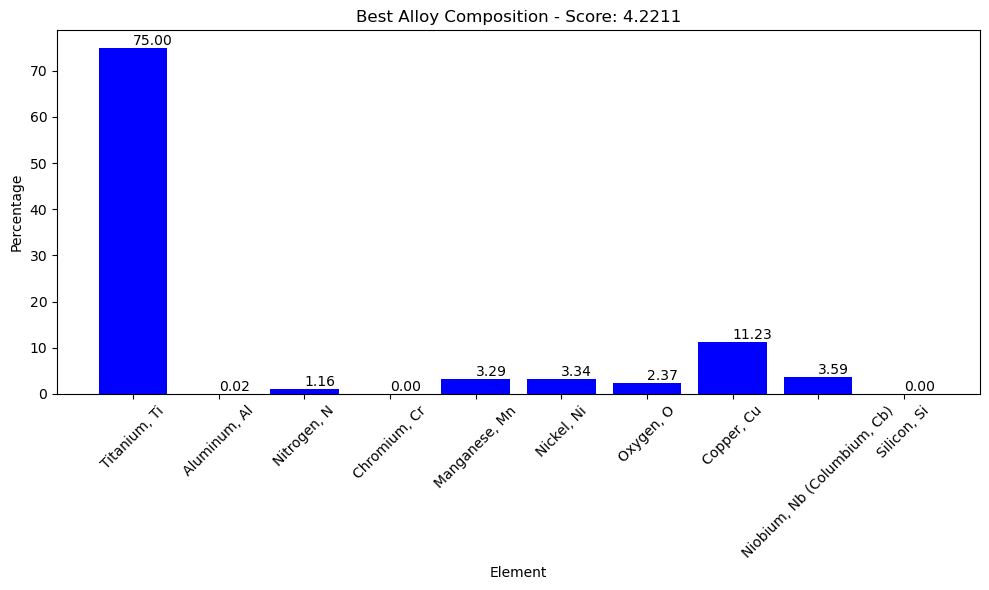

In [112]:
# Assuming we already have the best alloy and its score from the earlier setup
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

# Plot the best alloy composition along with its score
plt.figure(figsize=(10, 6))
bars = plt.bar(input_features, best_alloy, color='blue')
plt.xlabel('Element')
plt.ylabel('Percentage')
plt.title(f'Best Alloy Composition - Score: {best_score:.4f}')
plt.xticks(rotation=45)

# Add the score to each bar in the graph
for bar, percentage in zip(bars, best_alloy):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}', va='bottom')  # for composition percentage

plt.tight_layout()
plt.savefig('best_alloy_composition_with_score.png')
plt.show()


Normalized Predictions: [-0.70919406  1.7042025   4.665328    7.613364    2.4016895 ]
Min Values Used for Scaling: [0.00624412 0.00229553 0.00737607 0.01017186 0.00246747]
Max Values Used for Scaling: [5.18194537 2.45941952 2.48453595 5.3025987  4.91908521]


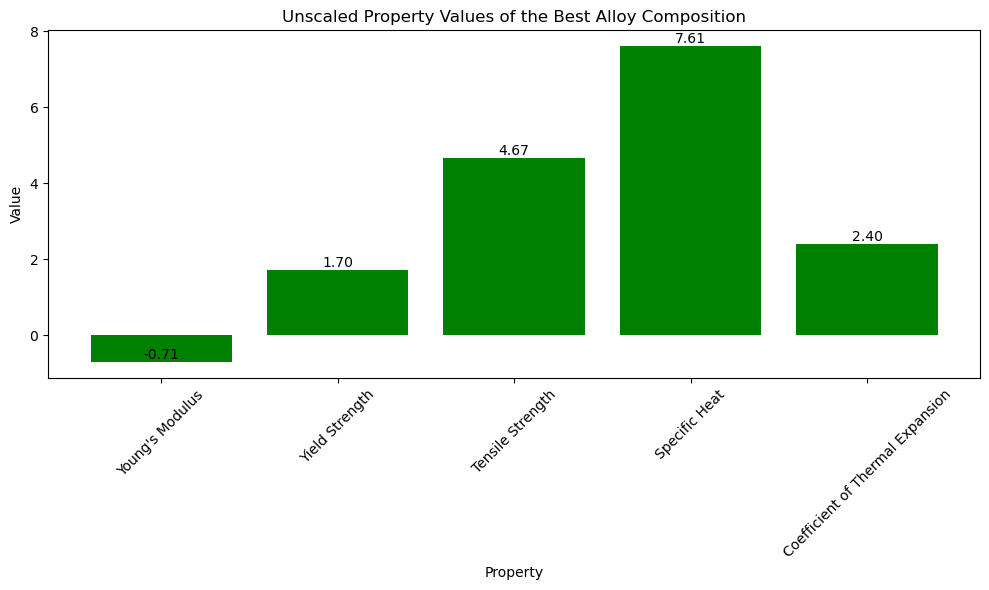

In [113]:
properties_normalized = model.predict(np.array([best_alloy]), verbose=0).flatten()
print("Normalized Predictions:", properties_normalized)  # Check the range of these values

# Print both normalized and actual values for verification
print("Min Values Used for Scaling:", min_values)
print("Max Values Used for Scaling:", max_values)


# Property names corresponding to min_values and max_values
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Plot the properties
plt.figure(figsize=(10, 6))
bars = plt.bar(property_names, properties_normalized, color='green')
plt.xlabel('Property')
plt.ylabel('Value')
plt.title('Unscaled Property Values of the Best Alloy Composition')

# Add the actual values to each bar in the graph
for bar, value in zip(bars, properties_normalized):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', va='bottom', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('unscaled_properties_of_best_alloy.png')
plt.show()

In [114]:
bounds = [(0, 100) for _ in range(10)]  # This assumes you have 10 elements total

# Constraint to ensure the total percentage is 100%
constraint = {'type': 'eq', 'fun': lambda x: 100 - np.sum(x)}

results = []
initial_compositions = []
final_compositions = []

# Perform the optimization 200 times with random initial compositions
for i in range(25):
    # Generate random values for each element
    initial_composition_random = np.random.rand(10) * 100
    # Normalize to ensure they sum to 100
    initial_composition_random /= np.sum(initial_composition_random) / 100

    initial_compositions.append(initial_composition_random.copy())

    # Minimize the objective function
    result_random = minimize(
        objective_function, 
        initial_composition_random, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraint, 
        options={'disp': True, 'maxiter': 1000}
    )

    # Store the results
    if result_random.success:
        final_compositions.append(result_random.x)
        best_score_random = -result_random.fun
        results.append((result_random.x, best_score_random))
    else:
        final_compositions.append(None)

# Save results to a text file
with open('Ti_model_data/random_alloy_optimization_results2.txt', 'w') as f:
    for idx, (composition, score) in enumerate(results):
        f.write(f"Alloy {idx+1}: Composition = {composition}, Score = {score}\n")

# Find the best performing alloy
best_alloy_index = np.argmax([score for _, score in results])
best_alloy, best_score = results[best_alloy_index]

print(f"Best Alloy Composition: {best_alloy}")
print(f"Best Alloy Score: {best_score}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.3004662387802717
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.5531744145288977
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6643938771725966
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.43548184049688
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2332209998981183
            Iterations: 2
            Function evaluation